# Figures

Peaks / lengths / differences / jaccard etc.

In [60]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

sns.set_theme(style="whitegrid")

In [61]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None, usecols=[1, 2])
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load peaks


In [62]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

ABF_PATH = os.path.expanduser('~/data/2018_chipseq_y20o20')
ABF_MODIFICATIONS = ['k4me3', 'k27ac', 'k4me1', 'k27me3', 'k36me3']
ABF_REPLICATES = [f'OD{i}' for i in range(1, 30)] + [f'YD{i}' for i in range(1, 30)]

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics
! mkdir -p {ABF_PATH}/pics

In [63]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'Peakseq', 'LanceOtron', 'Omnipeak']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [64]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    if not os.path.exists(path):
        return df
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        mod = next((m for m in modifications if f'{m}_' in f), None)
        cell = '' if '' in cells else next((c for c in cells if f'{c}_' in f), None)
        rep = next((r for r in replicates if f'_{r}_' in f or f'_{r}-' in f or f'_{r}.' in f or f.startswith(f'{r}_')),
                   None)
        if rep is None and '' in replicates:
            rep = ''
        if mod and cell is not None and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [65]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_omnipeak = load_peaks(os.path.join(path, 'omnipeak'), '.peak', modifications, cells, replicates)
    df_omnipeak['tool'] = 'Omnipeak'
    print('Omnipeak', len(df_omnipeak))

    df_homer = load_peaks(os.path.join(path, 'homer'), '.peaks', modifications, cells, replicates)
    df_homer['tool'] = 'HOMER'
    print('HOMER', len(df_homer))

    df_hotspot = load_peaks(os.path.join(path, 'hotspot'), '.peak', modifications, cells, replicates)
    df_hotspot['tool'] = 'Hotspot'
    print('Hotspot', len(df_hotspot))

    df_peakseq = load_peaks(os.path.join(path, 'peakseq'), '.narrowPeak', modifications, cells, replicates)
    df_peakseq['tool'] = 'Peakseq'
    print('Peakseq', len(df_peakseq))

    df_lanceotron = load_peaks(os.path.join(path, 'lanceotron'), '.bed', modifications, cells, replicates)
    df_lanceotron['tool'] = 'LanceOtron'
    print('LanceOtron', len(df_lanceotron))

    return pd.concat(
        [df_macs2, df_macs2broad, df_sicer, df_omnipeak, df_homer, df_hotspot, df_peakseq, df_lanceotron]
    ).reset_index(drop=True)

In [66]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/358 [00:00<?, ?it/s]

Omnipeak 85


  0%|          | 0/85 [00:00<?, ?it/s]

HOMER 85


  0%|          | 0/85 [00:00<?, ?it/s]

Hotspot 85


  0%|          | 0/171 [00:00<?, ?it/s]

Peakseq 85


  0%|          | 0/170 [00:00<?, ?it/s]

LanceOtron 85


file modification   cell  \
45   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     H1   
330  /home/jetbrains/data/2023_GSE26320/omnipeak/GS...     H3K36me3  Huvec   
451  /home/jetbrains/data/2023_GSE26320/hotspot/GSM...      H3K4me1   K562   
222  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K27me3   HSMM   
234  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K4me3   HSMM   

    replicate   peaks      tool dataset  
45       rep1   29669     MACS2  ENCODE  
330      rep2   24935  Omnipeak  ENCODE  
451      rep2  234097   Hotspot  ENCODE  
222      rep2   37162     SICER  ENCODE  
234      rep2   23763     SICER  ENCODE

In [67]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/194 [00:00<?, ?it/s]

Omnipeak 46


  0%|          | 0/46 [00:00<?, ?it/s]

HOMER 46


  0%|          | 0/46 [00:00<?, ?it/s]

Hotspot 46


  0%|          | 0/94 [00:00<?, ?it/s]

Peakseq 46


  0%|          | 0/92 [00:00<?, ?it/s]

LanceOtron 46


file modification   cell  \
223  /home/jetbrains/data/2023_Immune/homer/CD34_H3...     H3K27me3   CD34   
214  /home/jetbrains/data/2023_Immune/homer/NK_H3K2...     H3K27me3     NK   
275  /home/jetbrains/data/2023_Immune/hotspot/BCell...      H3K27ac  BCell   
97   /home/jetbrains/data/2023_Immune/sicer/CD4_H3K...     H3K36me3    CD4   
135  /home/jetbrains/data/2023_Immune/sicer/CD4_H3K...     H3K27me3    CD4   

    replicate   peaks     tool  dataset  
223             34473    HOMER  Roadmap  
214             49279    HOMER  Roadmap  
275            121725  Hotspot  Roadmap  
97       rep1   27467    SICER  Roadmap  
135      rep2   31631    SICER  Roadmap

In [68]:
def update_abf_modifications(df):
    df.loc[df['modification'] == 'k4me3', 'modification'] = 'H3K4me3'
    df.loc[df['modification'] == 'k27ac', 'modification'] = 'H3K27ac'
    df.loc[df['modification'] == 'k4me1', 'modification'] = 'H3K4me1'
    df.loc[df['modification'] == 'k27me3', 'modification'] = 'H3K27me3'
    df.loc[df['modification'] == 'k36me3', 'modification'] = 'H3K36me3'

In [69]:
df_abf_peaks_all = load_peaks_path(ABF_PATH, ABF_MODIFICATIONS, [''], ABF_REPLICATES)
update_abf_modifications(df_abf_peaks_all)
df_abf_peaks_all['cell'] = ['OD' if 'OD' in r else 'YD' for r in df_abf_peaks_all['replicate']]
df_abf_peaks_all['dataset'] = 'ABF'
# Drop outliers
ABF_OUTLIERS = {'k27ac': ['YD1', 'YD6'],
                'k27me3': ['OD9', 'YD1', 'YD2', 'YD3', 'YD4', 'YD9', 'YD10', 'YD11'],
                'k36me3': ['OD3', 'OD6', 'OD12', 'OD18', 'OD20', 'YD1', 'YD3', 'YD4', 'YD5'],
                'k4me3': ['OD6', 'OD7', 'OD14', 'YD2', 'YD3', 'YD10', 'YD14']}
t_outliers = [any(f'{o}_h3{m}'.lower() in f.lower() or f'{o}_{m}'.lower() in f.lower()
                  for m, ol in ABF_OUTLIERS.items() for o in ol)
              for f in df_abf_peaks_all['file']]
print('Total outliers', sum(t_outliers))
df_abf_peaks = df_abf_peaks_all[[not to for to in t_outliers]]

df_abf_peaks.sample(5)

  0%|          | 0/1528 [00:00<?, ?it/s]

MACS2 191


  0%|          | 0/1528 [00:00<?, ?it/s]

MACS2 broad 191


  0%|          | 0/191 [00:00<?, ?it/s]

SICER 191


  0%|          | 0/765 [00:00<?, ?it/s]

Omnipeak 191


  0%|          | 0/191 [00:00<?, ?it/s]

HOMER 191


  0%|          | 0/191 [00:00<?, ?it/s]

Hotspot 191


  0%|          | 0/383 [00:00<?, ?it/s]

Peakseq 191


  0%|          | 0/542 [00:00<?, ?it/s]

LanceOtron 191
Total outliers 208


file modification cell  \
1293  /home/jetbrains/data/2018_chipseq_y20o20/peaks...      H3K27ac   OD   
1396  /home/jetbrains/data/2018_chipseq_y20o20/lance...      H3K27ac   YD   
343   /home/jetbrains/data/2018_chipseq_y20o20/macs2...      H3K27ac   YD   
424   /home/jetbrains/data/2018_chipseq_y20o20/sicer...      H3K27ac   YD   
872   /home/jetbrains/data/2018_chipseq_y20o20/homer...     H3K36me3   YD   

     replicate   peaks         tool dataset  
1293      OD20   98194      Peakseq     ABF  
1396      YD19  107578   LanceOtron     ABF  
343       YD21  112748  MACS2 broad     ABF  
424       YD12   58085        SICER     ABF  
872       YD16   61914        HOMER     ABF

In [70]:
df_peaks_full = pd.concat([df_encode_peaks, df_immune_peaks, df_abf_peaks]).reset_index(drop=True)

In [71]:
# Remove outliers
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27ac', 'CD34', 'rep2'),
    ('H3K4me1', 'NK', ''),
    ('H3K27me3', 'BCell', ''),
    ('H3K27me3', 'TCell', ''),
    ('H3K27me3', 'NK', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in
                              df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()

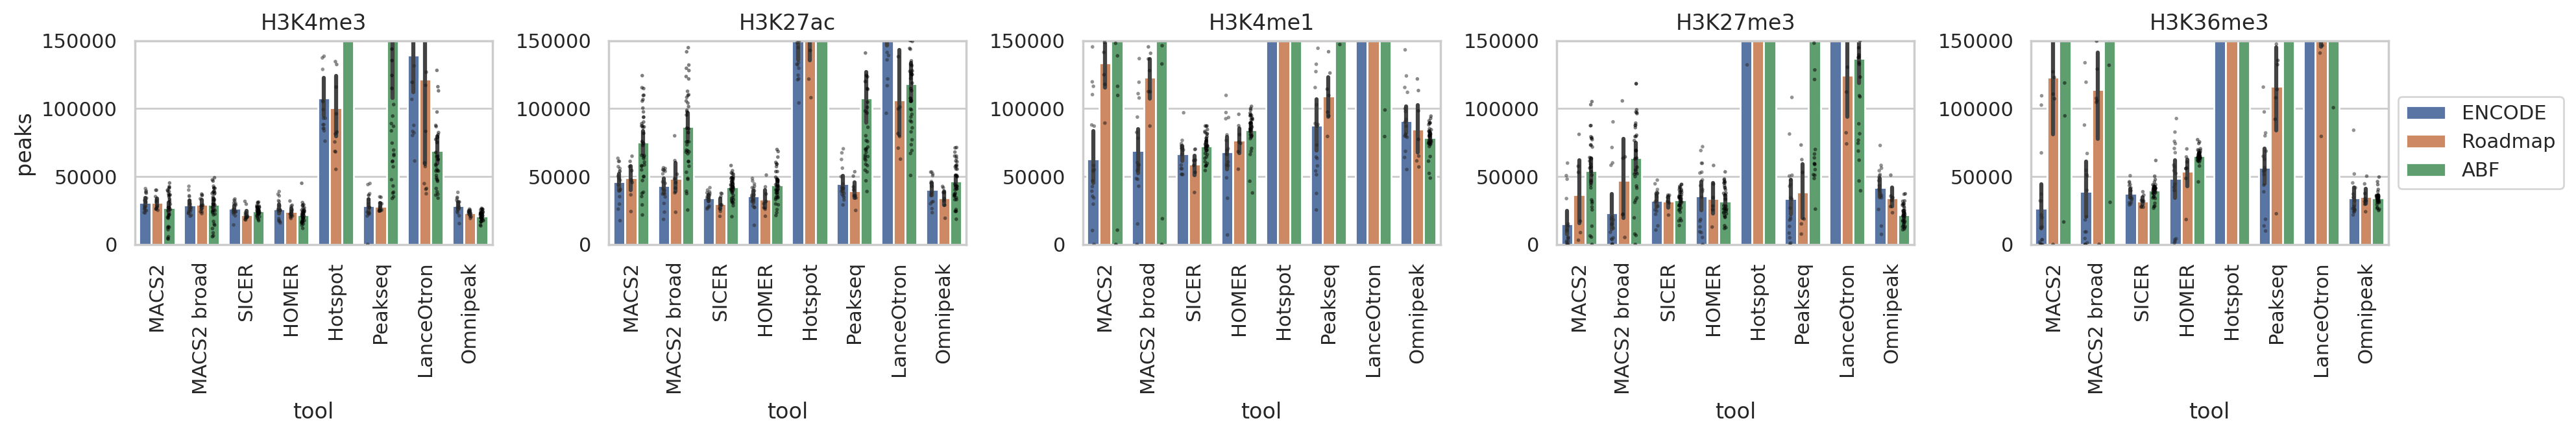

In [72]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    dfm = df_peaks[df_peaks['modification'] == m]
    sns.barplot(data=dfm, x='tool', y='peaks', hue='dataset',
                # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=dfm, x='tool', y='peaks', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5,
                  order=TOOLS,
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(bottom=0, top=150_000)
plt.tight_layout()
plt.show()

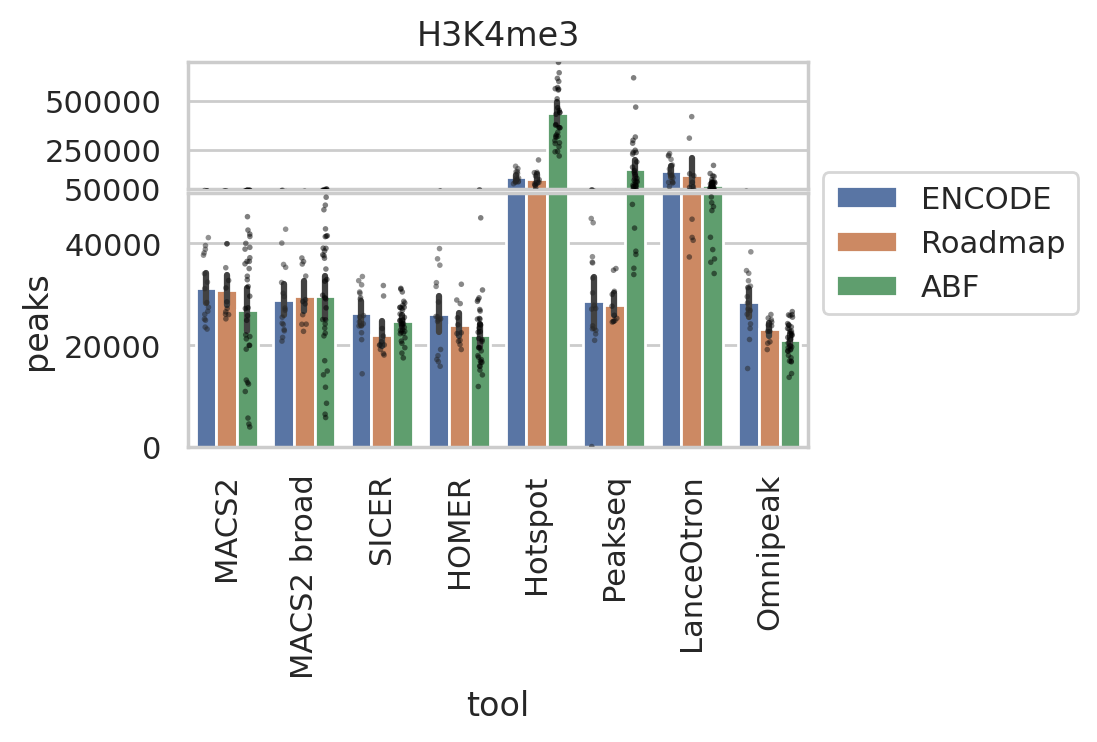

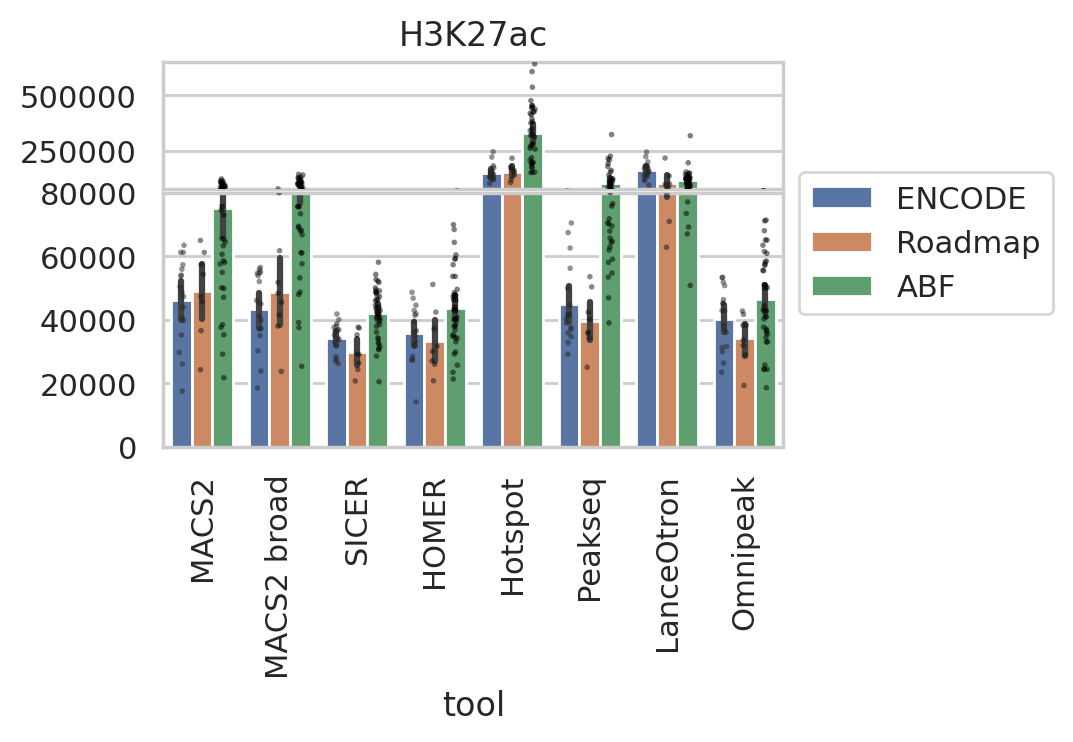

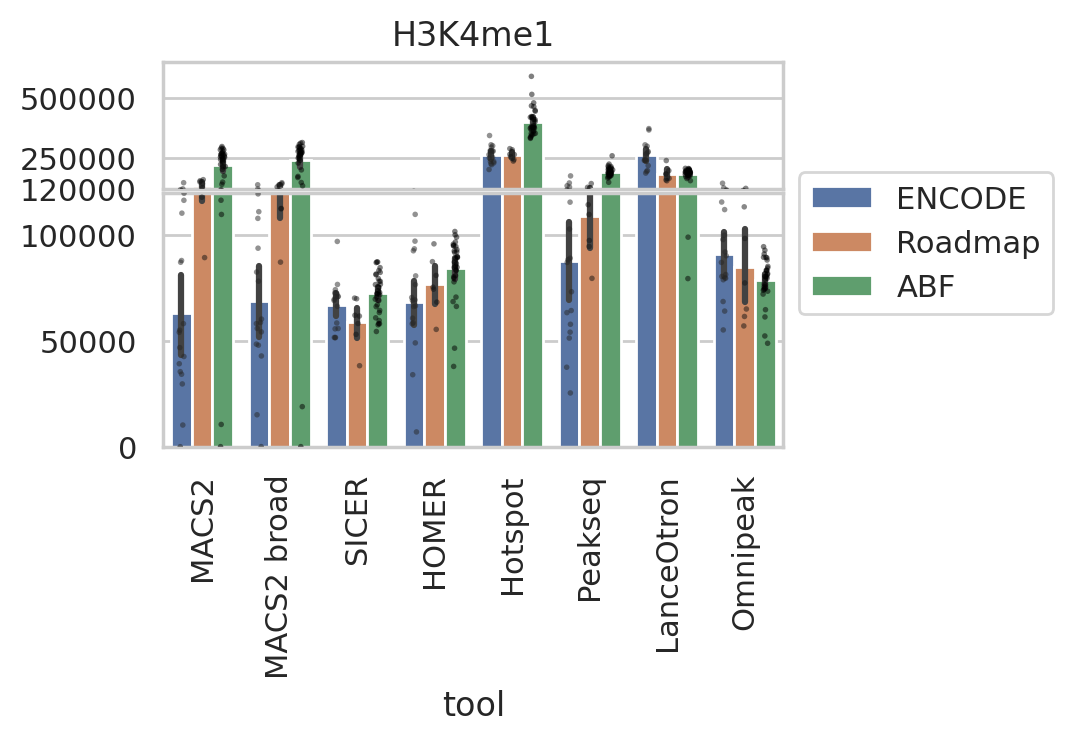

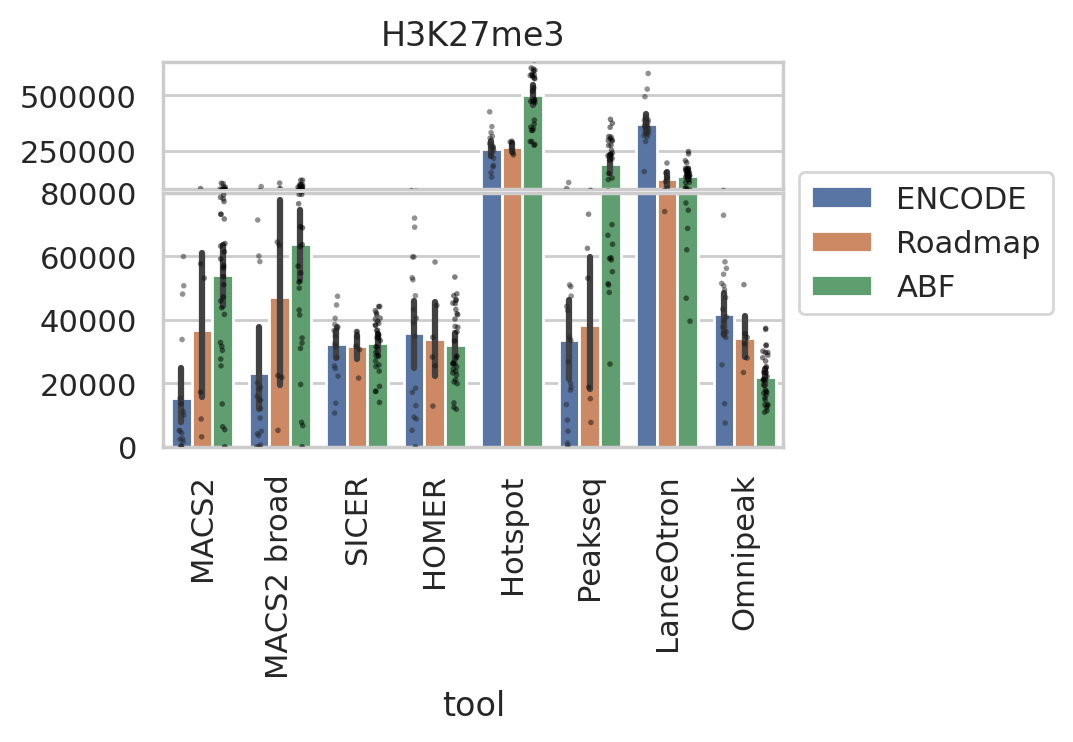

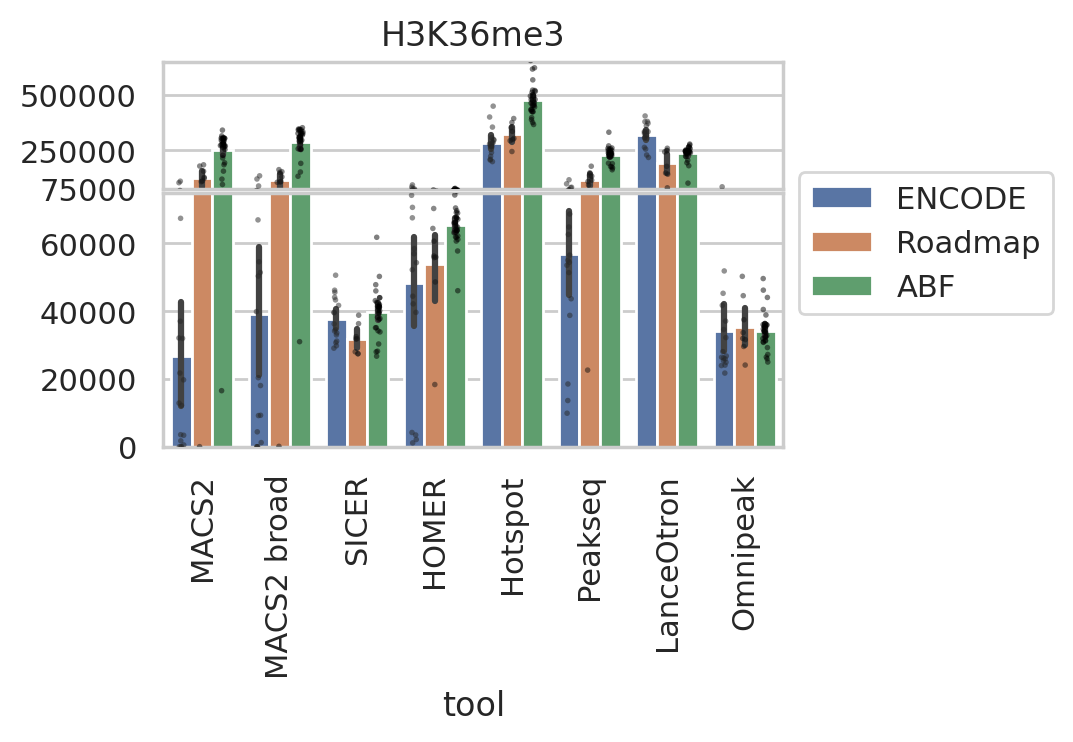

In [73]:
sns.set_style('whitegrid')
for i, m in enumerate(MODIFICATIONS):
    dfm = df_peaks[df_peaks['modification'] == m]
    # Set up the matplotlib figure with broken y-axis
    f, (axt, ax) = plt.subplots(2, 1, sharex=True, figsize=(4, 2.5),
                                gridspec_kw={'height_ratios': [1, 2]})
    for j, axes in enumerate([ax, axt]):
        sns.barplot(data=dfm, x='tool', y='peaks', hue='dataset',
                    order=TOOLS,
                    hue_order=['ENCODE', 'Roadmap', 'ABF'],
                    ax=axes)
        sns.stripplot(data=dfm, x='tool', y='peaks', hue='dataset',
                      dodge=True, size=2, palette='dark:black', alpha=0.5,
                      order=TOOLS,
                      hue_order=['ENCODE', 'Roadmap', 'ABF'],
                      legend=False,
                      ax=axes)
    if m == 'H3K4me3':
        ax.set_ylim(bottom=0, top=50_000)
        axt.set_ylim(bottom=50_000, top=700_000)
        axt.set_yticks([50_000, 250_000, 500_000])
    elif m == 'H3K27ac':
        ax.set_ylim(bottom=0, top=80_000)
        axt.set_ylim(bottom=80_000, top=650_000)
        axt.set_yticks([250_000, 500_000])
    elif m == 'H3K4me1':
        ax.set_ylim(bottom=0, top=120_000)
        axt.set_ylim(bottom=120_000, top=650_000)
        axt.set_yticks([120_000, 250_000, 500_000])
    elif m == 'H3K27me3':
        ax.set_ylim(bottom=0, top=80_000)
        axt.set_ylim(bottom=80_000, top=650_000)
        axt.set_yticks([250_000, 500_000])
    elif m == 'H3K36me3':
        ax.set_ylim(bottom=0, top=75_000)
        axt.set_ylim(bottom=75_000, top=650_000)
        axt.set_yticks([75_000, 250_000, 500_000])

    axt.set_xlabel(None)
    axt.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    axt.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    axt.legend().set_visible(False)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    # plt.tight_layout()
    plt.subplots_adjust(hspace=0.02)  # Adjust hspace closer to zero to remove spacing
    plt.show()

# Lengths

In [74]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(list(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
))):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['footprint'] = sum(lengths)
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts, t
df_lens.sample(10)

Load lengths


  0%|          | 0/2320 [00:00<?, ?it/s]

length  dataset modification     cell replicate         tool  \
1728864   1799.0   ENCODE     H3K36me3       H1      rep2        SICER   
11587554   832.0      ABF      H3K4me1       YD      YD11  MACS2 broad   
14048032  2999.0      ABF     H3K27me3       OD      OD16        SICER   
11532440   163.0      ABF      H3K4me1       OD       OD6  MACS2 broad   
5312685    541.0   ENCODE      H3K4me3  GM12878      rep2      Peakseq   
8094922    500.0  Roadmap     H3K27me3      CD4                  HOMER   
3747029    659.0   ENCODE     H3K27me3    HepG2      rep1        HOMER   
5262093     43.0   ENCODE     H3K27me3     HMEC      rep2      Peakseq   
10938466   160.0      ABF      H3K4me1       OD      OD15        MACS2   
8079687   2007.0  Roadmap      H3K4me3     CD34                  HOMER   

          footprint  
1728864   105359107  
11587554   84003322  
14048032  122332230  
11532440   96081478  
5312685    30375136  
8094922    10154363  
3747029    28013321  
5262093     5985209  
10938466  141034163  
8079687    42568713

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


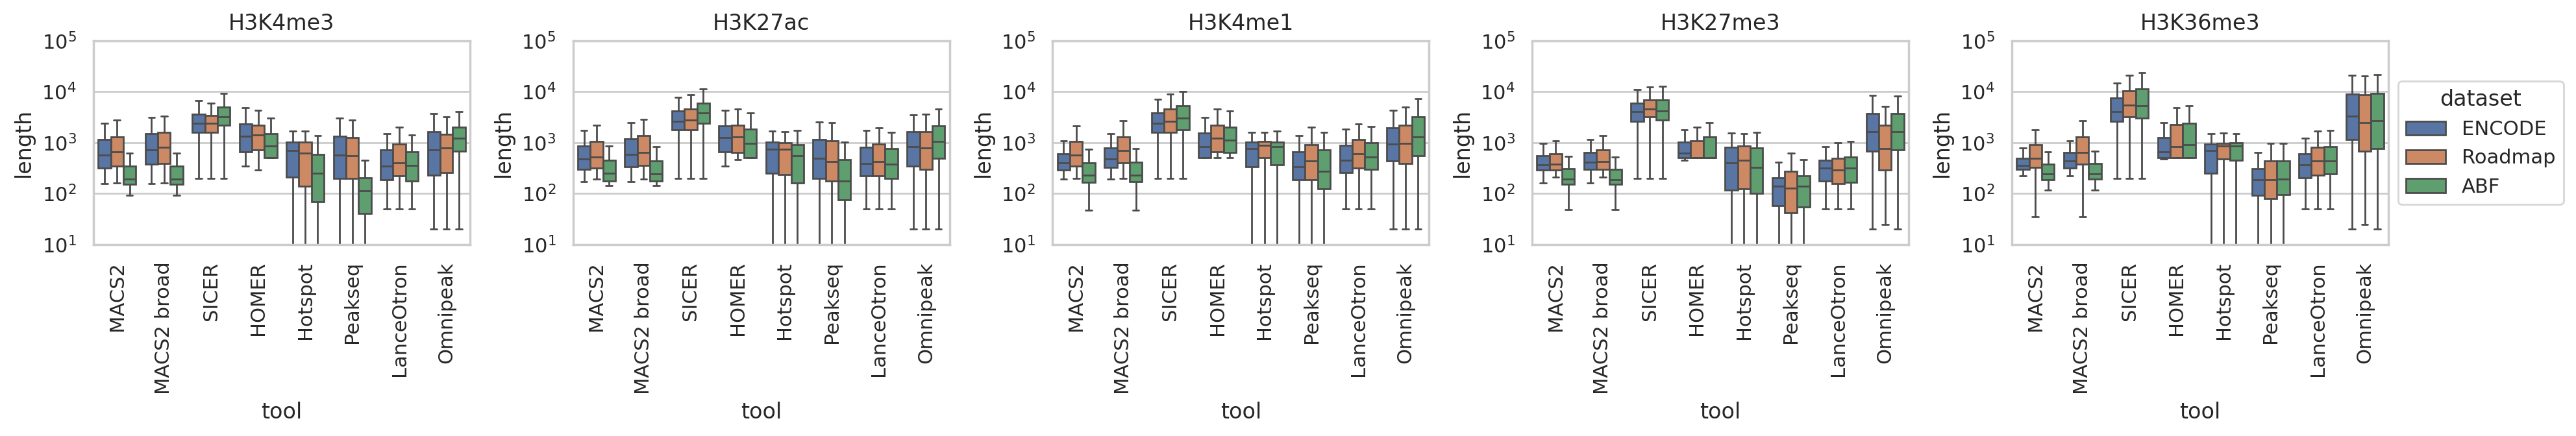

In [75]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens[df_lens['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    ax.title.set_text(m)

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K36me3']:
        ax.set_ylim(bottom=10, top=1e5)
    else:
        ax.set_ylim(bottom=10, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Average length

In [76]:
from collections import Counter

ts = []
for (ds, m, c, r, tool), dft in df_lens[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
    dft.sort_values(by=['length'], inplace=True)
    ts.append(dft.iloc[int(len(dft) * 0.1): int(len(dft) * 0.9)])
ts = pd.concat(ts).reset_index(drop=True)
df_lens_avg = ts.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
df_lens_avg['ds_c_r'] = df_lens_avg['dataset'] + ' ' + df_lens_avg['cell'] + ' ' + df_lens_avg['replicate']
df_lens_avg.sample(3)

dataset modification cell replicate      tool      length    footprint  \
86      ABF      H3K27ac   OD      OD19   Peakseq   262.12200   41892128.0   
653     ABF     H3K36me3   OD       OD5  Omnipeak  5148.40625  305260220.0   
267     ABF      H3K27ac   YD       YD4     MACS2   249.61650   11106093.0   

          ds_c_r  
86   ABF OD OD19  
653   ABF OD OD5  
267   ABF YD YD4

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


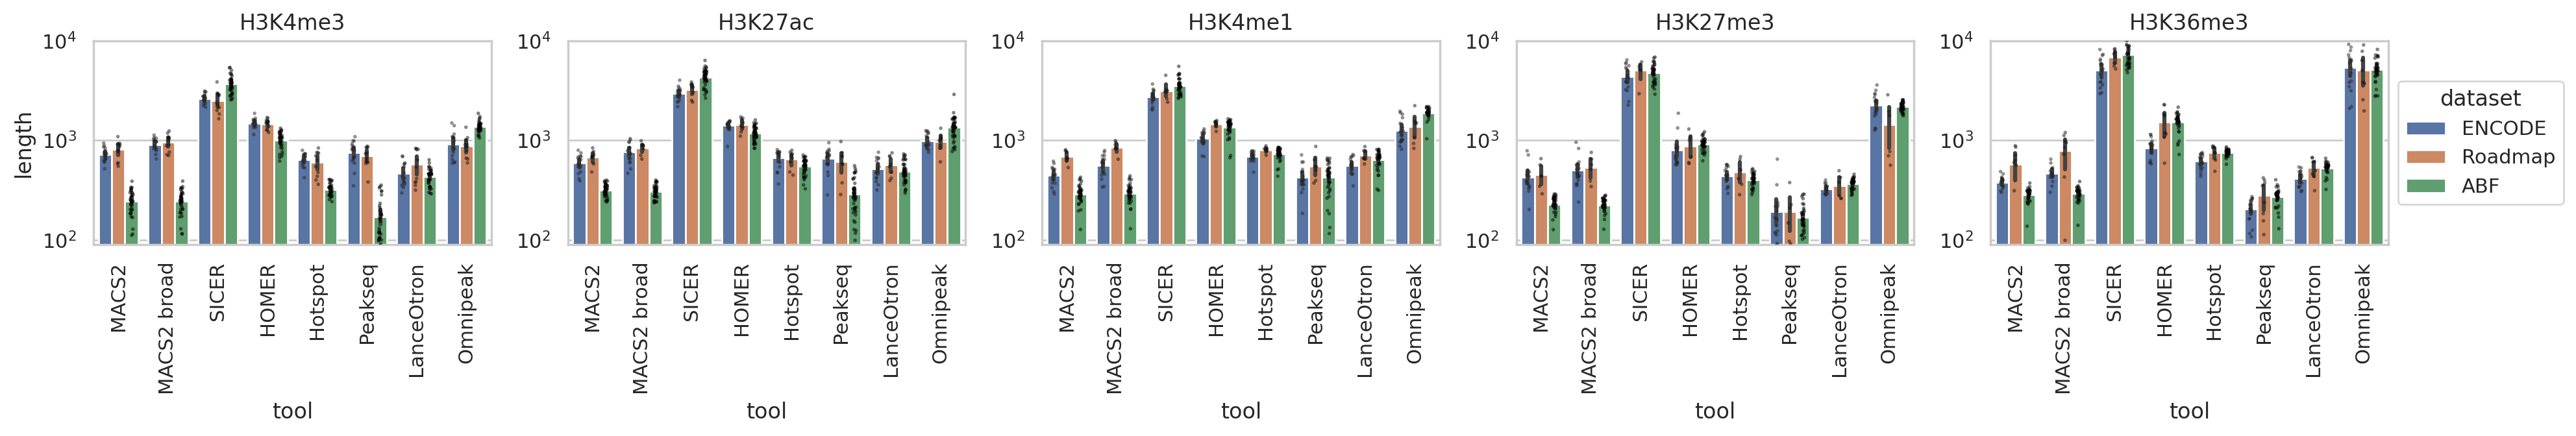

In [77]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.barplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5, legend=False,
                  order=TOOLS,
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(bottom=90, top=1e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


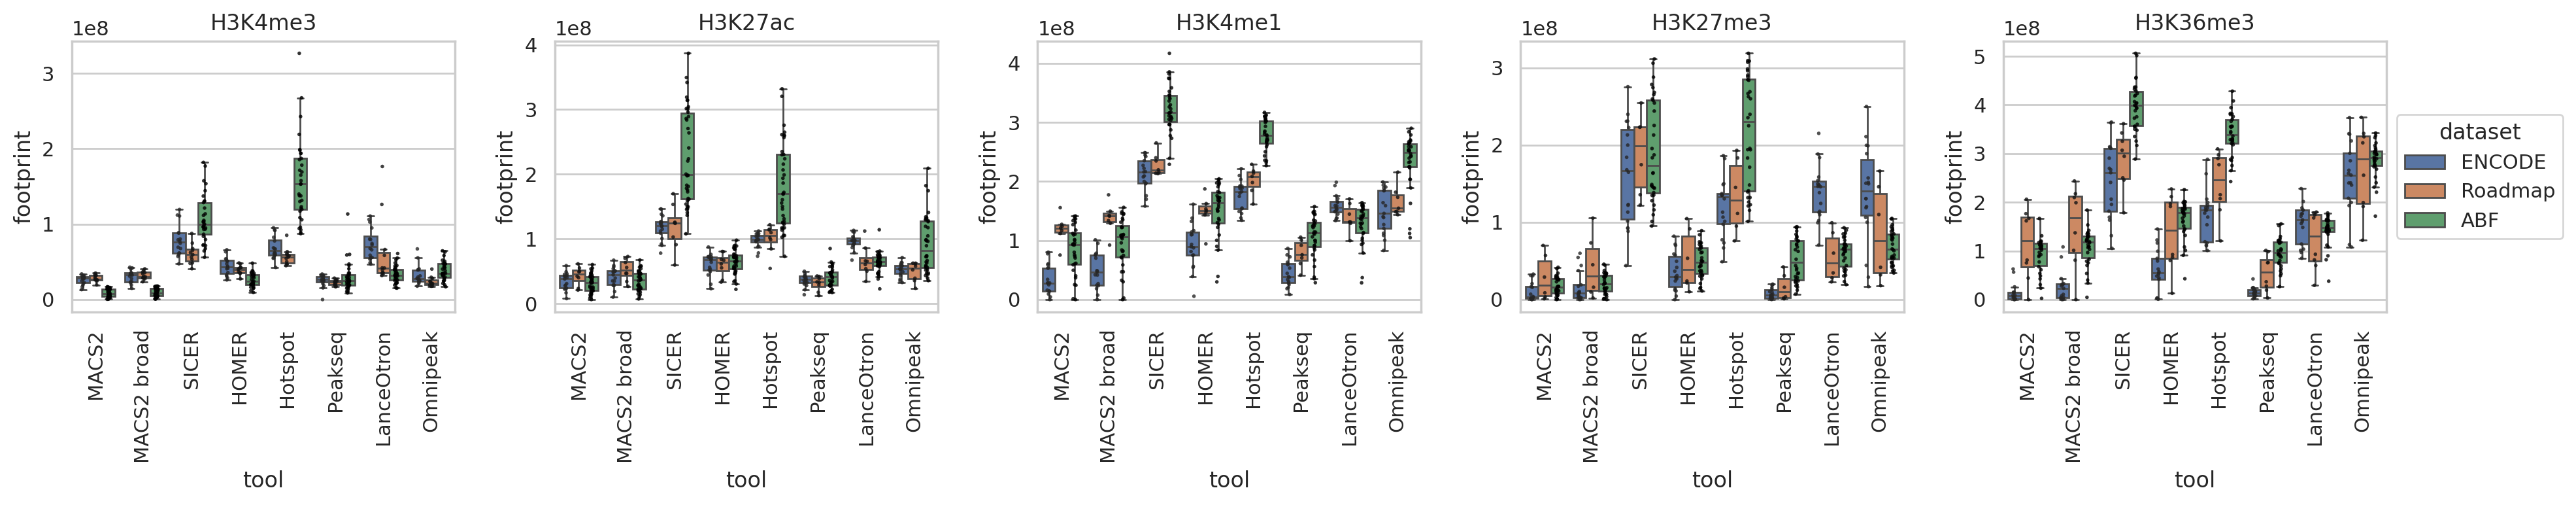

In [78]:
plt.figure(figsize=(20, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='footprint', hue='dataset',
                showfliers=False,
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='footprint', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.8, legend=False,
                  order=TOOLS,
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.title.set_text(m)

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Distance between peaks

In [79]:
print('Load distances')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(list(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
))):
    try:
        tf = pd.read_csv(file, sep='\t', header=None).sort_values(by=[0, 1, 2])
        tss = []
        for chr, tfc in tf.groupby(0):
            starts = tfc[1]
            ends = tfc[2]
            ends = np.roll(ends, 1)
            ds = starts - ends
            t = pd.DataFrame(dict(distance=ds))
            # Ignore first and last
            tss.append(t.iloc[1:min(1_000, len(t) - 1)])
        t = pd.concat(tss).reset_index(drop=True)
        t['dataset'] = dataset
        t['modification'] = mod
        t['cell'] = cell
        t['replicate'] = rep
        t['tool'] = tool
        ts.append(t)
    except:
        pass
df_distances = pd.concat(ts).reset_index(drop=True)
del ts, tss, t
df_distances.sample(10)

Load distances


  0%|          | 0/2320 [00:00<?, ?it/s]

distance  dataset modification    cell replicate         tool
4287651      27801   ENCODE     H3K27me3    NHLF      rep1        SICER
6941672     618622   ENCODE      H3K4me3    NHEK      rep2        HOMER
39551936      1052      ABF     H3K27me3      OD      OD13      Hotspot
5142072      35965   ENCODE      H3K27ac   Huvec      rep1     Omnipeak
42717496       428      ABF     H3K27me3      YD      YD20      Peakseq
35304478    143873      ABF      H3K4me1      OD       OD7        HOMER
12493008      1628   ENCODE      H3K27ac    K562      rep2   LanceOtron
33628063     18365      ABF     H3K36me3      YD      YD16     Omnipeak
24948520       756      ABF     H3K27me3      OD       OD2  MACS2 broad
17024400     15240  Roadmap      H3K4me3  CD4ABT      rep1     Omnipeak

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


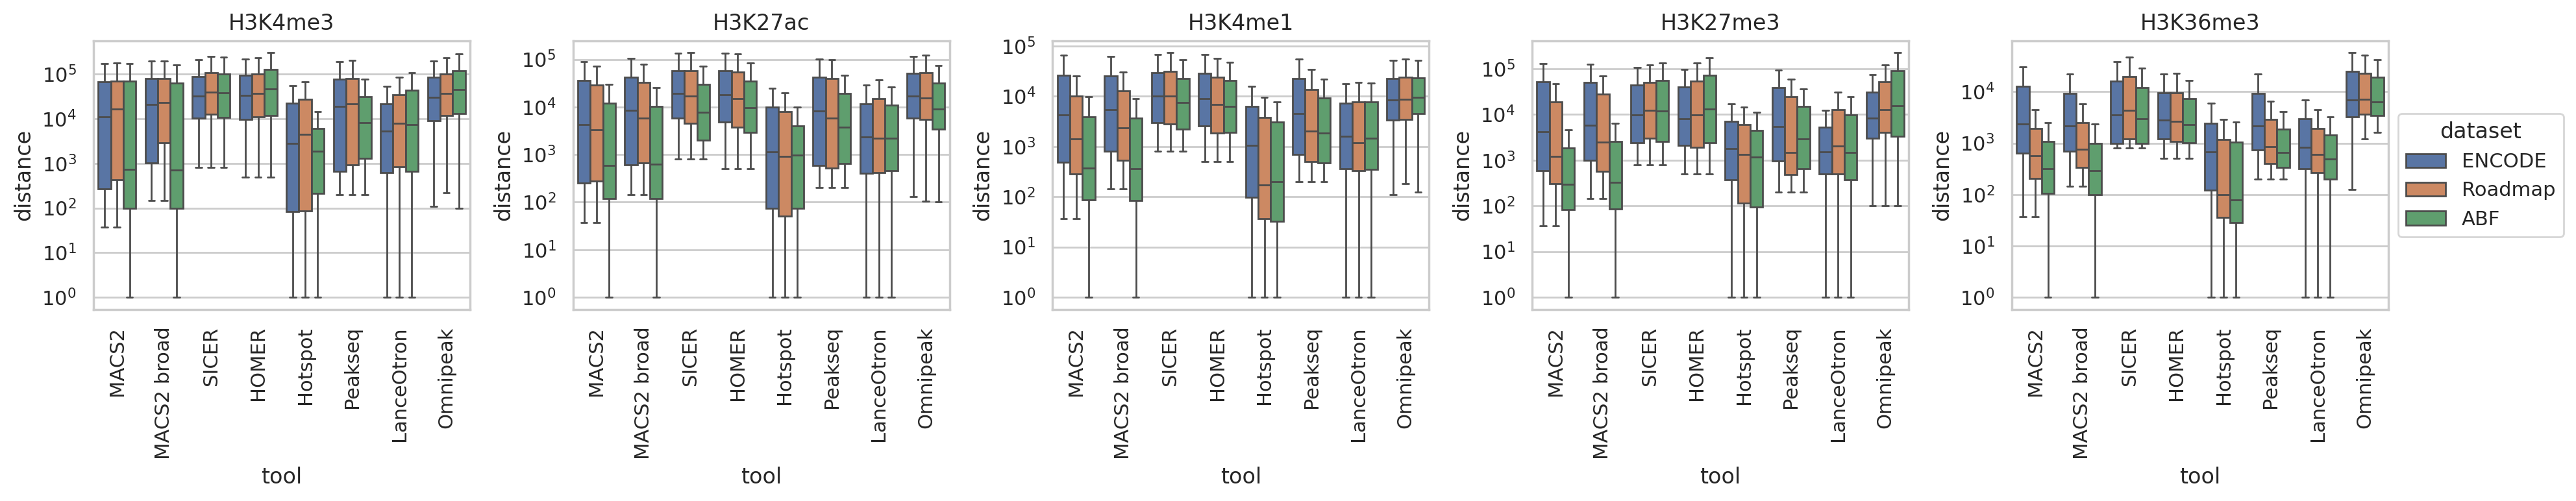

In [80]:
plt.figure(figsize=(20, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_distances[df_distances['modification'] == m],
                x='tool', y='distance', hue='dataset',
                showfliers=False,
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Average distance

In [81]:
# Keep % of peaks, since outliers may significantly shift results
ts = []
for (ds, m, c, r, tool), dft in df_distances[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'distance']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
    dft.sort_values(by=['distance'], inplace=True)
    ts.append(dft.iloc[int(len(dft) * 0.1): int(len(dft) * 0.9)])
    # ts.append(dft)
ts = pd.concat(ts).reset_index(drop=True)
df_distances_avg = ts.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
df_distances_avg['ds_c_r'] = df_distances_avg['dataset'] + ' ' + df_distances_avg['cell'] + ' ' + df_distances_avg[
    'replicate']
df_distances_avg.sample(3)

dataset modification  cell replicate      tool       distance  \
2041  Roadmap      H3K27ac  PBMC               MACS2   17629.484819   
499       ABF     H3K27me3    YD      YD18  Omnipeak  102269.612051   
741       ABF     H3K36me3    YD      YD18     SICER    7511.378108   

             ds_c_r  
2041  Roadmap PBMC   
499     ABF YD YD18  
741     ABF YD YD18

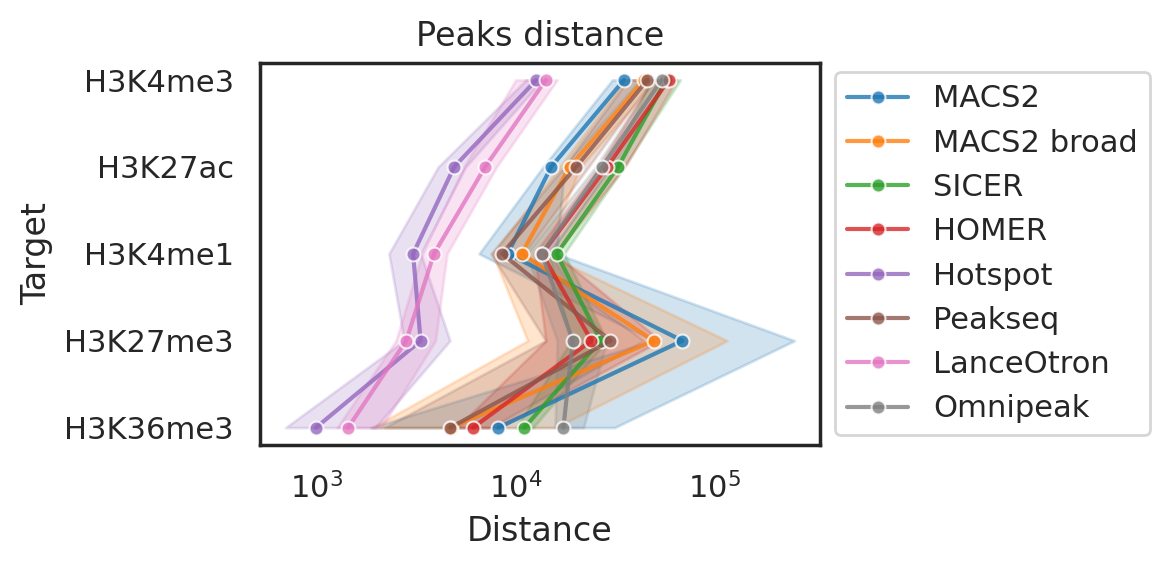

In [82]:
sns.set_theme(style="white")
df_lens['mindex'] = 0
for i, m in enumerate(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    df_distances_avg.loc[df_distances_avg['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
t = df_distances_avg[df_distances_avg['dataset'].isin(['ENCODE', 'Roadmap', ])]
g_results = sns.lineplot(data=t.sort_values(by=['mindex', 'tool', 'distance']),
                         x='distance', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         hue_order=TOOLS,
                         palette=TOOLS_PALETTE,
                         marker='o', markersize=5
                         )
g_results.axes.set_yticks(range(5), minor=False)
g_results.axes.set_yticklabels(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Distance')
g_results.set(xscale='log')
g_results.axes.title.set_text(f'Peaks distance')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
sns.set_theme(style="whitegrid")

# Avg length vs distance

ENCODE + Roadmap


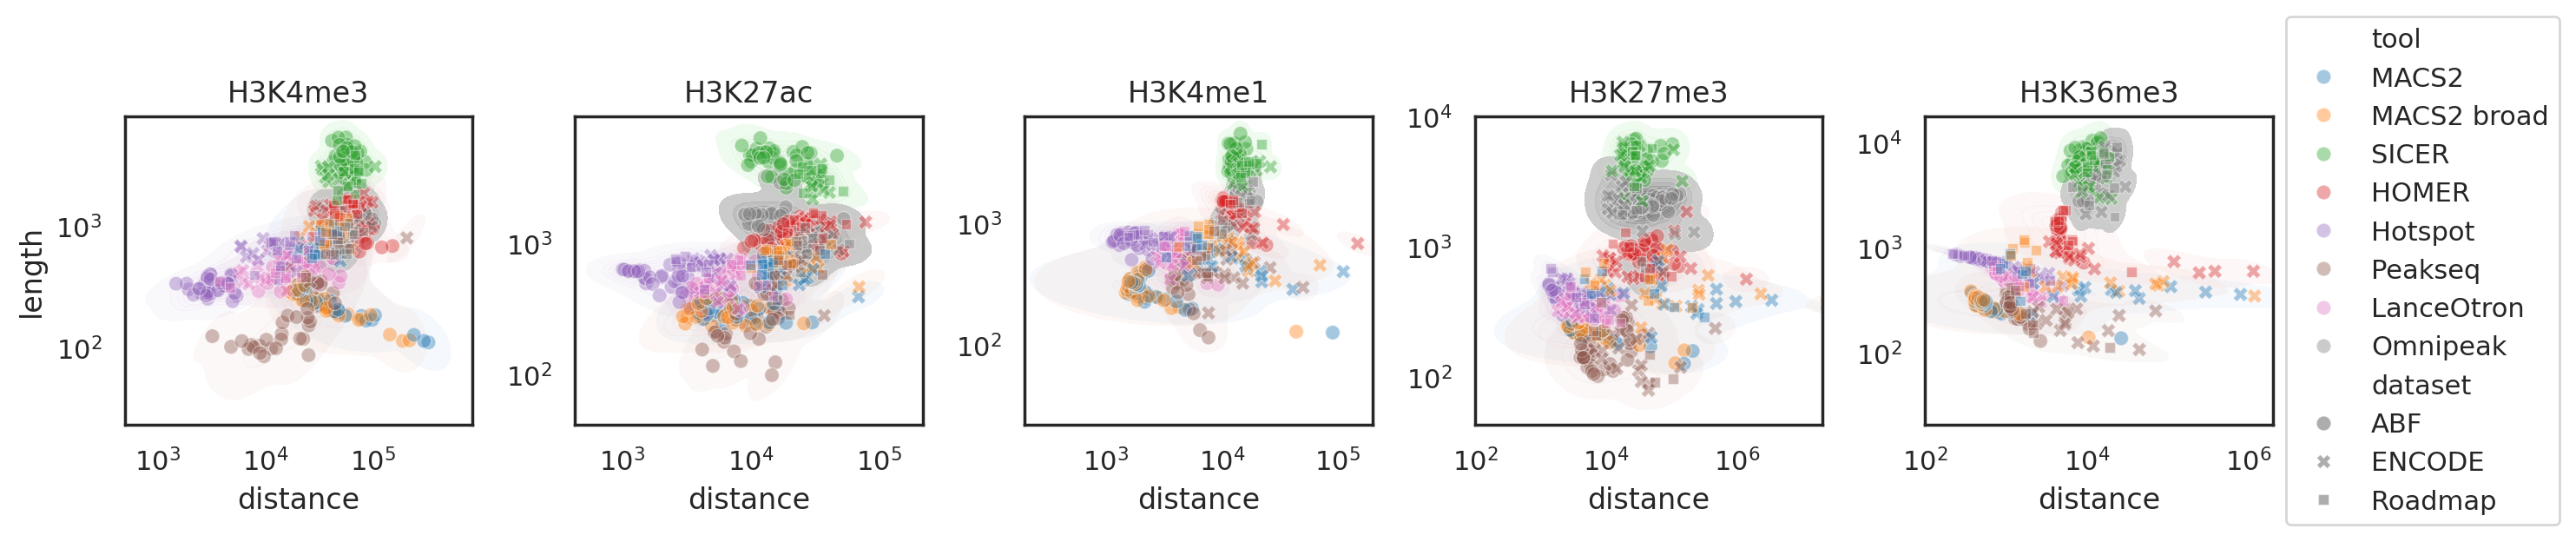

In [83]:
print('ENCODE + Roadmap')
sns.set_theme(style="white")
t = pd.merge(df_lens_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']],
             df_distances_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'distance']],
             on=['dataset', 'modification', 'cell', 'replicate', 'tool'])

plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    tm = t[(t['modification'] == m)]
    sns.kdeplot(
        tm[tm['tool'] != 'Omnipeak'], x='distance', y='length', hue='tool',
        alpha=0.1,
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        thresh=0.01,
        log_scale=True,
        fill=True,
        legend=False,
        ax=ax)
    sns.kdeplot(
        tm[tm['tool'] == 'Omnipeak'], x='distance', y='length', hue='tool',
        alpha=0.8,
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        thresh=0.01,
        log_scale=True,
        fill=True,
        legend=False,
        ax=ax)
    sns.scatterplot(tm,
                    palette=TOOLS_PALETTE,
                    hue_order=TOOLS,
                    style='dataset',
                    x='distance', y='length', hue='tool', alpha=0.4,
                    ax=ax)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(xscale='log')
    ax.set(yscale='log')
    if m == 'H3K4me1':
        ax.set_xlim(2e2, 2e5)
    if m == 'H3K27me3':
        ax.set_xlim(1e2, 2e7)
    if m == 'H3K36me3':
        ax.set_xlim(1e2, 2e6)
plt.tight_layout()
plt.show()
sns.set_theme(style="whitegrid")

# ATAC-seq, CTCF info



In [84]:
def simple_load_peaks(path, suffix):
    df = pd.DataFrame(columns=['file', 'peaks'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        file = os.path.join(path, f)
        ps = lines(file)
        df.loc[len(df)] = (file, ps)
    return df


def simple_load_peaks_path(path):
    df_macs2 = simple_load_peaks(os.path.join(path, 'macs2'), '.narrowPeak')
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2_broad = simple_load_peaks(os.path.join(path, 'macs2'), '.broadPeak')
    df_macs2_broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2_broad))

    df_sicer = simple_load_peaks(os.path.join(path, 'sicer'), '.scoreisland')
    if len(df_sicer) == 0:
        df_sicer = simple_load_peaks(os.path.join(path, 'sicer'), '-FDR0.01')
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_omnipeak = simple_load_peaks(os.path.join(path, 'omnipeak'), '.peak')
    df_omnipeak['tool'] = 'Omnipeak'
    print('Omnipeak', len(df_omnipeak))

    df_homer = simple_load_peaks(os.path.join(path, 'homer'), '.peaks')
    df_homer['tool'] = 'HOMER'
    print('HOMER', len(df_homer))

    df_hotspot = simple_load_peaks(os.path.join(path, 'hotspot'), '.peak')
    df_hotspot['tool'] = 'Hotspot'
    print('Hotspot', len(df_hotspot))

    df_peakseq = simple_load_peaks(os.path.join(path, 'peakseq'), '.narrowPeak')
    df_peakseq['tool'] = 'Peakseq'
    print('Peakseq', len(df_peakseq))

    df_lanceotron = simple_load_peaks(os.path.join(path, 'lanceotron'), '.bed')
    df_lanceotron['tool'] = 'LanceOtron'
    print('LanceOtron', len(df_lanceotron))

    return pd.concat([df_macs2, df_macs2_broad, df_sicer, df_omnipeak, df_homer, df_hotspot, df_peakseq, df_lanceotron]).reset_index(
        drop=True)

In [85]:
ATAC_PATH = os.path.expanduser('~/data/2024_Immgen')
dfa = simple_load_peaks_path(ATAC_PATH)
dfa

  0%|          | 0/1480 [00:00<?, ?it/s]

MACS2 185


  0%|          | 0/1480 [00:00<?, ?it/s]

MACS2 broad 185


  0%|          | 0/185 [00:00<?, ?it/s]

SICER 185


  0%|          | 0/740 [00:00<?, ?it/s]

Omnipeak 185


  0%|          | 0/185 [00:00<?, ?it/s]

HOMER 185


  0%|          | 0/185 [00:00<?, ?it/s]

Hotspot 185


0it [00:00, ?it/s]

Peakseq 0


  0%|          | 0/366 [00:00<?, ?it/s]

LanceOtron 183


file   peaks        tool
0     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   17421       MACS2
1     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   64081       MACS2
2     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   21233       MACS2
3     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   29318       MACS2
4     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   37337       MACS2
...                                                 ...     ...         ...
1288  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  281553  LanceOtron
1289  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  238811  LanceOtron
1290  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  250286  LanceOtron
1291  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  261937  LanceOtron
1292  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  207733  LanceOtron

[1293 rows x 3 columns]

In [86]:
ts = []
for tool, file in tqdm(zip(dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t.sort_values(by=['length'], inplace=True)
    t = t.sample(min(len(t), 10_000)).copy()
    t = t.iloc[: int(len(t) * 0.9)].copy()  # ATAC-seq may include large domains, skip them
    t['tool'] = tool
    t['file'] = file
    ts.append(t)
dfa_lens = pd.concat(ts).reset_index(drop=True)
dfa_lens['modification'] = 'ATAC'
dfa_lens['dataset'] = 'Immgen'
dfa_lens_avg = dfa_lens.groupby(['dataset', 'modification', 'tool', 'file']).agg('mean').reset_index()
del ts
display(dfa_lens_avg.sample(10))

0it [00:00, ?it/s]

dataset modification         tool  \
694   Immgen         ATAC        MACS2   
494   Immgen         ATAC   LanceOtron   
357   Immgen         ATAC      Hotspot   
607   Immgen         ATAC        MACS2   
374   Immgen         ATAC   LanceOtron   
784   Immgen         ATAC  MACS2 broad   
976   Immgen         ATAC     Omnipeak   
695   Immgen         ATAC        MACS2   
1121  Immgen         ATAC        SICER   
54    Immgen         ATAC        HOMER   

                                                   file       length  
694   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   194.228667  
494   /home/jetbrains/data/2024_Immgen/lanceotron/SR...   356.191667  
357   /home/jetbrains/data/2024_Immgen/hotspot/SRR57...   374.813556  
607   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   201.590889  
374   /home/jetbrains/data/2024_Immgen/lanceotron/SR...   362.047333  
784   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   233.395889  
976   /home/jetbrains/data/2024_Immgen/omnipeak/SRR5...   448.954444  
695   /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   214.010889  
1121  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  1840.822222  
54    /home/jetbrains/data/2024_Immgen/homer/SRR5799...   943.052444

In [87]:
CTCF_PATH = os.path.expanduser('~/data/2024_TFs')
df_ctcf = simple_load_peaks_path(CTCF_PATH)
display(df_ctcf)

  0%|          | 0/74 [00:00<?, ?it/s]

MACS2 9


  0%|          | 0/74 [00:00<?, ?it/s]

MACS2 broad 11


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

SICER 9


  0%|          | 0/45 [00:00<?, ?it/s]

Omnipeak 9


  0%|          | 0/9 [00:00<?, ?it/s]

HOMER 9


  0%|          | 0/9 [00:00<?, ?it/s]

Hotspot 9


  0%|          | 0/15 [00:00<?, ?it/s]

Peakseq 9


  0%|          | 0/18 [00:00<?, ?it/s]

LanceOtron 9


file   peaks        tool
0   /home/jetbrains/data/2024_TFs/macs2/Monocyte_C...   24810       MACS2
1   /home/jetbrains/data/2024_TFs/macs2/GM12878_re...   50063       MACS2
2   /home/jetbrains/data/2024_TFs/macs2/H1_CTCF_EN...   61358       MACS2
3   /home/jetbrains/data/2024_TFs/macs2/NHLF_CTCF_...   18950       MACS2
4   /home/jetbrains/data/2024_TFs/macs2/BCell_CTCF...   30160       MACS2
..                                                ...     ...         ...
69  /home/jetbrains/data/2024_TFs/lanceotron/K562_...  205646  LanceOtron
70  /home/jetbrains/data/2024_TFs/lanceotron/NK_CT...   35818  LanceOtron
71  /home/jetbrains/data/2024_TFs/lanceotron/Monoc...  284628  LanceOtron
72  /home/jetbrains/data/2024_TFs/lanceotron/HepG2...  134669  LanceOtron
73  /home/jetbrains/data/2024_TFs/lanceotron/BCell...   47600  LanceOtron

[74 rows x 3 columns]

In [88]:
ts = []
for tool, file in tqdm(zip(df_ctcf['tool'], df_ctcf['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['tool'] = tool
    t['file'] = file
    ts.append(t)
dfa_ctcf_lens = pd.concat(ts).reset_index(drop=True)
dfa_ctcf_lens['modification'] = 'CTCF'
dfa_ctcf_lens['dataset'] = 'CTCF'
dfa_ctcf_lens_avg = dfa_ctcf_lens.groupby(['dataset', 'modification', 'tool', 'file']).agg('mean').reset_index()
del ts
display(dfa_ctcf_lens_avg.sample(3))

0it [00:00, ?it/s]

dataset modification         tool  \
41    CTCF         CTCF  MACS2 broad   
32    CTCF         CTCF        MACS2   
66    CTCF         CTCF        SICER   

                                                 file     length  
41  /home/jetbrains/data/2024_TFs/macs2/K562_rep1_...   377.2184  
32  /home/jetbrains/data/2024_TFs/macs2/K562_rep1_...   353.8468  
66  /home/jetbrains/data/2024_TFs/sicer/H1_CTCF_EN...  1073.6000

In [89]:
# Keep % of peaks, since outliers may significantly shift results
tracks_per_dataset = 20
ds_counter = Counter()
ts = []
for (ds, m, tool), dft in pd.concat([df_lens_avg, dfa_ctcf_lens_avg, dfa_lens_avg]).groupby(
        ['dataset', 'modification', 'tool']):
    c = ds_counter[(ds, m, tool)]
    if c >= tracks_per_dataset:
        continue
    ds_counter[(ds, m, tool)] += (tracks_per_dataset - c)
    ts.append(dft.head(tracks_per_dataset - c))

df_lens_balanced_avg = pd.concat(ts).reset_index()
display(df_lens_balanced_avg.sample(3))
# ds_counter

index dataset modification cell replicate         tool       length  \
641   1064     ABF      H3K4me3   OD      OD10        HOMER  1124.896625   
57     138     ABF      H3K27ac   OD       OD7   LanceOtron   638.639250   
80       4     ABF      H3K27ac   OD       OD1  MACS2 broad   335.781750   

      footprint       ds_c_r file  
641  24411601.0  ABF OD OD10  NaN  
57   70711415.0   ABF OD OD7  NaN  
80   24190751.0   ABF OD OD1  NaN

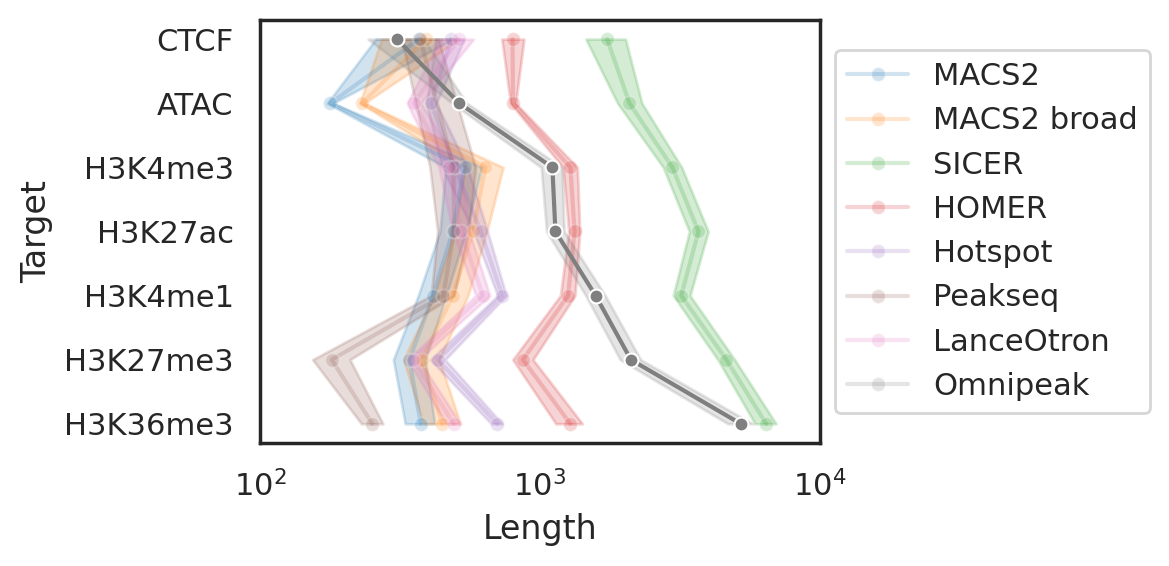

In [90]:
t = df_lens_balanced_avg.copy()

sns.set_theme(style="white")
t['mindex'] = 0
for i, m in enumerate(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    t.loc[t['modification'] == m, 'mindex'] = i
t = t.sort_values(by=['mindex', 'tool', 'length'])
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.lineplot(data=t[t['tool'] != 'Omnipeak'],
             x='length', y='mindex', hue='tool', orient='y',
             alpha=0.2,
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             ax=ax)
sns.lineplot(data=t[t['tool'] == 'Omnipeak'],
             x='length', y='mindex', hue='tool', orient='y',
             alpha=1.0,
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             legend=False,
             ax=ax)
ax.set_yticks(range(7), minor=False)
ax.set_yticklabels(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
ax.set_ylabel('Target')
ax.set_xlabel('Length')
ax.set(xscale='log')
ax.set_xlim(100, 1.0e4)
ax.title.set_text(f'')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# BAMs

In [91]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if mod and cell is not None and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [92]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

In [93]:
df_abf_bams = load_bams(ABF_PATH + '/bams', ABF_MODIFICATIONS, [''], ABF_REPLICATES, 'input')
update_abf_modifications(df_abf_bams)
df_abf_bams['dataset'] = 'ABF'
reads = ! samtools view -F 0x04 -c {ABF_PATH}/bams/input.bam
reads = int(reads[0])
df_abf_bams.loc[len(df_abf_bams)] = (f'{ABF_PATH}/bams/input.bam', 'Control', '', '', reads, 'ABF')

  0%|          | 0/384 [00:00<?, ?it/s]

In [94]:
def simple_load_bams(path):
    df_bams = pd.DataFrame(columns=['bam_file', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        file = os.path.join(path, f)
        reads = ! samtools view -F 0x04 -c {file}
        reads = int(reads[0])
        df_bams.loc[len(df_bams)] = (file, reads)
    return df_bams


In [95]:
ATAC_PATH = os.path.expanduser('~/data/2024_Immgen')
df_atac_reads = simple_load_bams(ATAC_PATH + '/bams')
df_atac_reads['dataset'] = 'Immgen'
df_atac_reads['modification'] = 'ATAC'
df_atac_reads.sample(3)

  0%|          | 0/370 [00:00<?, ?it/s]

bam_file     reads dataset  \
107  /home/jetbrains/data/2024_Immgen/bams/SRR57994...  22597051  Immgen   
137  /home/jetbrains/data/2024_Immgen/bams/SRR57994...  17311643  Immgen   
80   /home/jetbrains/data/2024_Immgen/bams/SRR57995...  17489665  Immgen   

    modification  
107         ATAC  
137         ATAC  
80          ATAC

In [96]:
CTCF_PATH = os.path.expanduser('~/data/2024_TFs')
df_ctcf_reads = simple_load_bams(CTCF_PATH + '/bams')
df_ctcf_reads['dataset'] = 'ENCODE'
df_ctcf_reads['modification'] = 'CTCF'
df_ctcf_reads.sample(3)

  0%|          | 0/27 [00:00<?, ?it/s]

bam_file     reads dataset  \
0   /home/jetbrains/data/2024_TFs/bams/Monocyte_Co...  20067734  ENCODE   
14  /home/jetbrains/data/2024_TFs/bams/K562_Input_...  10381382  ENCODE   
8   /home/jetbrains/data/2024_TFs/bams/NK_Control_...  24502572  ENCODE   

   modification  
0          CTCF  
14         CTCF  
8          CTCF

In [97]:
df_abf_bams['cell'] = ['OD' if r.startswith('OD') else 'YD' for r in df_abf_bams['replicate']]

In [98]:
df_bams_all = pd.concat([df_encode_bams, df_immune_bams, df_abf_bams, df_atac_reads, df_ctcf_reads]).reset_index(
    drop=True)
df_bams_all.sort_values(by=['dataset', 'modification'], inplace=True)

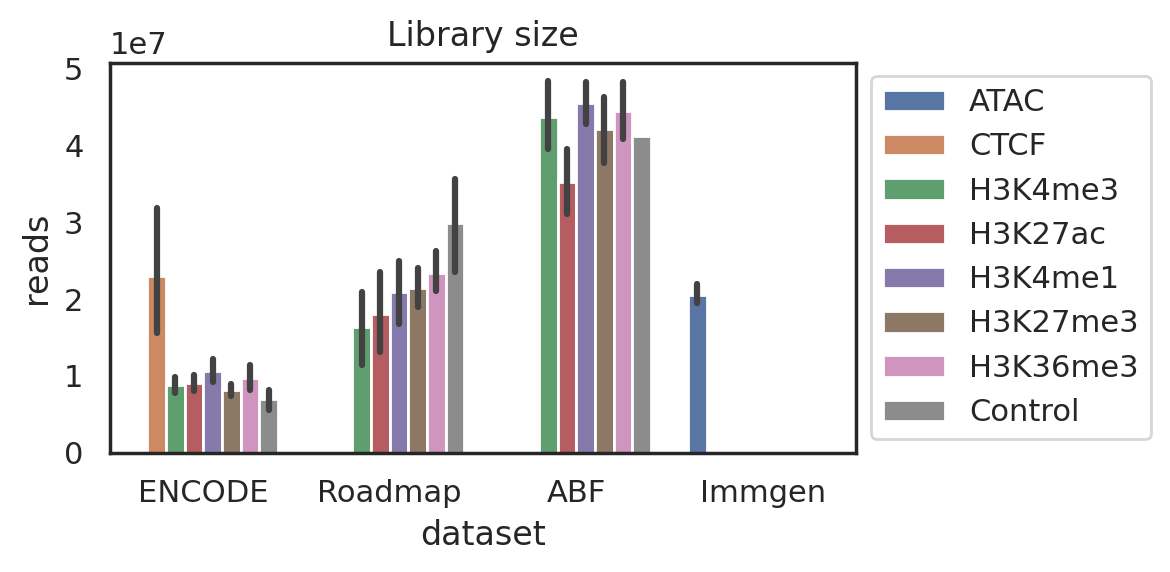

In [99]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_bams_all, hue='modification', x='dataset', y='reads',
            order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
            # capsize=.05, err_kws={'linewidth': 2}, edgecolor="black",
            hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
            ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [100]:
def file_to_name(file):
    return re.sub('(.*SRR[0-9]+_)|(_ATAC_seq.*)', '', os.path.basename(file))


def file_to_srr(file):
    return re.sub('_.*', '', os.path.basename(file))


df_atac_reads['cell'] = [file_to_name(f) for f in df_atac_reads['bam_file']]
df_atac_reads['srr'] = [file_to_srr(f) for f in df_atac_reads['bam_file']]

In [101]:
df_counts = df_bams_all[df_bams_all['modification'] != 'Control'].groupby(
    ['dataset', 'modification']).size().reset_index(name='counts')
df_counts

dataset modification  counts
0       ABF      H3K27ac      40
1       ABF     H3K27me3      40
2       ABF     H3K36me3      39
3       ABF      H3K4me1      32
4       ABF      H3K4me3      40
5    ENCODE         CTCF      18
6    ENCODE      H3K27ac      17
7    ENCODE     H3K27me3      18
8    ENCODE     H3K36me3      17
9    ENCODE      H3K4me1      17
10   ENCODE      H3K4me3      16
11   Immgen         ATAC     185
12  Roadmap      H3K27ac       9
13  Roadmap     H3K27me3       9
14  Roadmap     H3K36me3       8
15  Roadmap      H3K4me1       8
16  Roadmap      H3K4me3      12

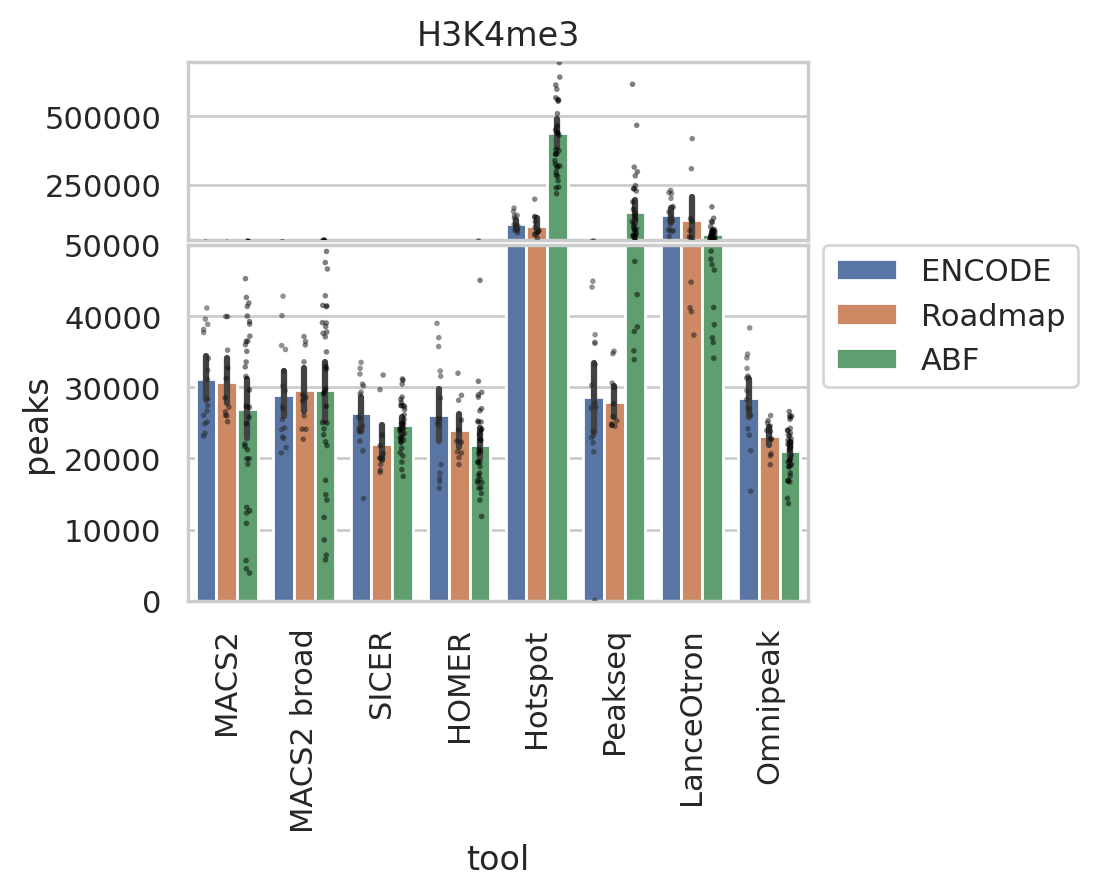

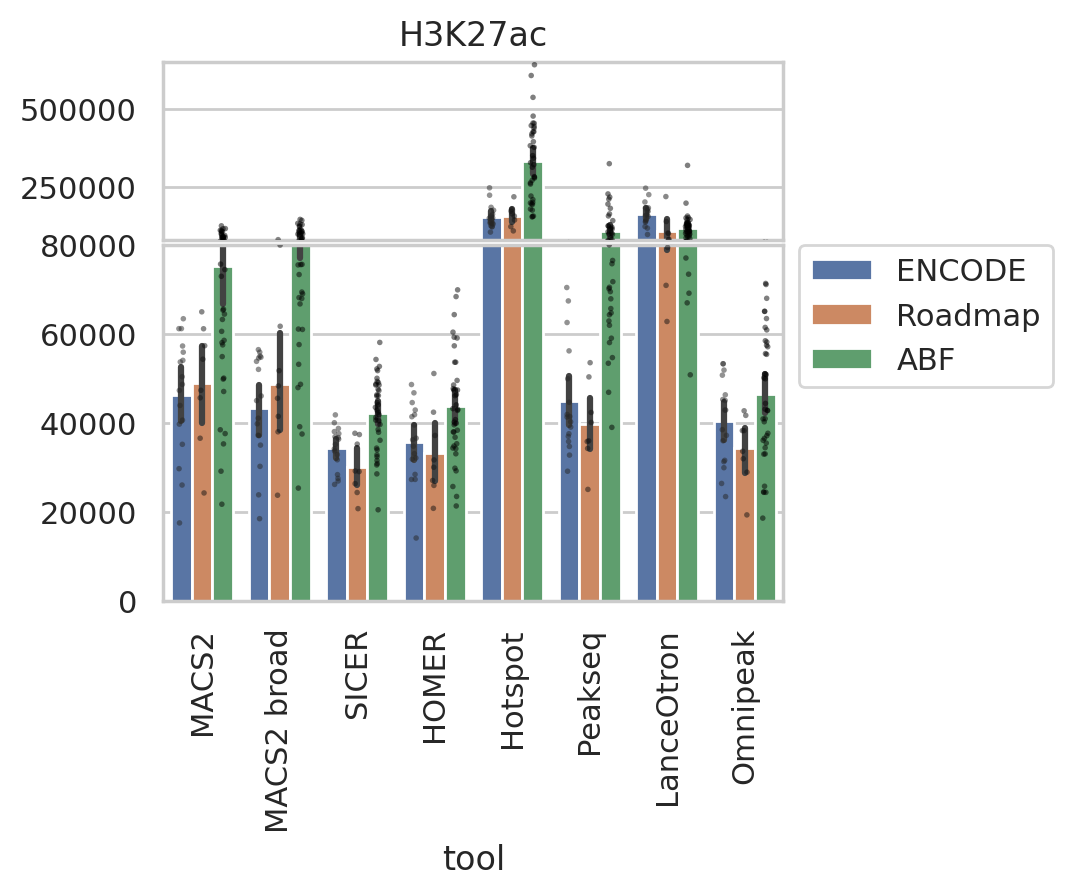

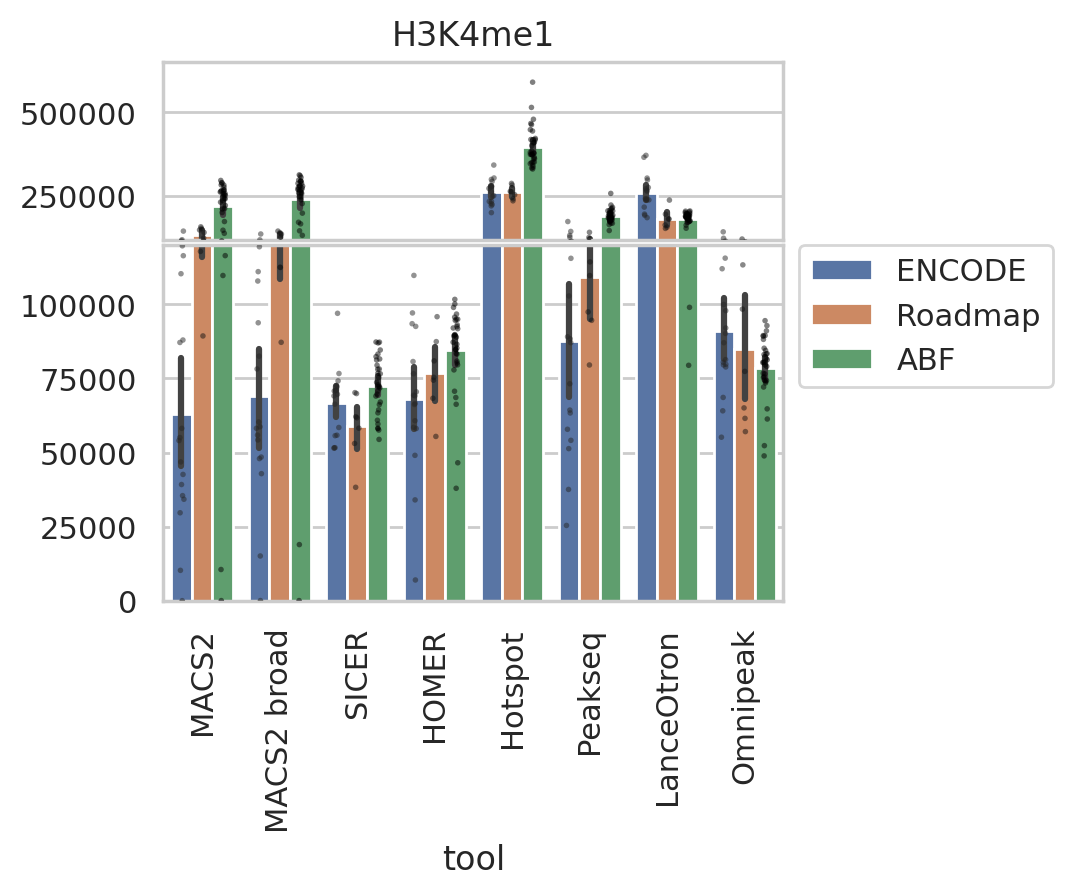

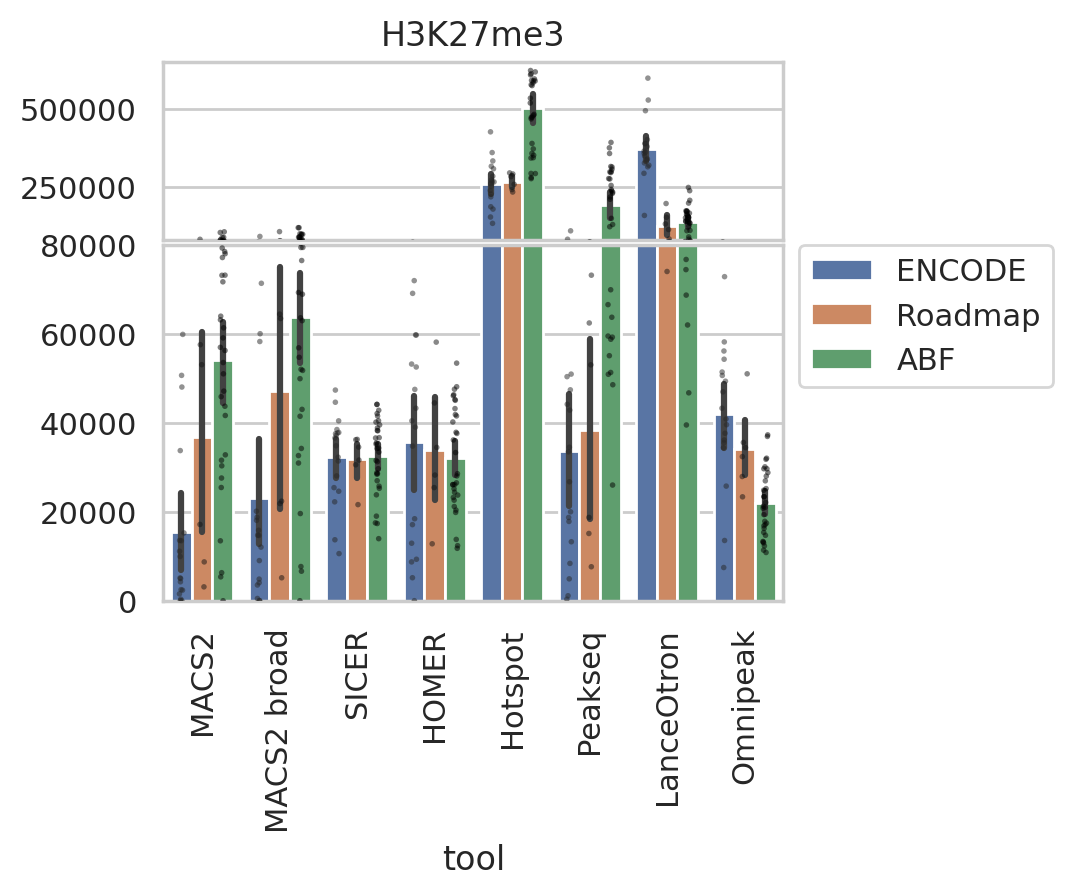

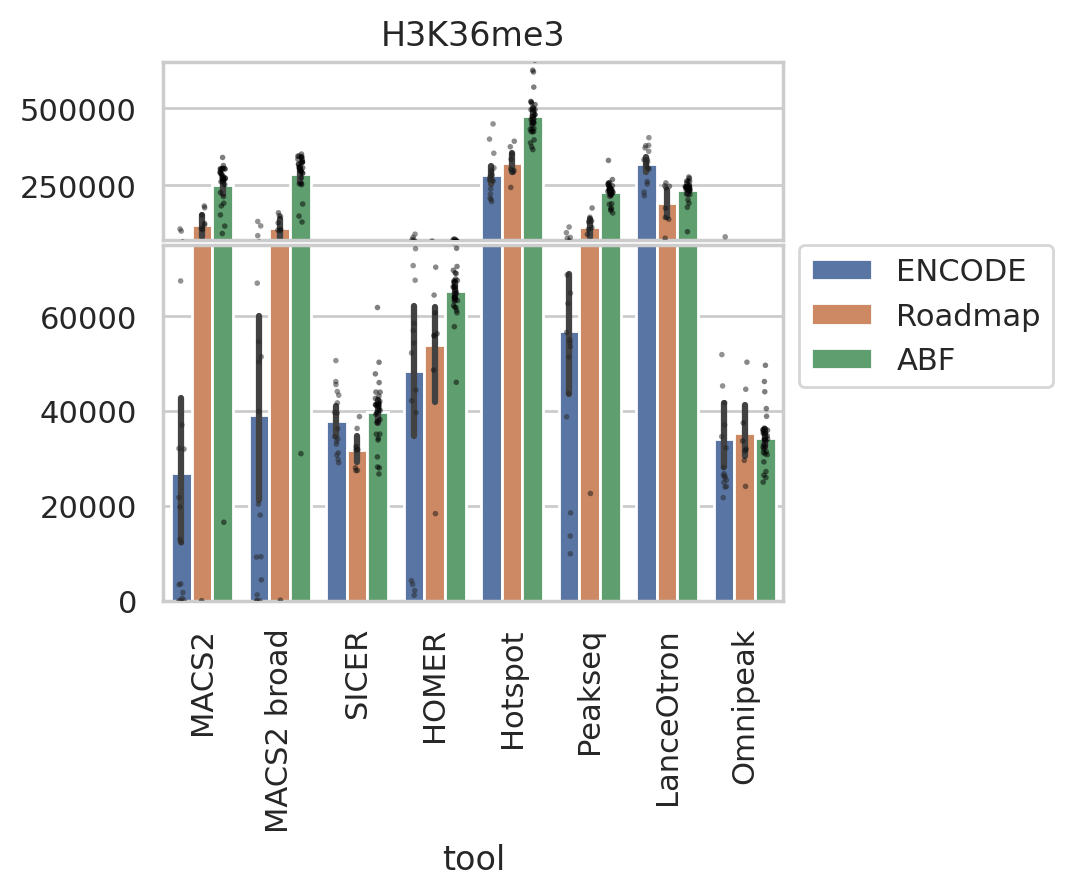

In [102]:
sns.set_style('whitegrid')
for i, m in enumerate(MODIFICATIONS):
    dfm = df_peaks[df_peaks['modification'] == m]
    # Set up the matplotlib figure with broken y-axis
    f, (axt, ax) = plt.subplots(2, 1, sharex=True, figsize=(4, 3.5),
                                gridspec_kw={'height_ratios': [1, 2]})
    for j, axes in enumerate([ax, axt]):
        sns.barplot(data=dfm, x='tool', y='peaks', hue='dataset',
                    order=TOOLS,
                    hue_order=['ENCODE', 'Roadmap', 'ABF'],
                    ax=axes)
        sns.stripplot(data=dfm, x='tool', y='peaks', hue='dataset',
                      dodge=True, size=2, palette='dark:black', alpha=0.5,
                      order=TOOLS,
                      hue_order=['ENCODE', 'Roadmap', 'ABF'],
                      legend=False,
                      ax=axes)
    if m == 'H3K4me3':
        ax.set_ylim(bottom=0, top=50_000)
        axt.set_ylim(bottom=50_000, top=700_000)
    elif m == 'H3K27ac':
        ax.set_ylim(bottom=0, top=80_000)
        axt.set_ylim(bottom=80_000, top=650_000)
    elif m == 'H3K4me1':
        ax.set_ylim(bottom=0, top=120_000)
        axt.set_ylim(bottom=120_000, top=650_000)
    elif m == 'H3K27me3':
        ax.set_ylim(bottom=0, top=80_000)
        axt.set_ylim(bottom=80_000, top=650_000)
    elif m == 'H3K36me3':
        ax.set_ylim(bottom=0, top=75_000)
        axt.set_ylim(bottom=75_000, top=650_000)

    axt.set_xlabel(None)
    axt.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    axt.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    axt.legend().set_visible(False)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    # plt.tight_layout()
    plt.subplots_adjust(hspace=0.02)  # Adjust hspace closer to zero to remove spacing
    plt.show()

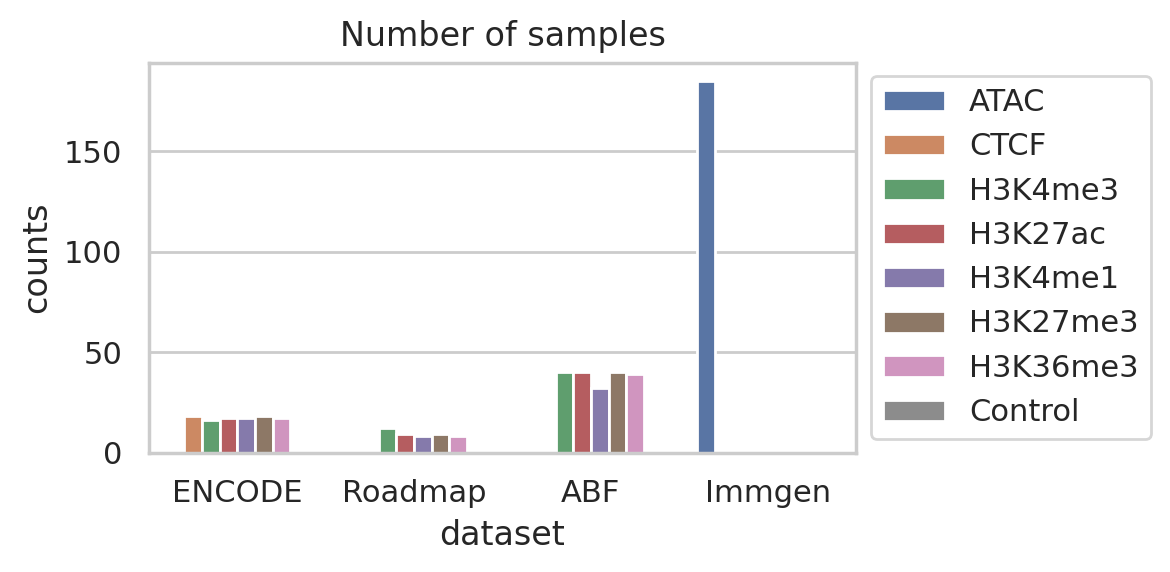

In [103]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_counts, hue='modification', x='dataset', y='counts',
            order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
            hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
            ax=ax)
ax.set_title('Number of samples')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

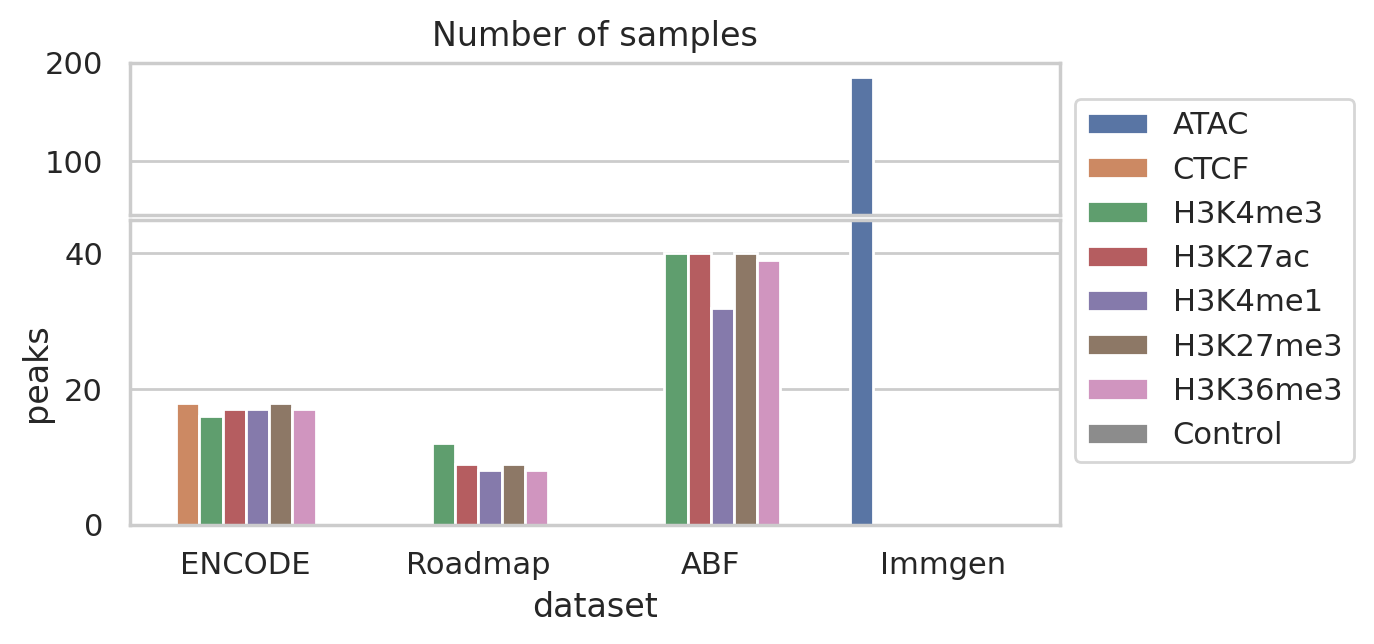

In [104]:
# Set up the matplotlib figure with broken y-axis
f, (axt, ax) = plt.subplots(2, 1, sharex=True, figsize=(6, 3),
                            gridspec_kw={'height_ratios': [1, 2]})
for axes in [ax, axt]:
    sns.barplot(data=df_counts, hue='modification', x='dataset', y='counts',
            order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
            hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
            ax=axes)
ax.set_ylim(bottom=0, top=45)
axt.set_ylim(bottom=45, top=200)
axt.set_xlabel(None)
axt.set_ylabel(None)
axt.title.set_text('Number of samples')
ax.set_ylabel('peaks')
axt.legend().set_visible(False)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.02)  # Adjust hspace closer to zero to remove spacing
plt.show()

In [105]:
df_replicates_counts = df_bams_all[df_bams_all['modification'] != 'Control'].groupby(
    ['dataset', 'modification', 'cell']).size().reset_index(name='replicates')
df_replicates_counts

dataset modification      cell  replicates
0       ABF      H3K27ac        OD          20
1       ABF      H3K27ac        YD          20
2       ABF     H3K27me3        OD          20
3       ABF     H3K27me3        YD          20
4       ABF     H3K36me3        OD          20
..      ...          ...       ...         ...
85  Roadmap      H3K4me3  Monocyte           1
86  Roadmap      H3K4me3        NK           1
87  Roadmap      H3K4me3      PBMC           1
88  Roadmap      H3K4me3     TCell           1
89  Roadmap      H3K4me3   TCellBB           2

[90 rows x 4 columns]

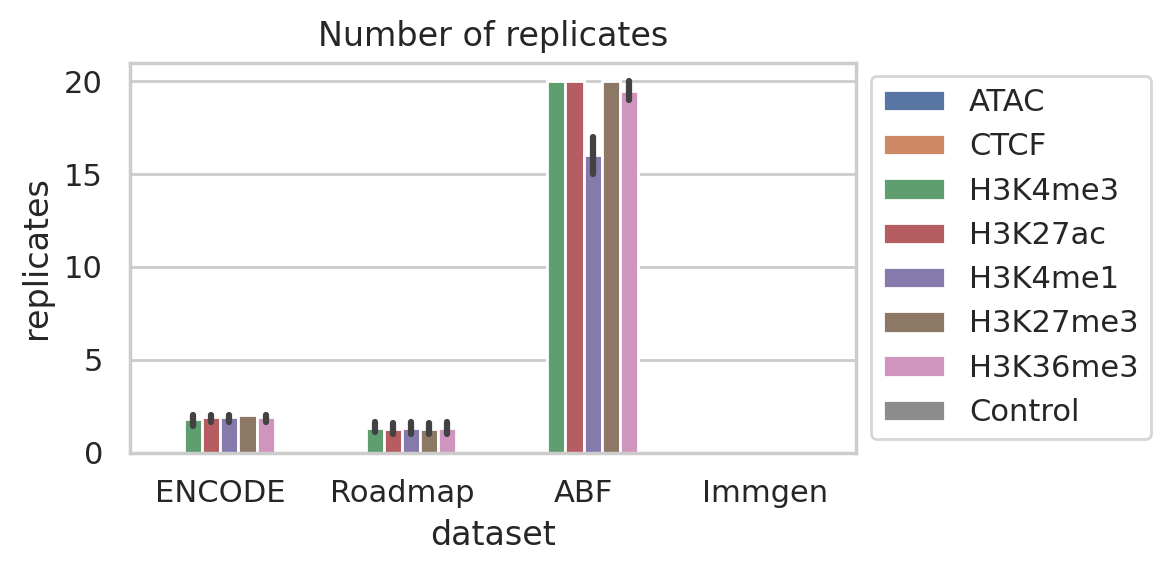

In [106]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_replicates_counts, hue='modification', x='dataset', y='replicates',
            order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
            hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
            ax=ax)
ax.set_title('Number of replicates')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

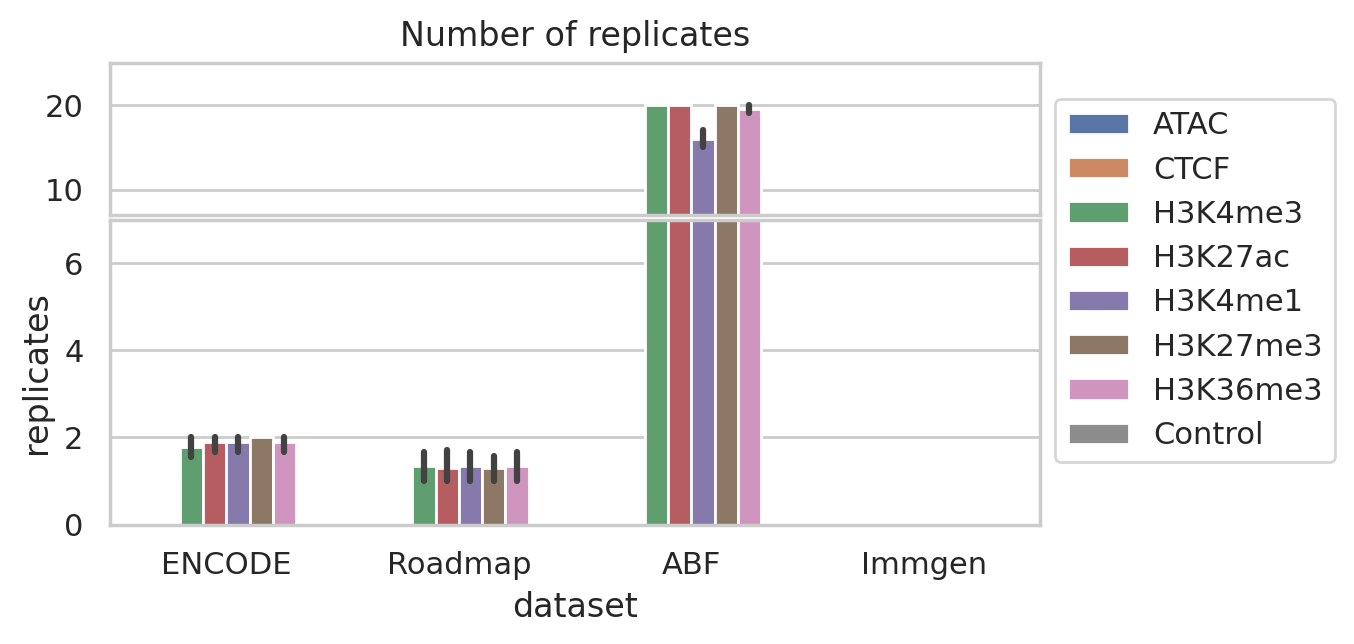

In [107]:
# Set up the matplotlib figure with broken y-axis
f, (axt, ax) = plt.subplots(2, 1, sharex=True, figsize=(6, 3),
                            gridspec_kw={'height_ratios': [1, 2]})
for axes in [ax, axt]:
    sns.barplot(data=df_replicates_counts, hue='modification', x='dataset', y='replicates',
                order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
                hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
                ax=axes)
ax.set_ylim(bottom=0, top=7)
axt.set_ylim(bottom=7, top=25)
axt.set_xlabel(None)
axt.set_ylabel(None)
axt.title.set_text('Number of replicates')
ax.set_ylabel('replicates')
axt.legend().set_visible(False)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.02)  # Adjust hspace closer to zero to remove spacing
plt.show()

# Reads vs peaks

In [43]:
df_peaks_lens = pd.merge(df_peaks[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
                         df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
                         on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_peaks_lens = pd.merge(df_peaks_lens,
                         df_lens_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']],
                         on=['dataset', 'modification', 'cell', 'replicate', 'tool'], how='inner')
df_peaks_lens.sample(3)

dataset modification  cell replicate         tool   peaks     reads  \
484  Roadmap      H3K4me3  CD34      rep2         SPAN   19154  13539143   
176   ENCODE      H3K27ac  K562      rep2        SICER   26159   6180094   
396  Roadmap      H3K4me1  CD34            MACS2 broad  140715  17619839   

          length    footprint  
484   904.477500   19271320.0  
176  2544.625000   78015441.0  
396   996.195625  177299718.0



peaks vs length


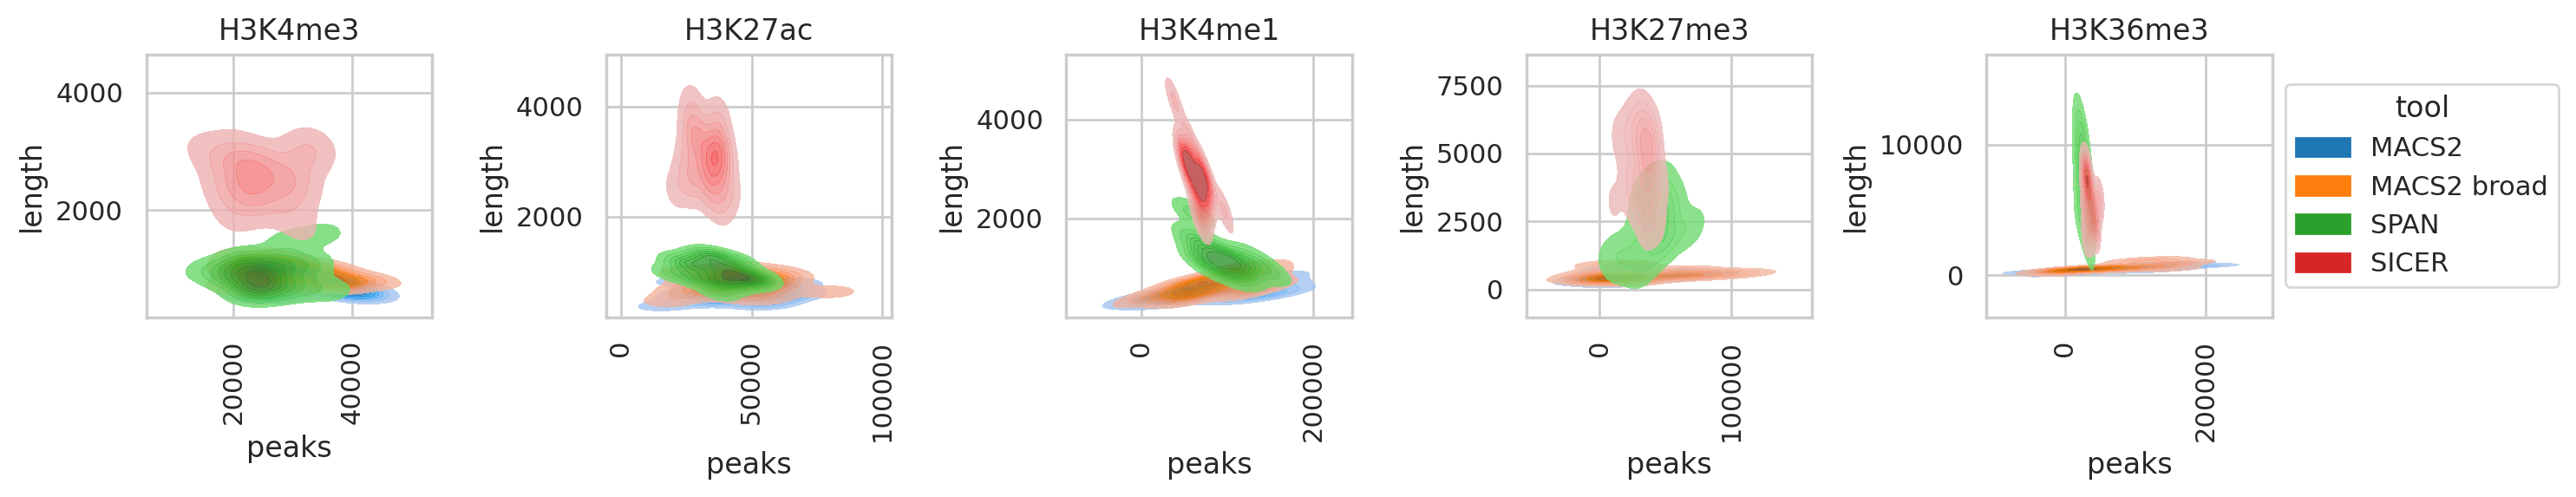



peaks vs reads


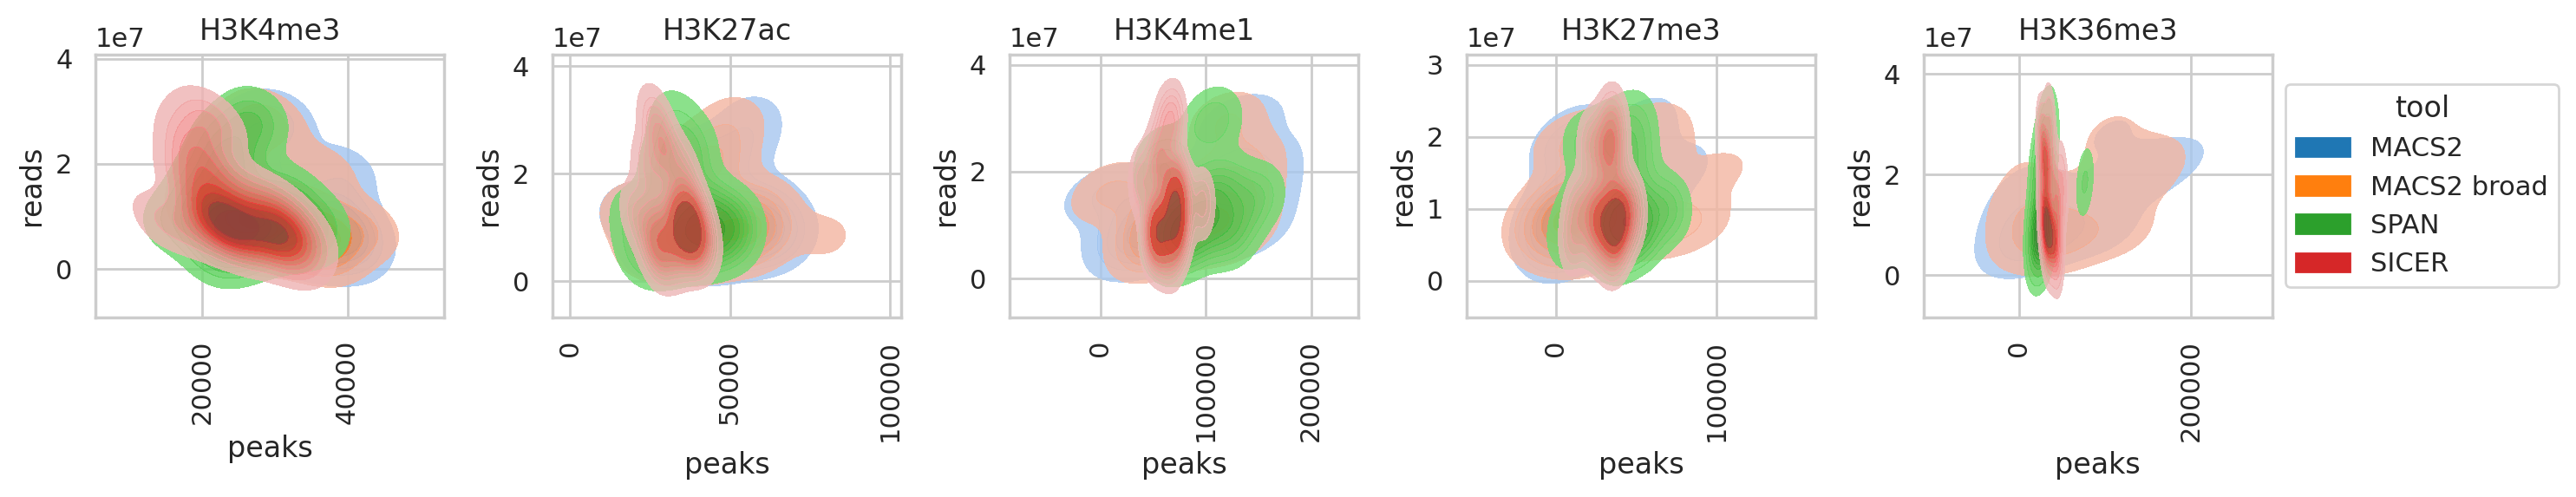

In [52]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
        ax = axs[i]
        sns.kdeplot(
            df_peaks_lens[df_peaks_lens['modification'] == m], x=x, y=y, hue='tool',
            alpha=0.8,
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            thresh=0.05,
            fill=True,
            legend=i == len(axs) - 1,
            ax=ax)
        ax.title.set_text(m)
        if i == len(axs) - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        if x != 'reads':
            ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

# Difference

In [45]:
def compute_diffs(diff_path, df):
    tools = df['tool'].unique()
    rows = []
    for (m, c, r), tmcr in tqdm(list(df.groupby(['modification', 'cell', 'replicate']))):
        print(m, c, r)
        t = tmcr[tmcr['tool'] == 'Omnipeak']
        if len(t) == 0:
            continue
        omnipeak_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'Omnipeak':
                continue
            t = tmcr[tmcr['tool'] == tool]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'Omnipeak - {tool}', f' -a {omnipeak_file} -b {peaks_file} '),
                (f'{tool} - Omnipeak', f' -b {omnipeak_file} -a {peaks_file} ')]:
                diff_file = f'{diff_path}/{name.replace(" ", "_")}_{m}_{c}_{r}.bed'
                ! bedtools intersect {args} -wa -v > {diff_file}
                peaks = lines(diff_file)
                rows.append((m, c, r, name, peaks))
    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

In [46]:
def plot_diff(df_peaks, df_diff):
    t = df_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
    t.rename({'tool': 'name'}, axis=1, inplace=True)
    t = pd.concat([t, df_diff]).reset_index(drop=True)
    t = t.loc[
        [(m, c, r) not in OUTLIERS for _, (m, c, r) in t[['modification', 'cell', 'replicate']].iterrows()]].copy()

    plt.figure(figsize=(18, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tm = t[t['modification'] == m]
        print(m, len(t))
        ax.set_title(m)
        sns.barplot(data=tm, x='name', y='peaks',
                    color='grey',
                    capsize=.2, err_kws={'linewidth': 2},
                    order=['MACS2', 'MACS2 broad', 'Omnipeak', 'SICER',
                           'Omnipeak - MACS2', 'Omnipeak - MACS2 broad', 'Omnipeak - SICER',
                           'MACS2 - Omnipeak', 'MACS2 broad - Omnipeak', 'SICER - Omnipeak',
                           ],
                    ax=ax)
        sns.stripplot(data=tm, x='name', y='peaks',
                      size=2, alpha=0.8, color='black',
                      order=['MACS2', 'MACS2 broad', 'Omnipeak', 'SICER',
                             'Omnipeak - MACS2', 'Omnipeak - MACS2 broad', 'Omnipeak - SICER',
                             'MACS2 - Omnipeak', 'MACS2 broad - Omnipeak', 'SICER - Omnipeak',
                             ],
                      legend=False,
                      ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel('Peaks number')
    plt.tight_layout()
    plt.show()

## ENCODE

In [53]:
dp = f'{GSE26320_PATH}/diff'
! mkdir -p {dp}
df_encode_diff = compute_diffs(dp, df_encode_peaks)
df_encode_diff.sample(5)

  0%|          | 0/85 [00:00<?, ?it/s]

H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac H1 rep1
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27me3 GM12878 rep1
H3K27me3 GM12878 rep2
H3K27me3 H1 rep1
H3K27me3 H1 rep2
H3K27me3 HMEC rep1
H3K27me3 HMEC rep2
H3K27me3 HSMM rep1
H3K27me3 HSMM rep2
H3K27me3 HepG2 rep1
H3K27me3 HepG2 rep2
H3K27me3 Huvec rep1
H3K27me3 Huvec rep2
H3K27me3 K562 rep1
H3K27me3 K562 rep2
H3K27me3 NHEK rep1
H3K27me3 NHEK rep2
H3K27me3 NHLF rep1
H3K27me3 NHLF rep2
H3K36me3 GM12878 rep1
H3K36me3 GM12878 rep2
H3K36me3 H1 rep1
H3K36me3 H1 rep2
H3K36me3 HMEC rep1
H3K36me3 HMEC rep2
H3K36me3 HSMM rep1
H3K36me3 HSMM rep2
H3K36me3 HepG2 rep1
H3K36me3 HepG2 rep2
H3K36me3 Huvec rep1
H3K36me3 Huvec rep2
H3K36me3 K562 rep1
H3K36me3 K562 rep2
H3K36me3 NHEK rep2
H3K36me3 NHLF rep1
H3K36me3 NHLF rep2
H3K4me1 G

modification   cell replicate                name  peaks
484      H3K4me3   K562      rep1        SPAN - SICER   2349
208     H3K27me3   NHLF      rep2        SPAN - SICER  15254
343      H3K4me1   HMEC      rep2        MACS2 - SPAN     40
51       H3K27ac  HepG2      rep2  MACS2 broad - SPAN    165
284     H3K36me3   K562      rep1  SPAN - MACS2 broad  15854

H3K4me3 850
H3K27ac 850
H3K4me1 850
H3K27me3 850
H3K36me3 850


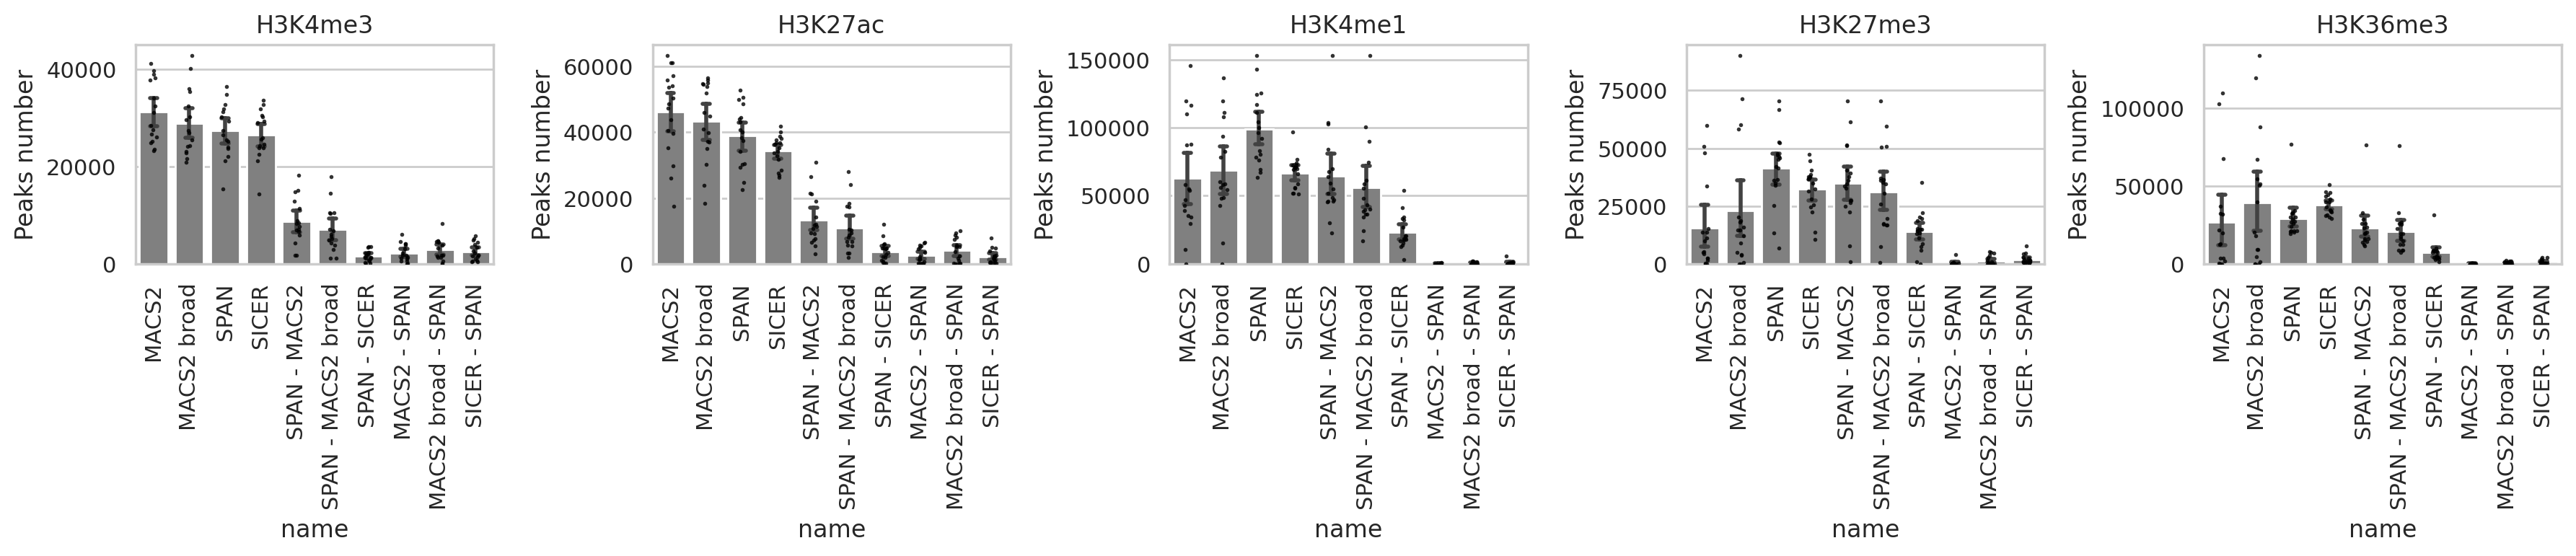

In [54]:
plot_diff(df_encode_peaks, df_encode_diff)

## Roadmap

In [55]:
dp = f'{IMMUNE_PATH}/diff'
! mkdir -p {dp}
df_immune_diff = compute_diffs(dp, df_immune_peaks)
df_immune_diff.sample(5)

  0%|          | 0/46 [00:00<?, ?it/s]

H3K27ac BCell 
H3K27ac CD34 
H3K27ac CD34 rep2
H3K27ac CD4 
H3K27ac CD4 rep1
H3K27ac Monocyte 
H3K27ac NK 
H3K27ac PBMC 
H3K27ac TCell 
H3K27me3 BCell 
H3K27me3 CD34 
H3K27me3 CD34 rep2
H3K27me3 CD4 
H3K27me3 CD4 rep2
H3K27me3 Monocyte 
H3K27me3 NK 
H3K27me3 PBMC 
H3K27me3 TCell 
H3K36me3 BCell 
H3K36me3 CD34 
H3K36me3 CD34 rep1
H3K36me3 CD4 
H3K36me3 CD4 rep1
H3K36me3 Monocyte 
H3K36me3 PBMC 
H3K36me3 TCell 
H3K4me1 BCell 
H3K4me1 CD34 
H3K4me1 CD34 rep2
H3K4me1 CD4 
H3K4me1 CD4 rep1
H3K4me1 Monocyte 
H3K4me1 NK 
H3K4me1 TCell 
H3K4me3 BCell 
H3K4me3 CD34 
H3K4me3 CD34 rep2
H3K4me3 CD4 
H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 Monocyte 
H3K4me3 NK 
H3K4me3 PBMC 
H3K4me3 TCell 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2


modification      cell replicate                name  peaks
16       H3K27ac      CD34      rep2        SPAN - SICER    332
183      H3K4me1       CD4      rep1  MACS2 broad - SPAN    931
35       H3K27ac  Monocyte                  SICER - SPAN   3421
73      H3K27me3       CD4                  MACS2 - SPAN      9
126     H3K36me3       CD4                  SPAN - MACS2  12150

H3K4me3 400
H3K27ac 400
H3K4me1 400
H3K27me3 400
H3K36me3 400


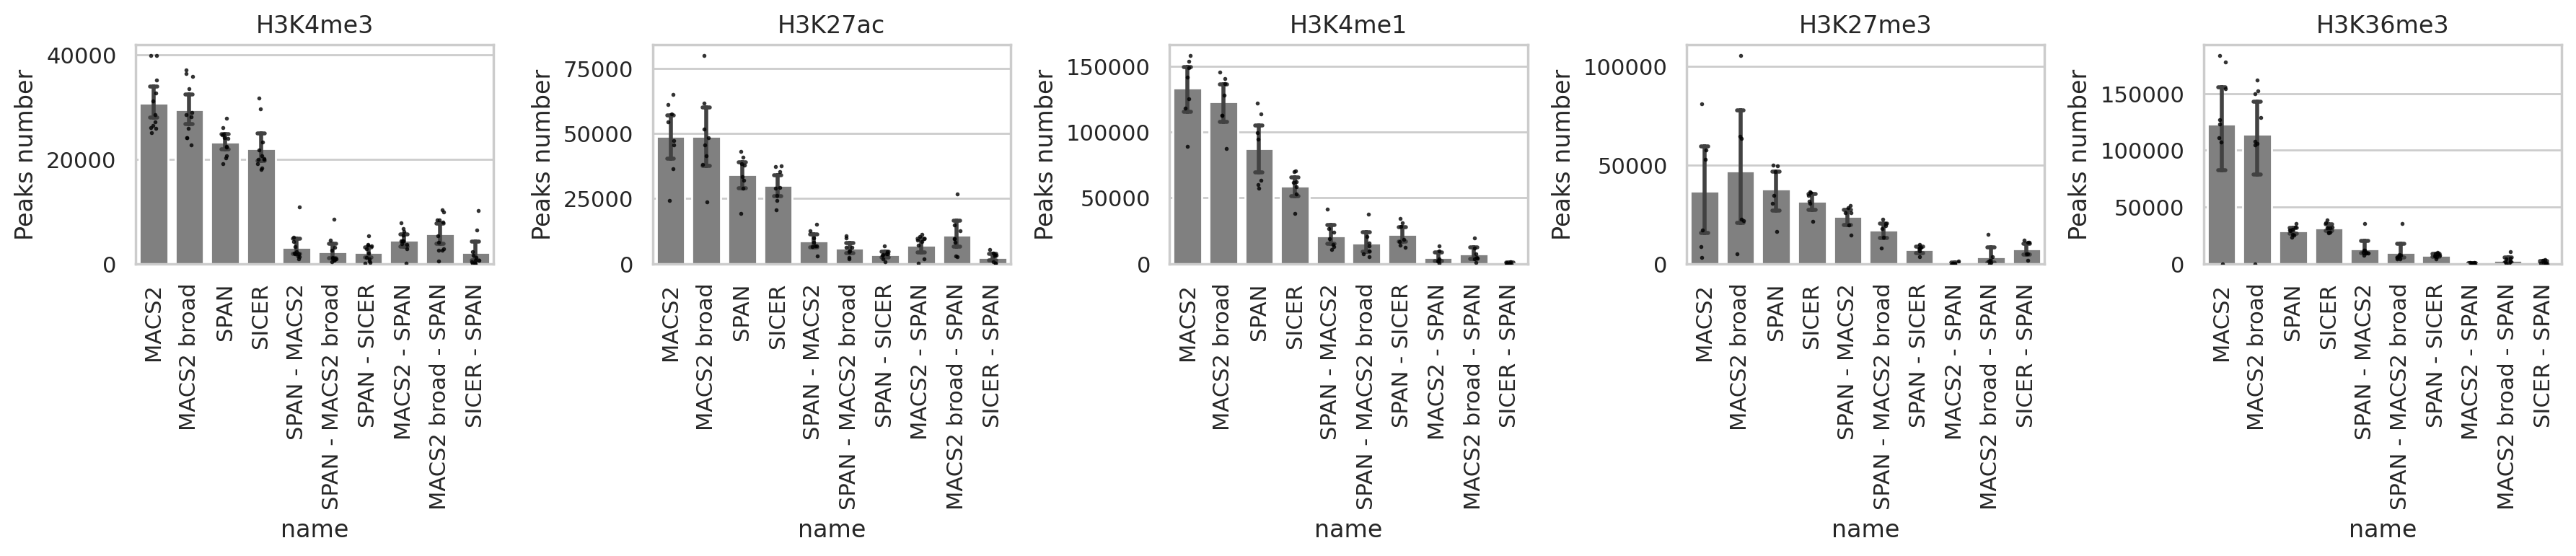

In [56]:
plot_diff(df_immune_peaks, df_immune_diff)

In [57]:
df_immune_diff[(df_immune_diff['modification'] == 'H3K27ac') &
               (df_immune_diff['name'] == 'MACS2 - Omnipeak')].sort_values(by=['peaks'], ascending=False).head(10)

modification      cell replicate          name  peaks
49      H3K27ac     TCell            MACS2 - SPAN  11168
19      H3K27ac       CD4            MACS2 - SPAN  10441
37      H3K27ac        NK            MACS2 - SPAN   9690
1       H3K27ac     BCell            MACS2 - SPAN   8936
31      H3K27ac  Monocyte            MACS2 - SPAN   8562
7       H3K27ac      CD34            MACS2 - SPAN   7219
13      H3K27ac      CD34      rep2  MACS2 - SPAN   3939
25      H3K27ac       CD4      rep1  MACS2 - SPAN   1824
43      H3K27ac      PBMC            MACS2 - SPAN    140

## ABF

In [58]:
dp = f'{ABF_PATH}/diff'
! mkdir -p {dp}

df_abf_diff = compute_diffs(dp, df_abf_peaks)
df_abf_diff.sample(5)

  0%|          | 0/165 [00:00<?, ?it/s]

H3K27ac OD OD1
H3K27ac OD OD10
H3K27ac OD OD11
H3K27ac OD OD12
H3K27ac OD OD13
H3K27ac OD OD14
H3K27ac OD OD15
H3K27ac OD OD16
H3K27ac OD OD17
H3K27ac OD OD18
H3K27ac OD OD19
H3K27ac OD OD2
H3K27ac OD OD20
H3K27ac OD OD3
H3K27ac OD OD4
H3K27ac OD OD5
H3K27ac OD OD6
H3K27ac OD OD7
H3K27ac OD OD8
H3K27ac OD OD9
H3K27ac YD YD10
H3K27ac YD YD11
H3K27ac YD YD12
H3K27ac YD YD14
H3K27ac YD YD15
H3K27ac YD YD16
H3K27ac YD YD17
H3K27ac YD YD18
H3K27ac YD YD19
H3K27ac YD YD2
H3K27ac YD YD20
H3K27ac YD YD21
H3K27ac YD YD3
H3K27ac YD YD4
H3K27ac YD YD5
H3K27ac YD YD7
H3K27ac YD YD8
H3K27ac YD YD9
H3K27me3 OD OD1
H3K27me3 OD OD10
H3K27me3 OD OD11
H3K27me3 OD OD12
H3K27me3 OD OD13
H3K27me3 OD OD14
H3K27me3 OD OD15
H3K27me3 OD OD16
H3K27me3 OD OD17
H3K27me3 OD OD18
H3K27me3 OD OD19
H3K27me3 OD OD2
H3K27me3 OD OD20
H3K27me3 OD OD3
H3K27me3 OD OD4
H3K27me3 OD OD5
H3K27me3 OD OD6
H3K27me3 OD OD7
H3K27me3 OD OD8
H3K27me3 YD YD12
H3K27me3 YD YD14
H3K27me3 YD YD15
H3K27me3 YD YD16
H3K27me3 YD YD17
H3K27me3

modification cell replicate          name  peaks
960      H3K4me3   YD       YD5  SPAN - MACS2  36402
425     H3K36me3   OD       OD1  SICER - SPAN   7734
406     H3K27me3   YD       YD6  SPAN - SICER   8289
856      H3K4me3   OD       OD2  SPAN - SICER   6773
773      H3K4me1   YD       YD6  SICER - SPAN    665

H3K4me3 1650
H3K27ac 1650
H3K4me1 1650
H3K27me3 1650
H3K36me3 1650


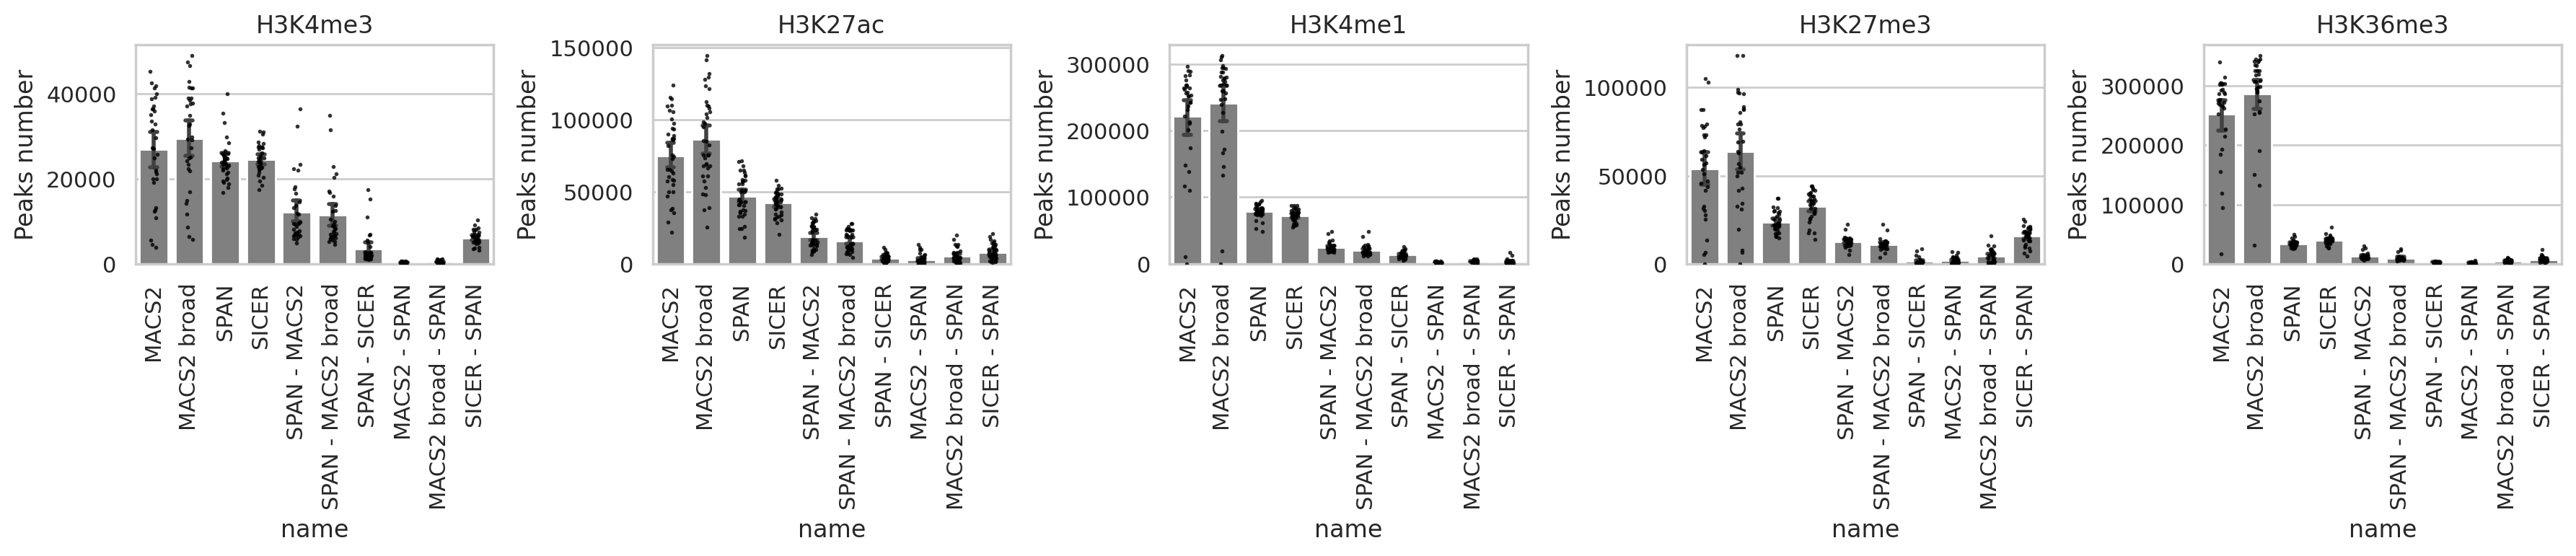

In [59]:
plot_diff(df_abf_peaks, df_abf_diff)


# Jaccard & Overlap

In [109]:
import pyranges as pr
import tempfile


def compute_reps_overlap(df_peaks):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                         'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                         'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    for (m, c, tool), tm in tqdm(df_peaks.groupby(['modification', 'cell', 'tool'])):
        reps = list(sorted(set(tm['replicate'])))
        print(m, c, tool, len(reps))
        files = [None] * len(reps)
        peaks = [-1] * len(reps)
        peaks_lens = [-1] * len(reps)
        # print('Load')
        for i in range(len(reps)):
            t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == reps[i])]
            if len(t1) == 0:
                continue
            file = t1['file'].values[0]
            peaks[i] = lines(file)
            if peaks[i] == 0:
                peaks_lens[i] = 0
                continue
            files[i] = pr.read_bed(sorted_file(file))
            peaks_lens[i] = files[i].lengths().sum()
            # print('Intersect')
        for i, j in product(range(len(reps)), range(len(reps))):
            if i >= j:
                continue
            rep1, rep2 = reps[i], reps[j]
            file1, file2 = files[i], files[j]
            peaks1, peaks2 = peaks[i], peaks[j]
            peaks1_len, peaks2_len = peaks_lens[i], peaks_lens[j]
            if peaks1 <= 0 or peaks2 <= 0:
                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     0, 0, 0)
                continue
            overlap1 = len(file1.overlap(file2))
            overlap2 = len(file2.overlap(file1))
            overlap_len = file1.intersect(file2).lengths().sum()
            # assert file2.intersect(file1).lengths().sum() == overlap_len
            reps_overlap.loc[len(reps_overlap)] = \
                (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                 overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]
    return reps_overlap

## Jaccard ENCODE 

In [110]:
t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
df_encode_reps = compute_reps_overlap(t)
df_encode_reps.sample(5)

  0%|          | 0/360 [00:00<?, ?it/s]

H3K27ac GM12878 HOMER 2
H3K27ac GM12878 Hotspot 2
H3K27ac GM12878 LanceOtron 2
H3K27ac GM12878 MACS2 2
H3K27ac GM12878 MACS2 broad 2
H3K27ac GM12878 Omnipeak 2
H3K27ac GM12878 Peakseq 2
H3K27ac GM12878 SICER 2
H3K27ac H1 HOMER 1
H3K27ac H1 Hotspot 1
H3K27ac H1 LanceOtron 1
H3K27ac H1 MACS2 1
H3K27ac H1 MACS2 broad 1
H3K27ac H1 Omnipeak 1
H3K27ac H1 Peakseq 1
H3K27ac H1 SICER 1
H3K27ac HMEC HOMER 2
H3K27ac HMEC Hotspot 2
H3K27ac HMEC LanceOtron 2
H3K27ac HMEC MACS2 2
H3K27ac HMEC MACS2 broad 2
H3K27ac HMEC Omnipeak 2
H3K27ac HMEC Peakseq 2
H3K27ac HMEC SICER 2
H3K27ac HSMM HOMER 2
H3K27ac HSMM Hotspot 2
H3K27ac HSMM LanceOtron 2
H3K27ac HSMM MACS2 2
H3K27ac HSMM MACS2 broad 2
H3K27ac HSMM Omnipeak 2
H3K27ac HSMM Peakseq 2
H3K27ac HSMM SICER 2
H3K27ac HepG2 HOMER 2
H3K27ac HepG2 Hotspot 2
H3K27ac HepG2 LanceOtron 2
H3K27ac HepG2 MACS2 2
H3K27ac HepG2 MACS2 broad 2
H3K27ac HepG2 Omnipeak 2
H3K27ac HepG2 Peakseq 2
H3K27ac HepG2 SICER 2
H3K27ac Huvec HOMER 2
H3K27ac Huvec Hotspot 2
H3K27ac 

modification     cell         tool  rep1  rep2  peaks1  peaks1_len  \
284      H3K4me3     HMEC  MACS2 broad  rep1  rep2   21521    23633405   
280      H3K4me3     HMEC        HOMER  rep1  rep2   17924    35840532   
66      H3K27me3  GM12878   LanceOtron  rep1  rep2  292471    99468851   
305      H3K4me3     K562      Hotspot  rep1  rep2  165341    95217325   
105     H3K27me3    Huvec      Hotspot  rep1  rep2  265053   148888058   

     peaks2  peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len  \
284   23053    22363183           16345           18980           17053996   
280   17184    30857284           13381           14270           26119735   
66   387505   124470923           90831           90518           22936950   
305  128880    77795450           88727           85024           58862197   
105  332203   186423646          144968          148028           71427682   

      jaccard  
284  0.589235  
280  0.643691  
66   0.114113  
305  0.515654  
105  0.270678

ENCODE


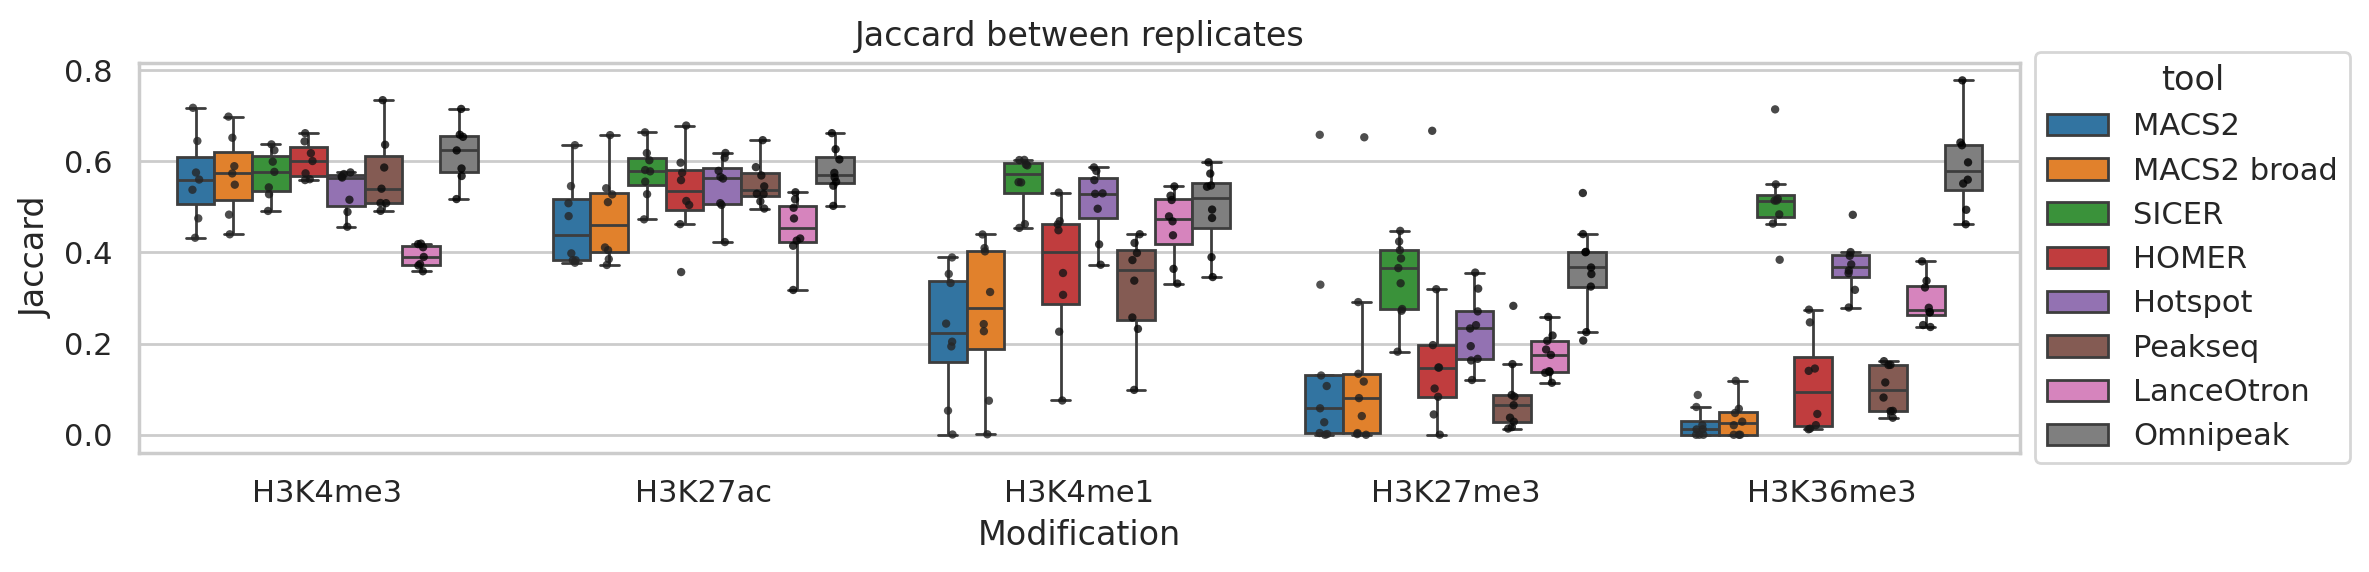

In [111]:
print('ENCODE')
plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=TOOLS,
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


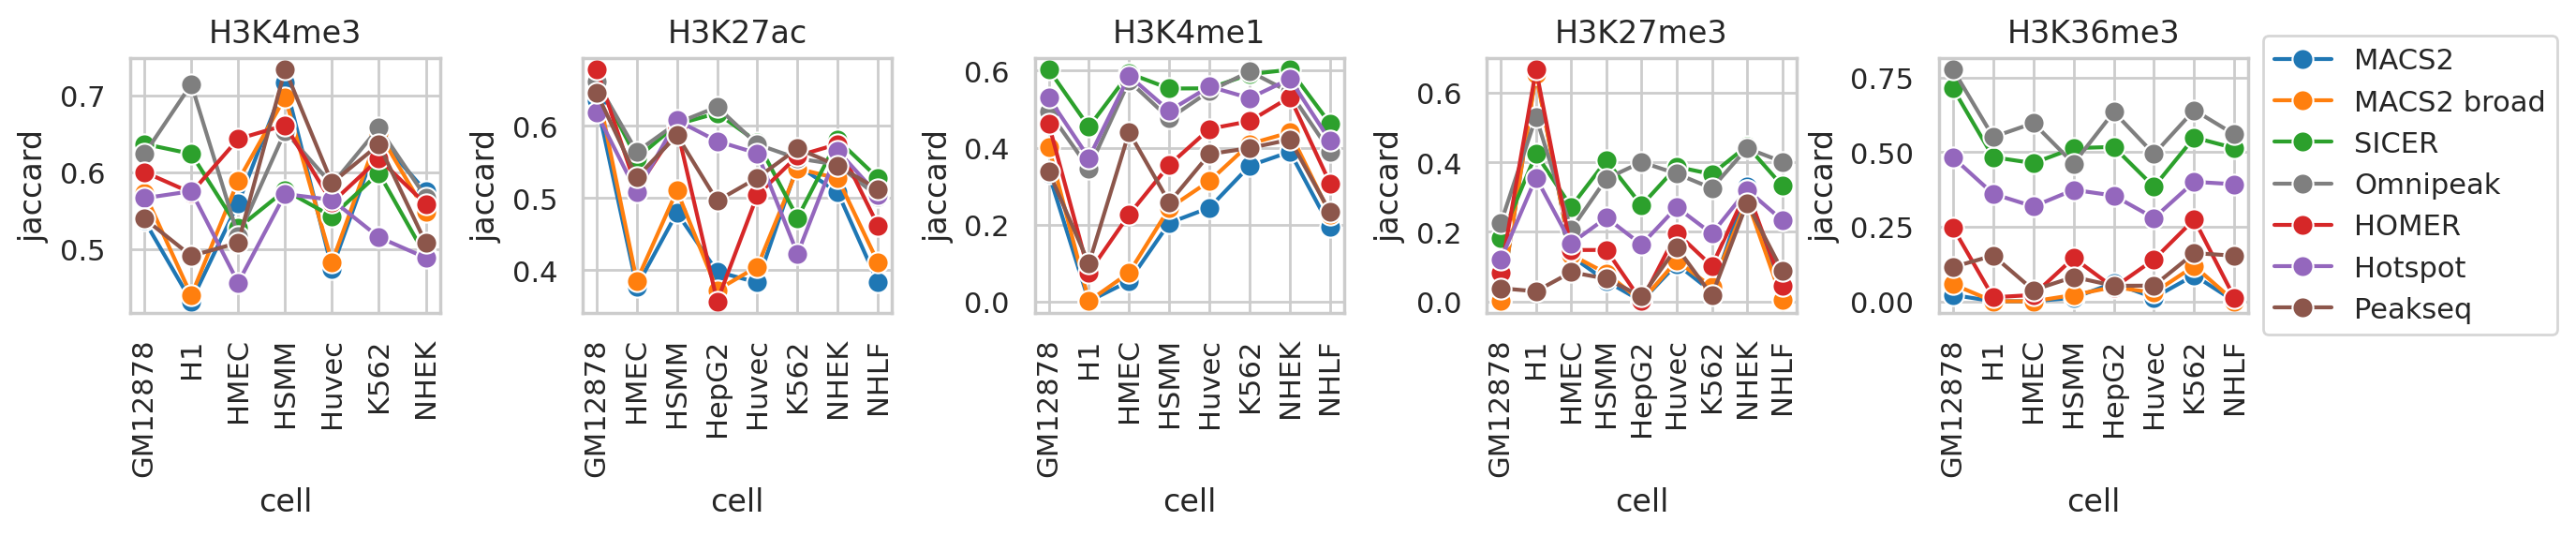

In [112]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'Omnipeak', 'HOMER', 'Hotspot', 'Peakseq'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

ENCODE


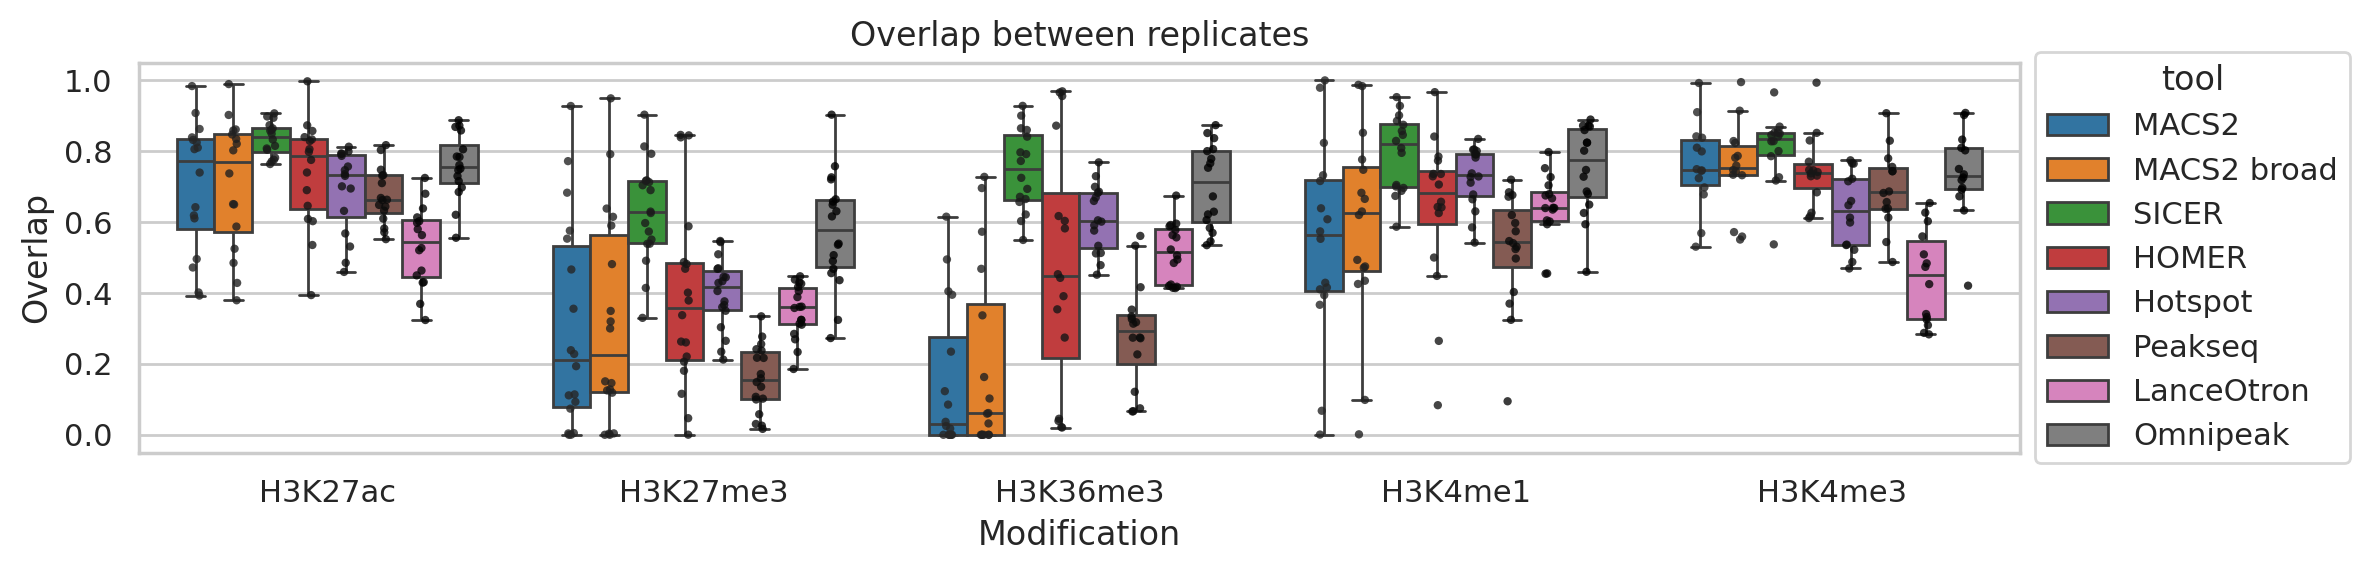

In [113]:
t = pd.concat([df_encode_reps[['modification', 'cell', 'tool']],
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t['overlap'] = overlaps
print('ENCODE')
plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            showfliers=False
            )
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=TOOLS,
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE
H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


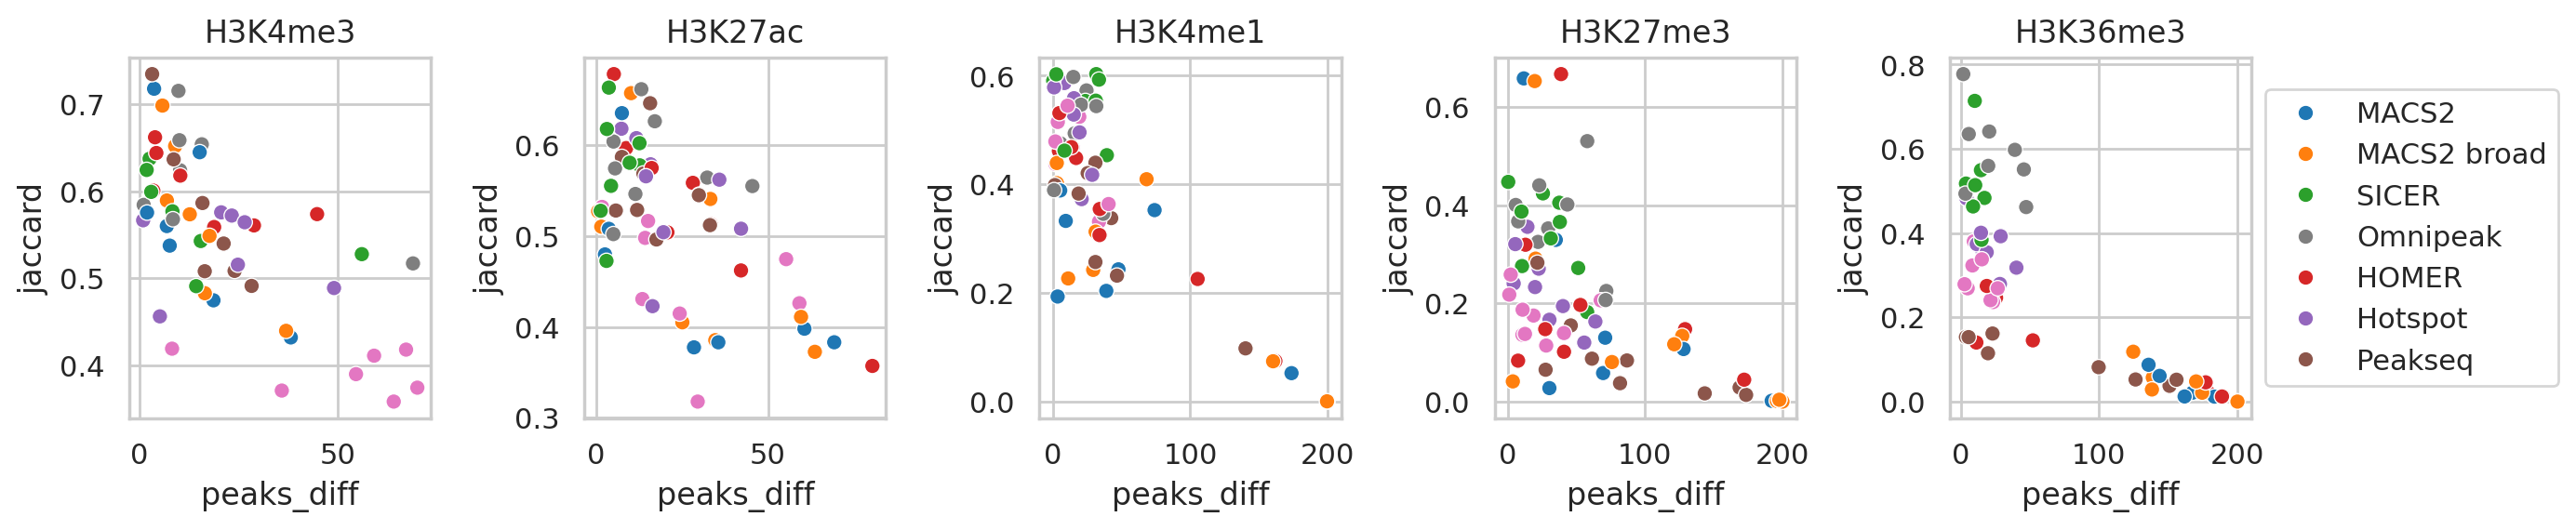

In [114]:
print('ENCODE')
df_encode_reps['peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                       (df_encode_reps['peaks1'] + df_encode_reps['peaks2']) * 200)
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'Omnipeak', 'HOMER', 'Hotspot', 'Peakseq'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

ENCODE


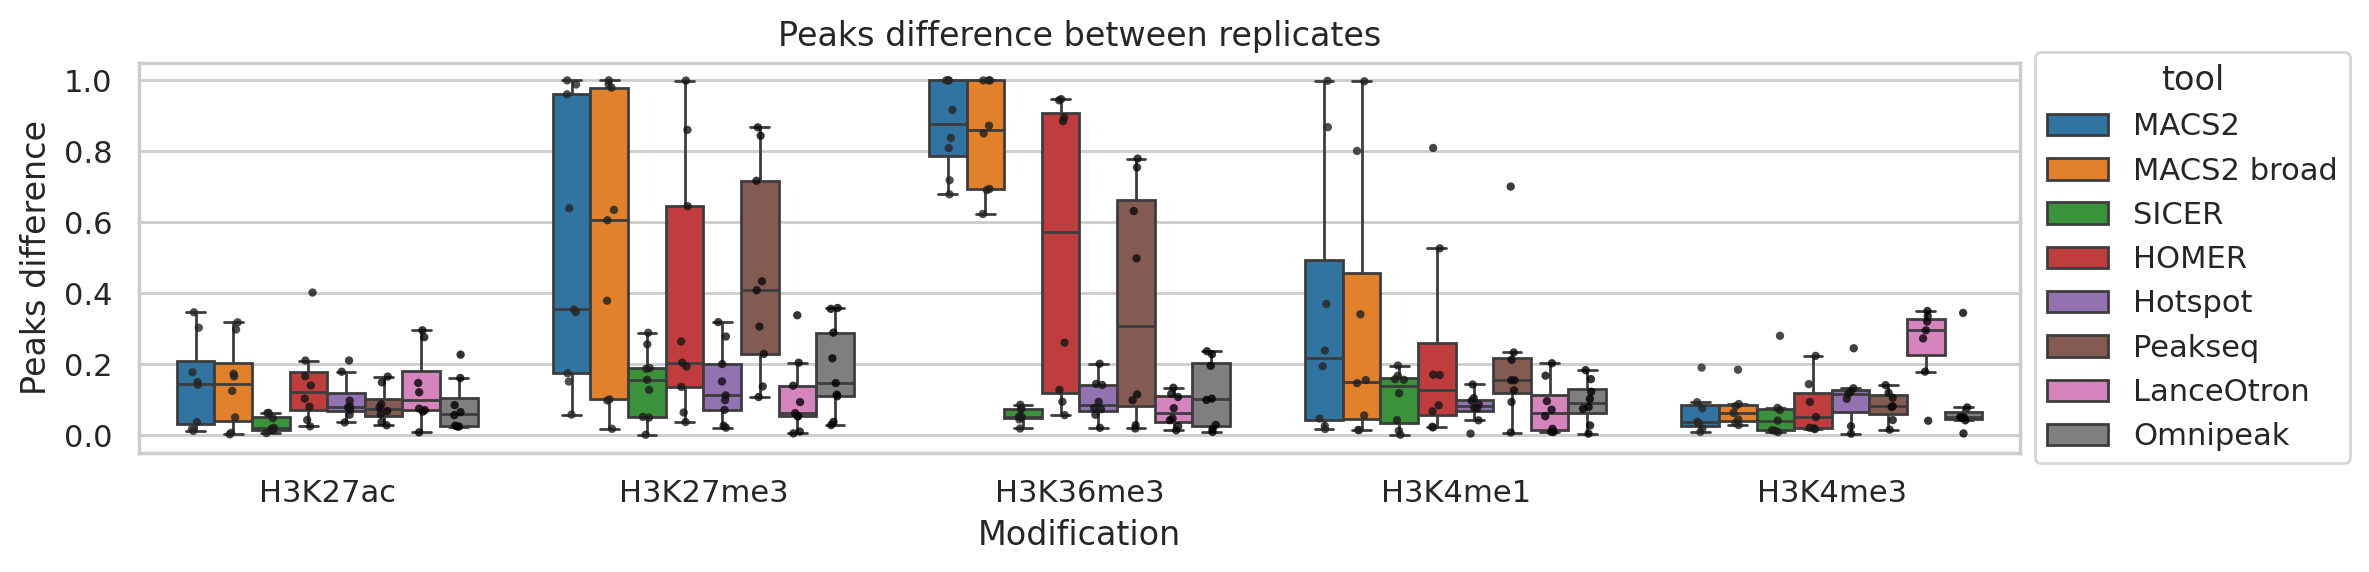

In [115]:
print('ENCODE')
df_encode_reps['reps_peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                            (df_encode_reps['peaks1'] + df_encode_reps['peaks2']))

plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [116]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_encode_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_encode = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

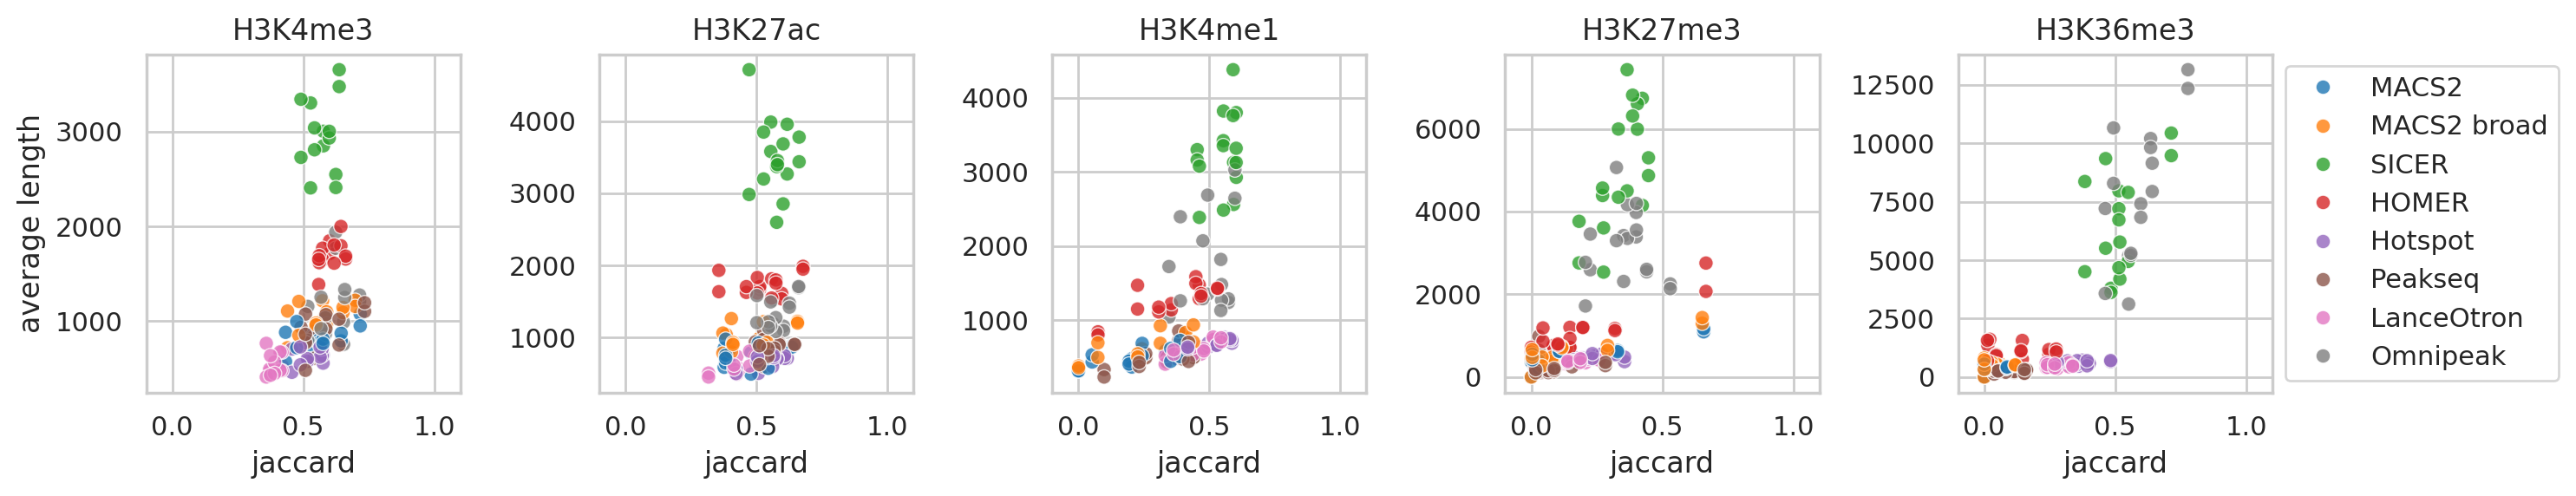

In [117]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


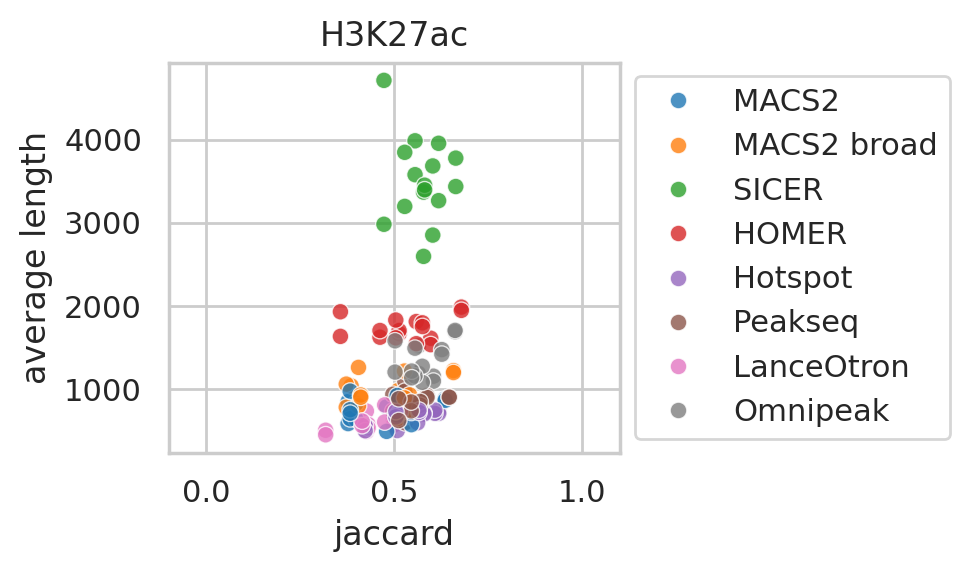

H3K4me1


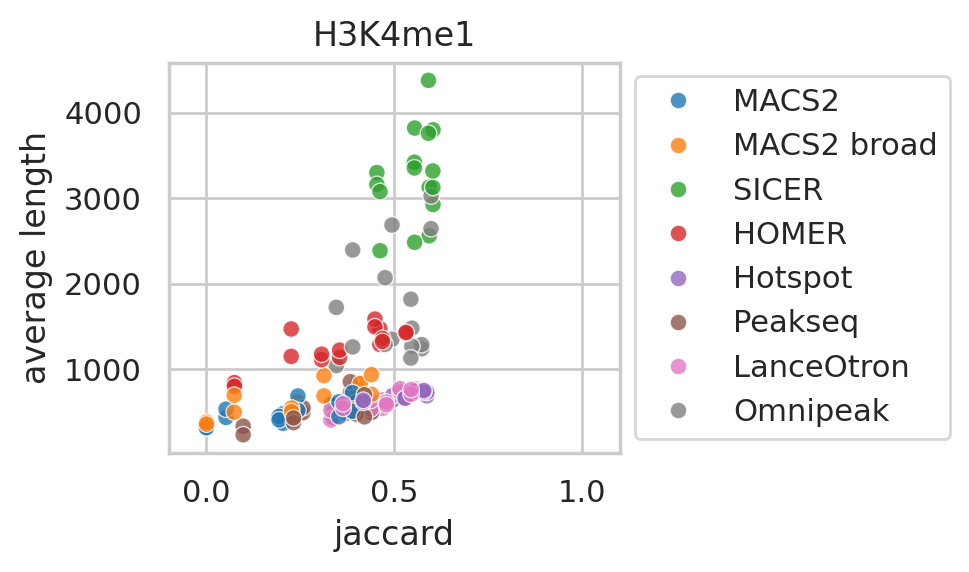

In [118]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    ax.set_ylabel('average length')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard Roadmap

In [120]:
t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_immune_peaks
df_immune_reps = compute_reps_overlap(t)
df_immune_reps.sample(5)

  0%|          | 0/240 [00:00<?, ?it/s]

H3K27ac BCell HOMER 1
H3K27ac BCell Hotspot 1
H3K27ac BCell LanceOtron 1
H3K27ac BCell MACS2 1
H3K27ac BCell MACS2 broad 1
H3K27ac BCell Omnipeak 1
H3K27ac BCell Peakseq 1
H3K27ac BCell SICER 1
H3K27ac CD34 HOMER 1
H3K27ac CD34 Hotspot 1
H3K27ac CD34 LanceOtron 1
H3K27ac CD34 MACS2 1
H3K27ac CD34 MACS2 broad 1
H3K27ac CD34 Omnipeak 1
H3K27ac CD34 Peakseq 1
H3K27ac CD34 SICER 1
H3K27ac CD4 HOMER 2
H3K27ac CD4 Hotspot 2
H3K27ac CD4 LanceOtron 2
H3K27ac CD4 MACS2 2
H3K27ac CD4 MACS2 broad 2
H3K27ac CD4 Omnipeak 2
H3K27ac CD4 Peakseq 2
H3K27ac CD4 SICER 2
H3K27ac Monocyte HOMER 1
H3K27ac Monocyte Hotspot 1
H3K27ac Monocyte LanceOtron 1
H3K27ac Monocyte MACS2 1
H3K27ac Monocyte MACS2 broad 1
H3K27ac Monocyte Omnipeak 1
H3K27ac Monocyte Peakseq 1
H3K27ac Monocyte SICER 1
H3K27ac NK HOMER 1
H3K27ac NK Hotspot 1
H3K27ac NK LanceOtron 1
H3K27ac NK MACS2 1
H3K27ac NK MACS2 broad 1
H3K27ac NK Omnipeak 1
H3K27ac NK Peakseq 1
H3K27ac NK SICER 1
H3K27ac PBMC HOMER 1
H3K27ac PBMC Hotspot 1
H3K27ac PB

modification     cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
12     H3K27me3     CD34  MACS2 broad        rep2   64451    45059059  105668   
36     H3K36me3      CD4  MACS2 broad        rep1  107518   101133367     120   
40      H3K4me1     CD34        HOMER        rep2   95813   187327055   87403   
79      H3K4me3  TCellBB        SICER  rep1  rep2   31721    59642679   29667   
22     H3K27me3      CD4      Peakseq        rep2    7647     1030049   15126   

    peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
12   105504627           50518           31482           37718976  0.334256  
36       13433              93             107              11160  0.000110  
40   153444511           74587           78849          137610542  0.677347  
79    67583133           24491           23646           45265661  0.552289  
22     1902485            1868            1805             311859  0.118999

Immune


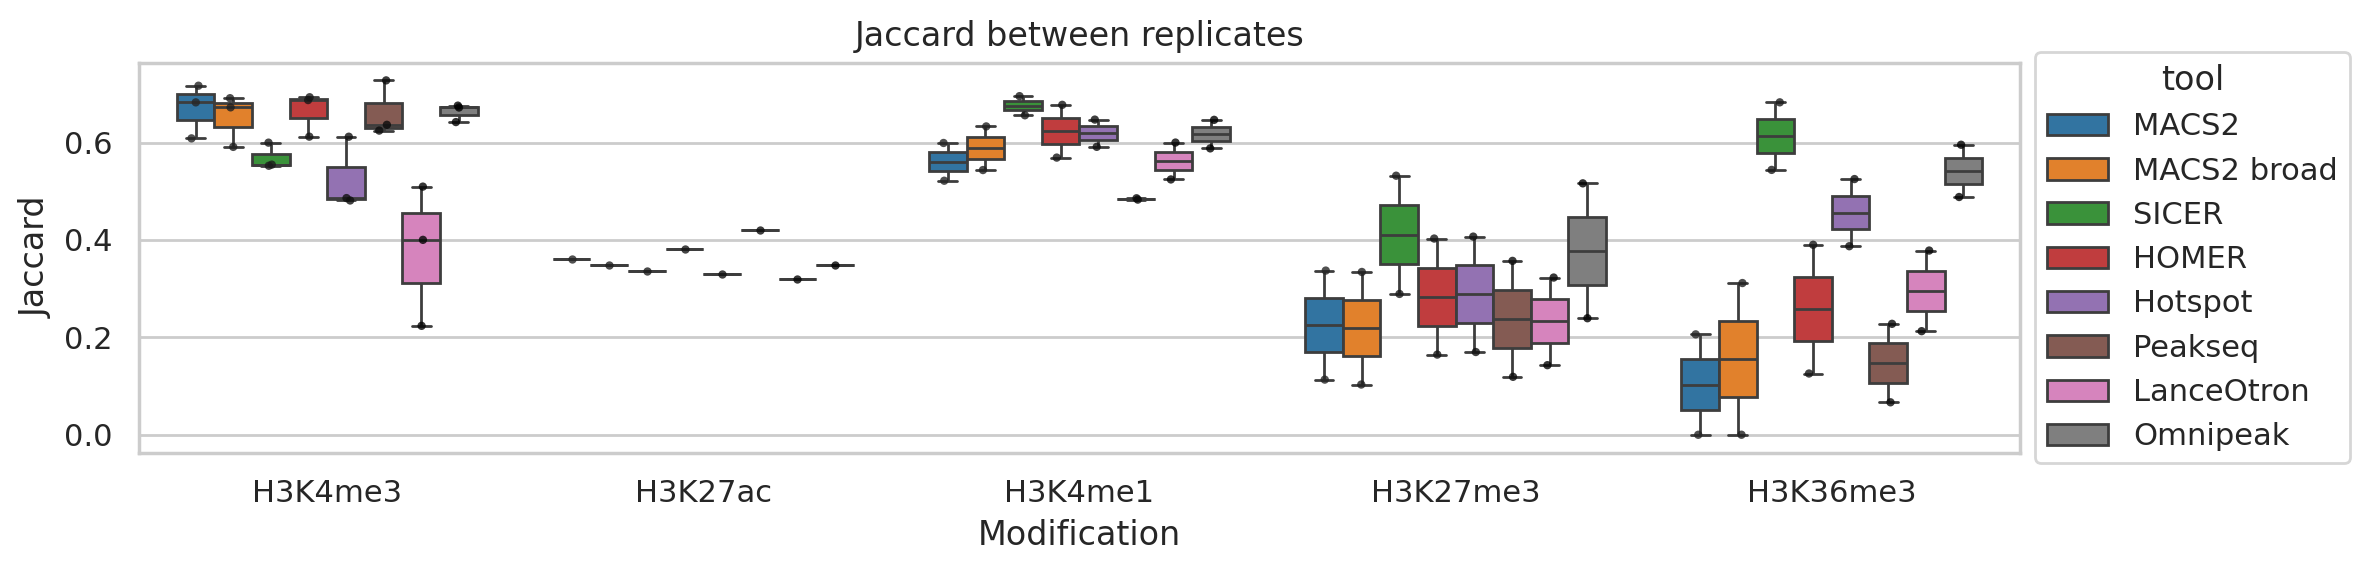

In [121]:
print('Immune')
plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


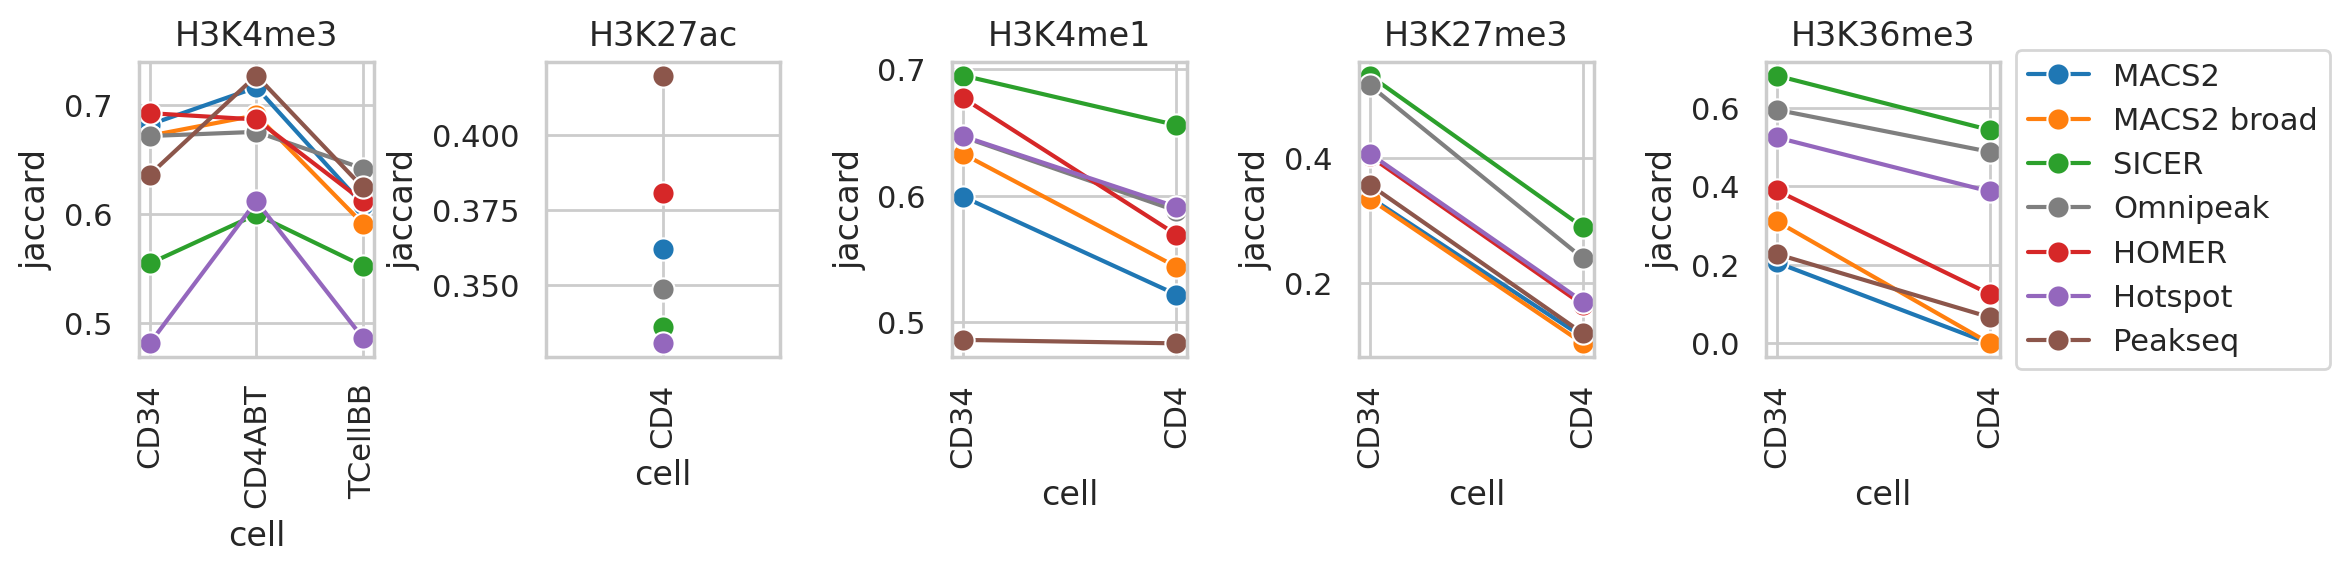

In [122]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'Omnipeak', 'HOMER', 'Hotspot', 'Peakseq'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

Immune


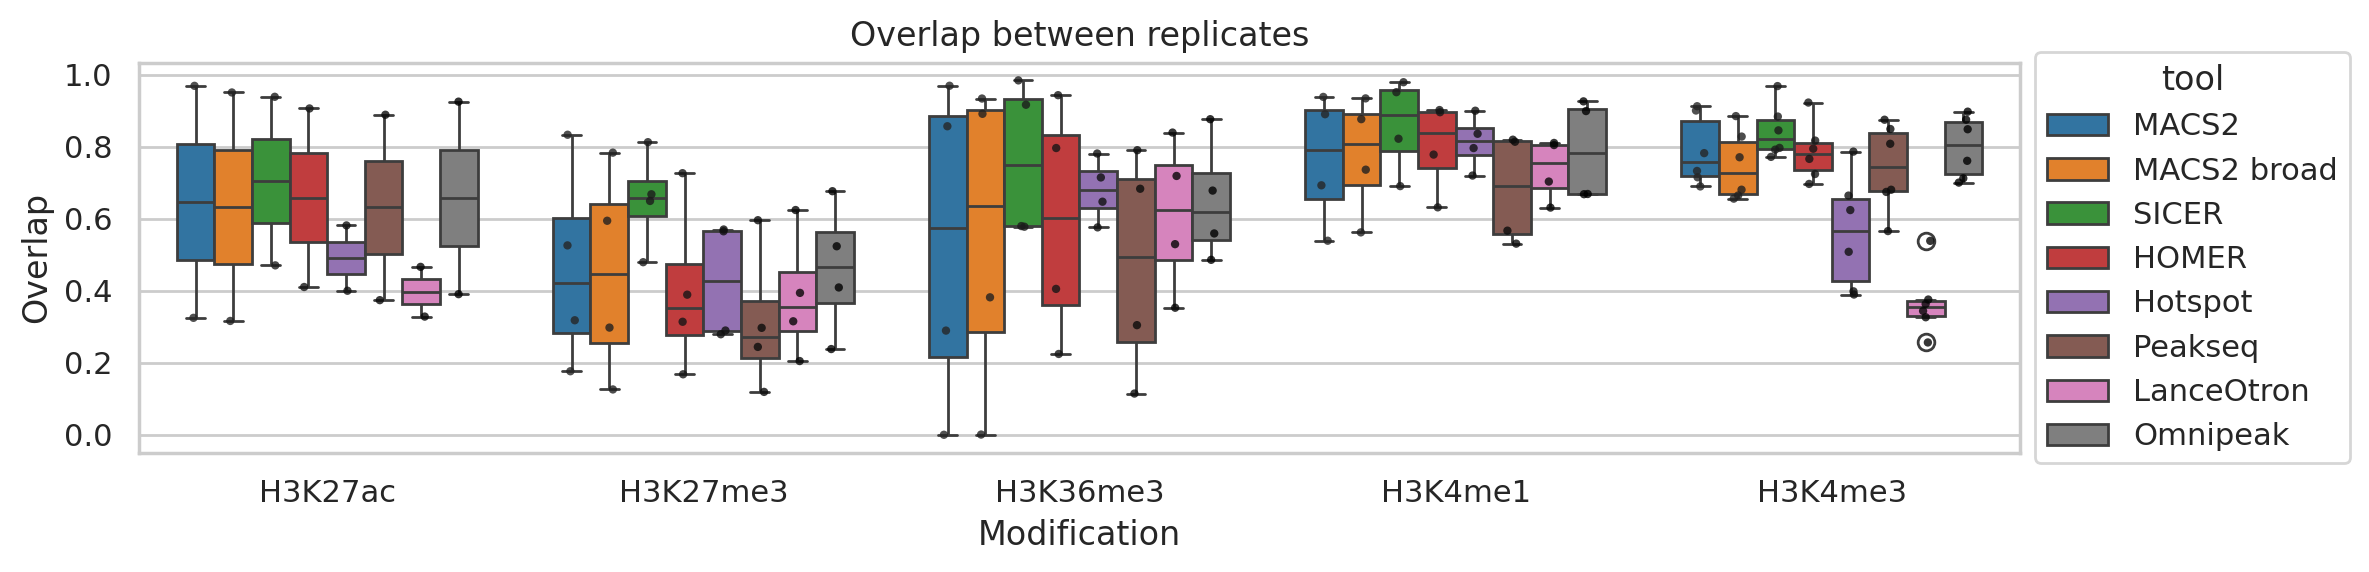

In [123]:
print('Immune')
t = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t['overlap'] = overlaps
plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=TOOLS,
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


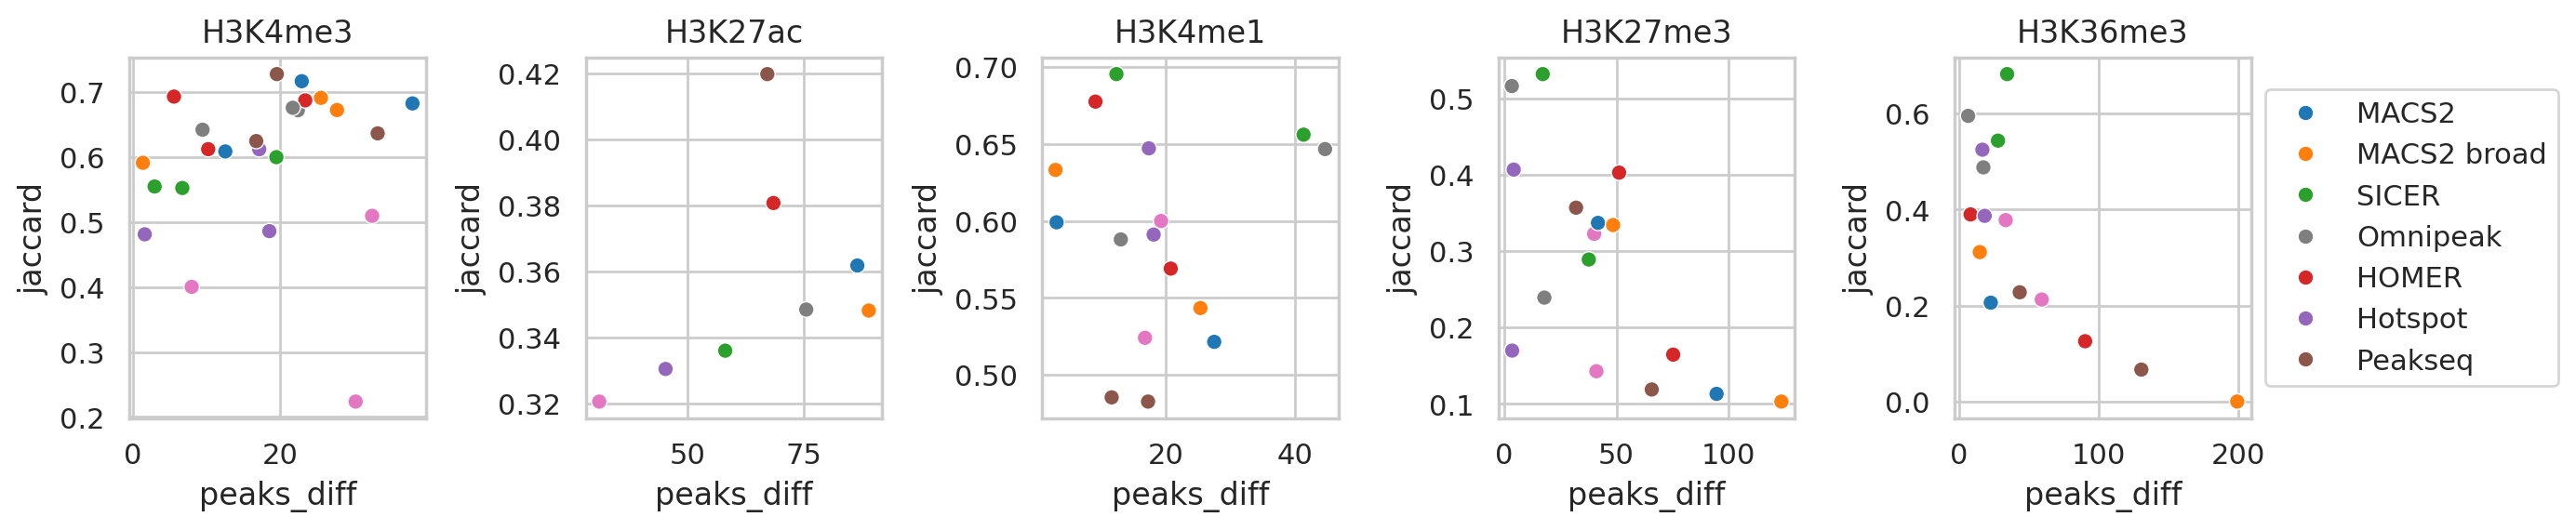

In [124]:
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']) * 200)

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'Omnipeak', 'HOMER', 'Hotspot', 'Peakseq'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Immune


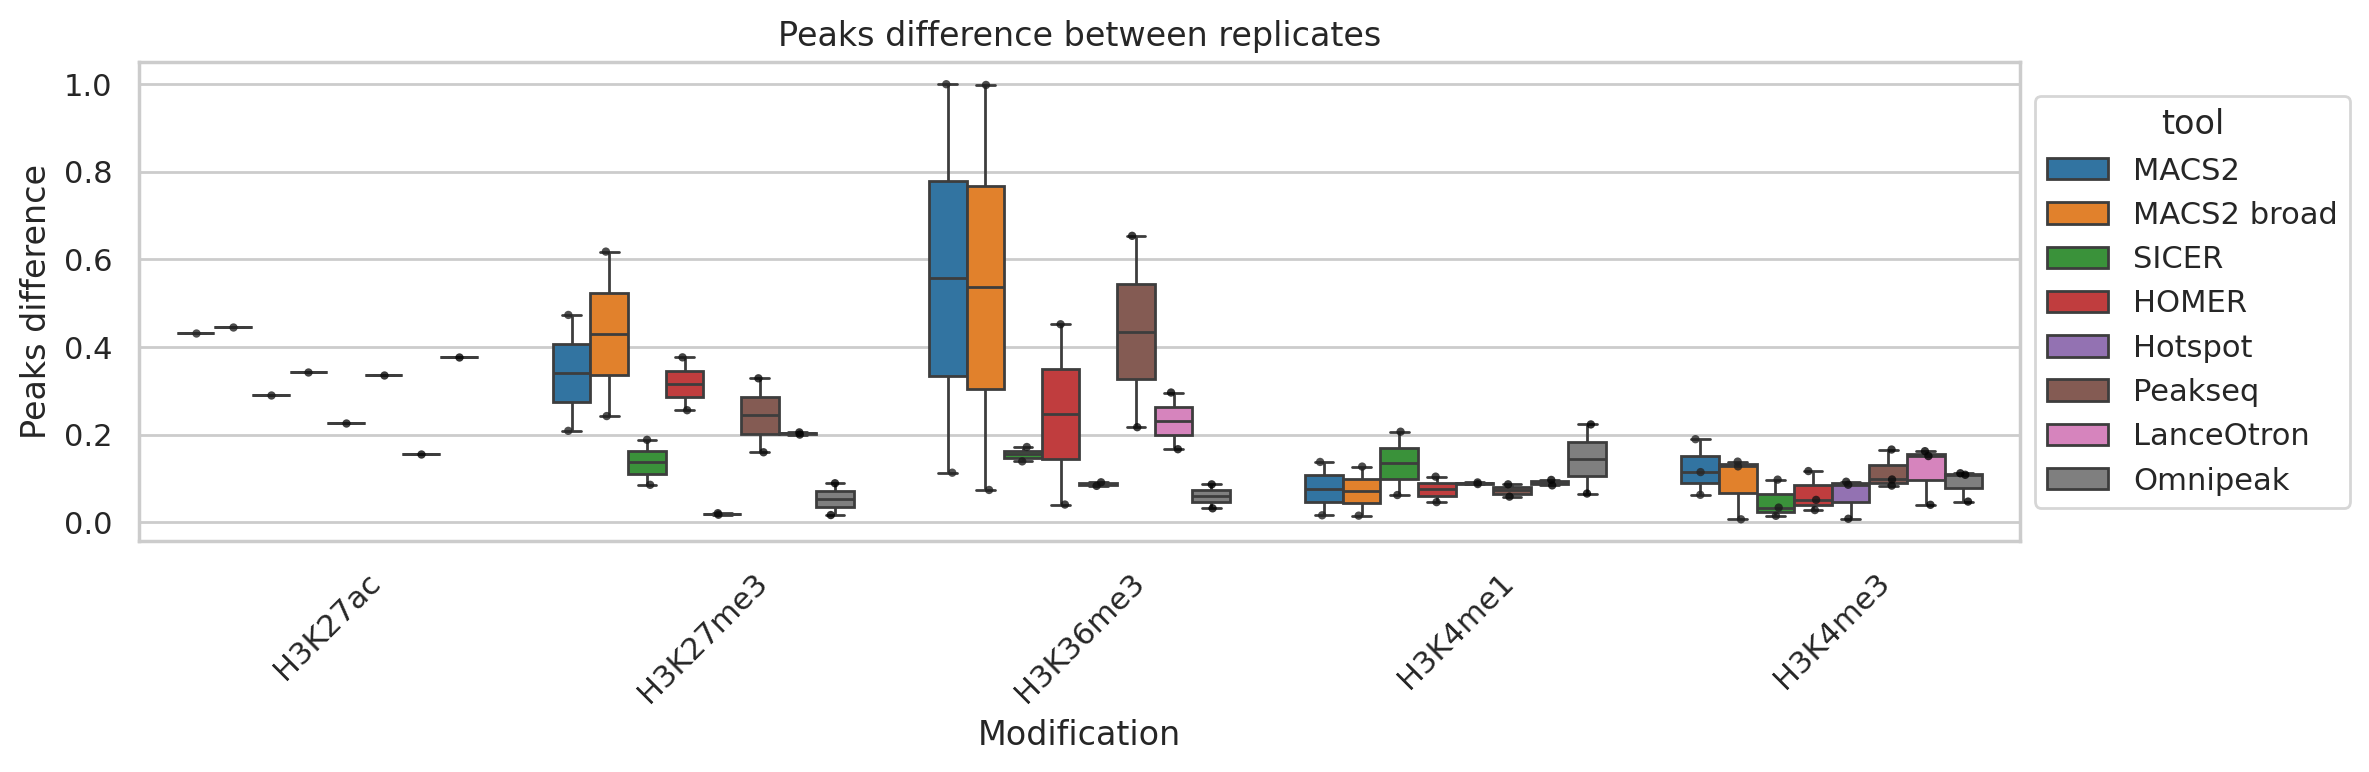

In [125]:
sns.set_style('whitegrid')
print('Immune')
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']))

plt.figure(figsize=(12, 4))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [126]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_immune_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_immune = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

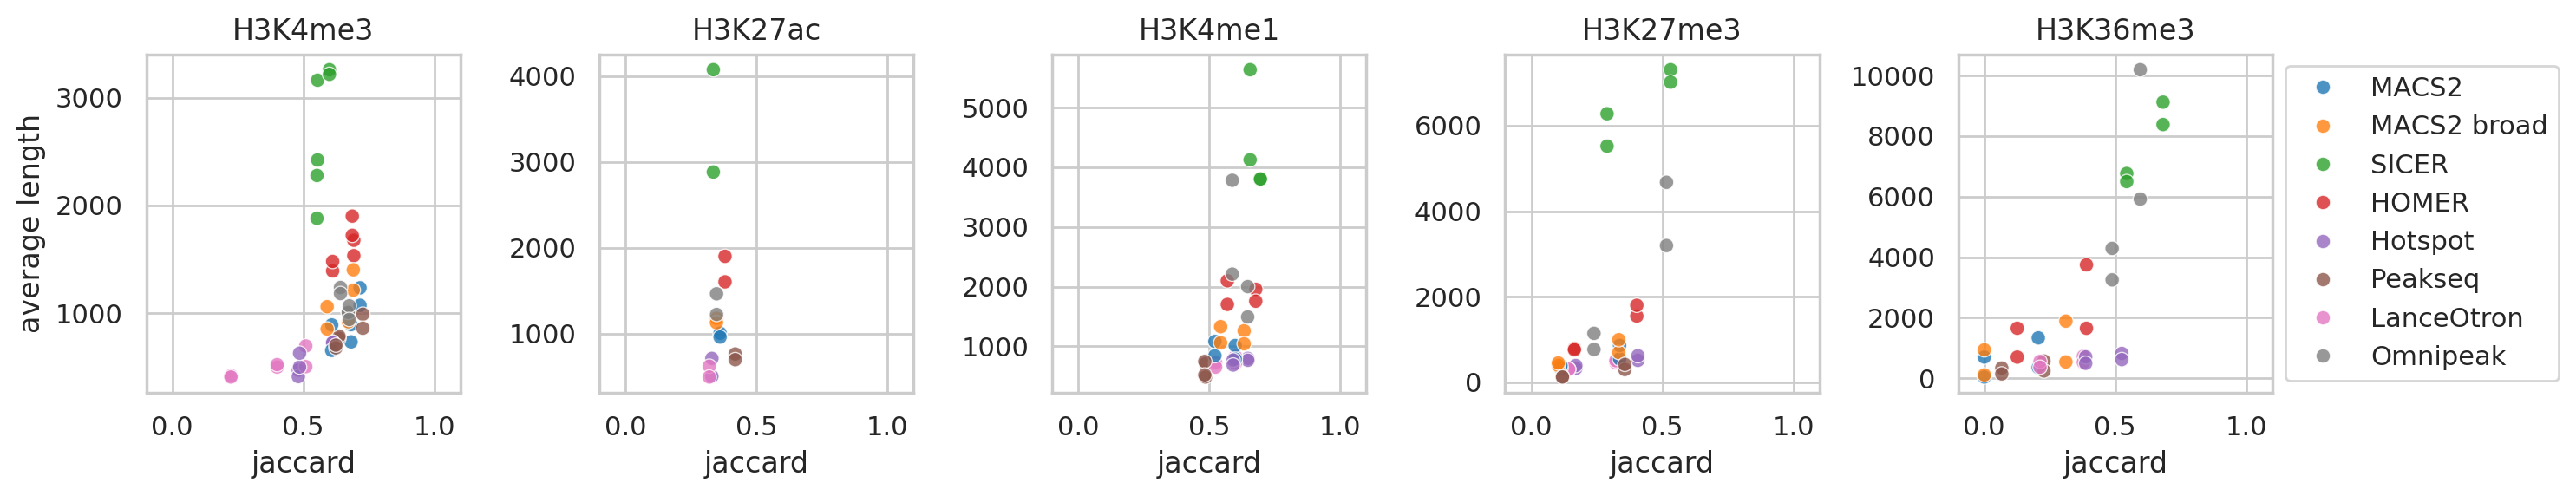

In [127]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_immune[df_jaccard_avg_len_immune['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## All

ENCODE + Roadmap


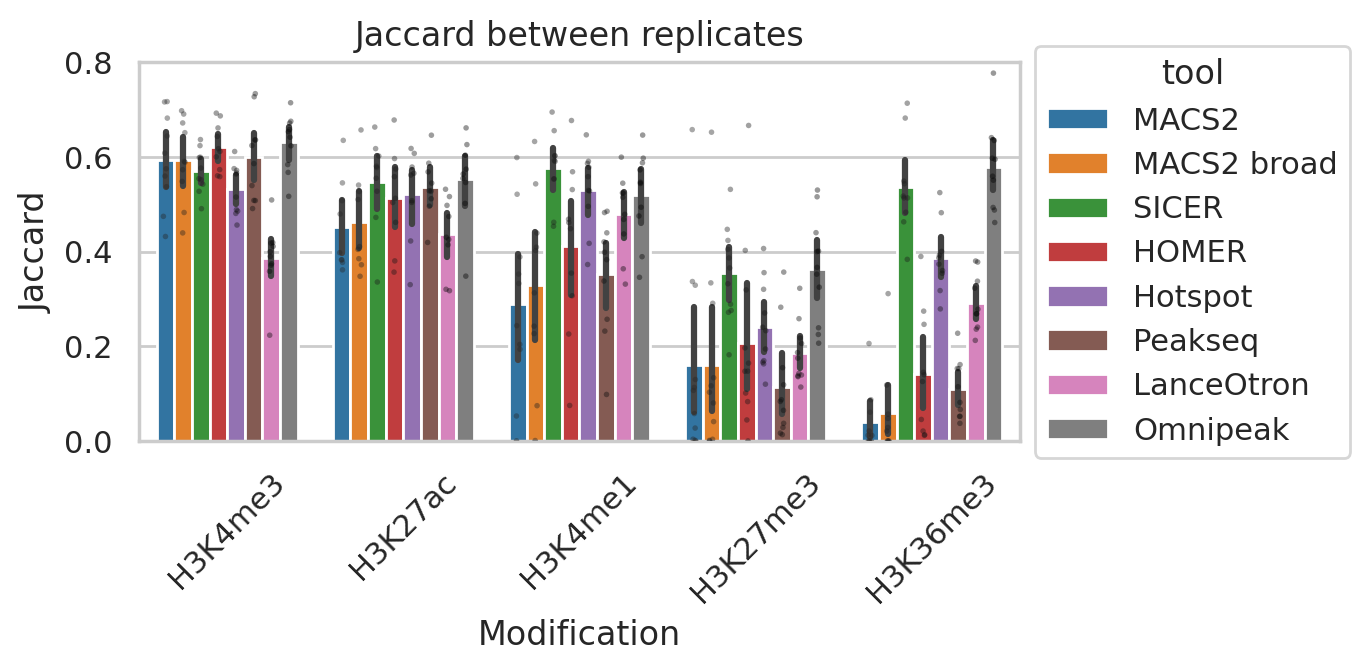

In [128]:
print('ENCODE + Roadmap')
sns.set_style("whitegrid")
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
plt.figure(figsize=(7, 3.5))
ax = plt.axes()
sns.barplot(data=t, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=TOOLS,
            # capsize=.2, err_kws={'linewidth': 2},
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='jaccard',
              dodge=True, size=2, palette='dark:black',
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False, alpha=0.4,
              ax=ax)
ax.set_ylim(0, 0.8)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [129]:
ts = []
# for df in [df_encode_reps, df_immune_reps, df_abf_reps]:
for df in [df_encode_reps, df_immune_reps]:
    t = pd.concat([df[['modification', 'cell', 'tool']],
                   df[['modification', 'cell', 'tool']]]).reset_index(drop=True)
    overlaps = [d(o, p) for o, p in zip(df['peaks1_overlap'], df['peaks1'])] + \
               [d(o, p) for o, p in zip(df['peaks2_overlap'], df['peaks2'])]
    t['overlap'] = overlaps
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)

All


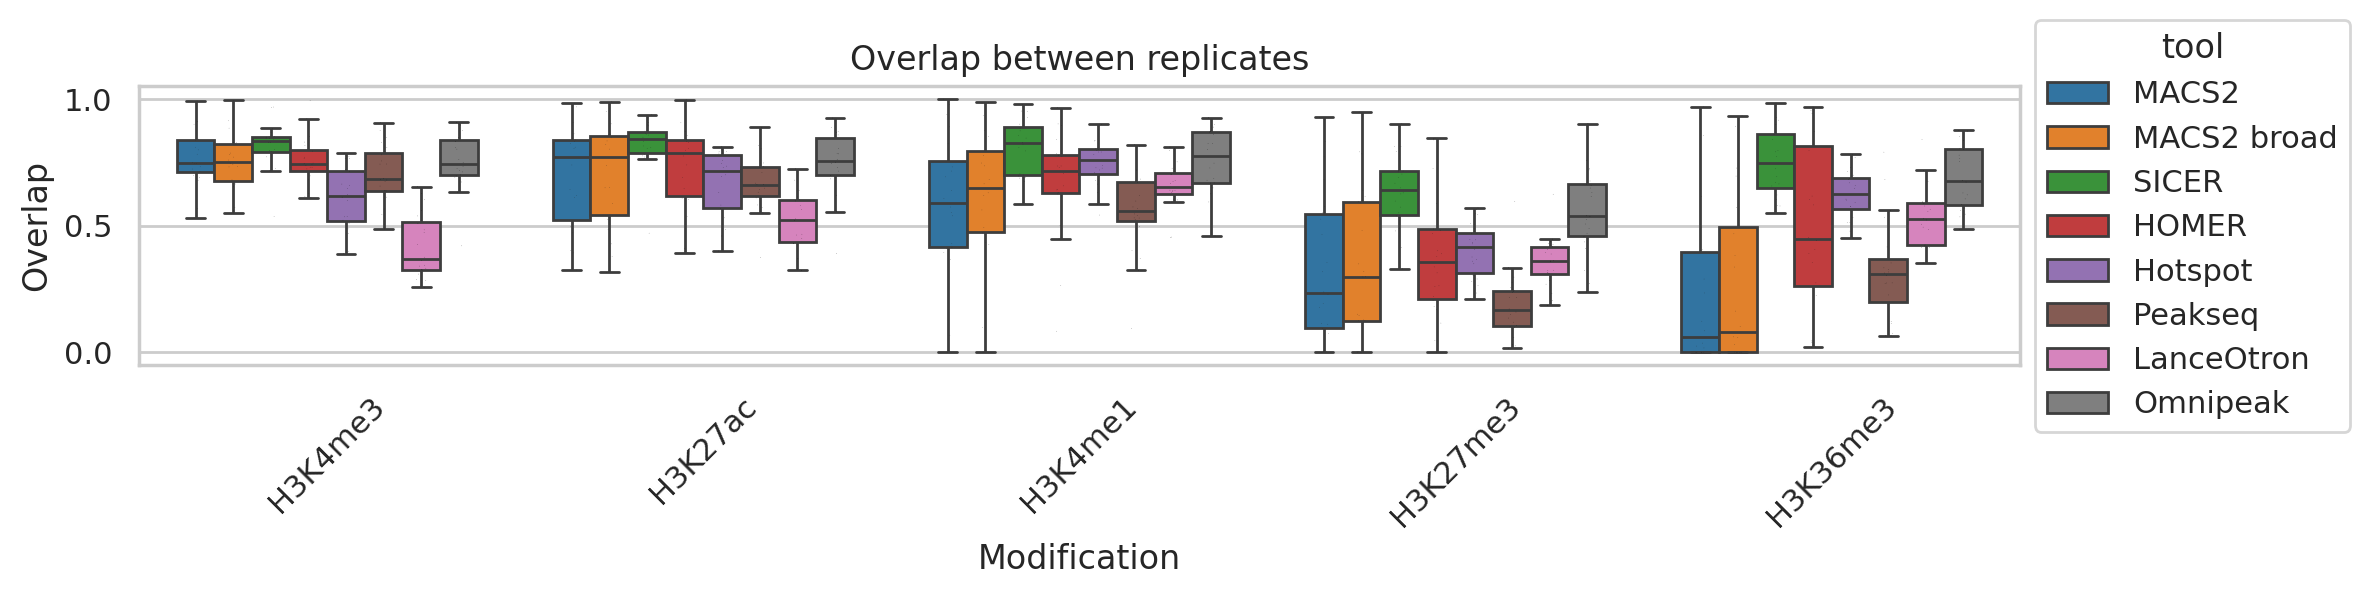

In [130]:
print('All')
sns.set_style("whitegrid")

plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=TOOLS,
            showfliers=False,
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=0.2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


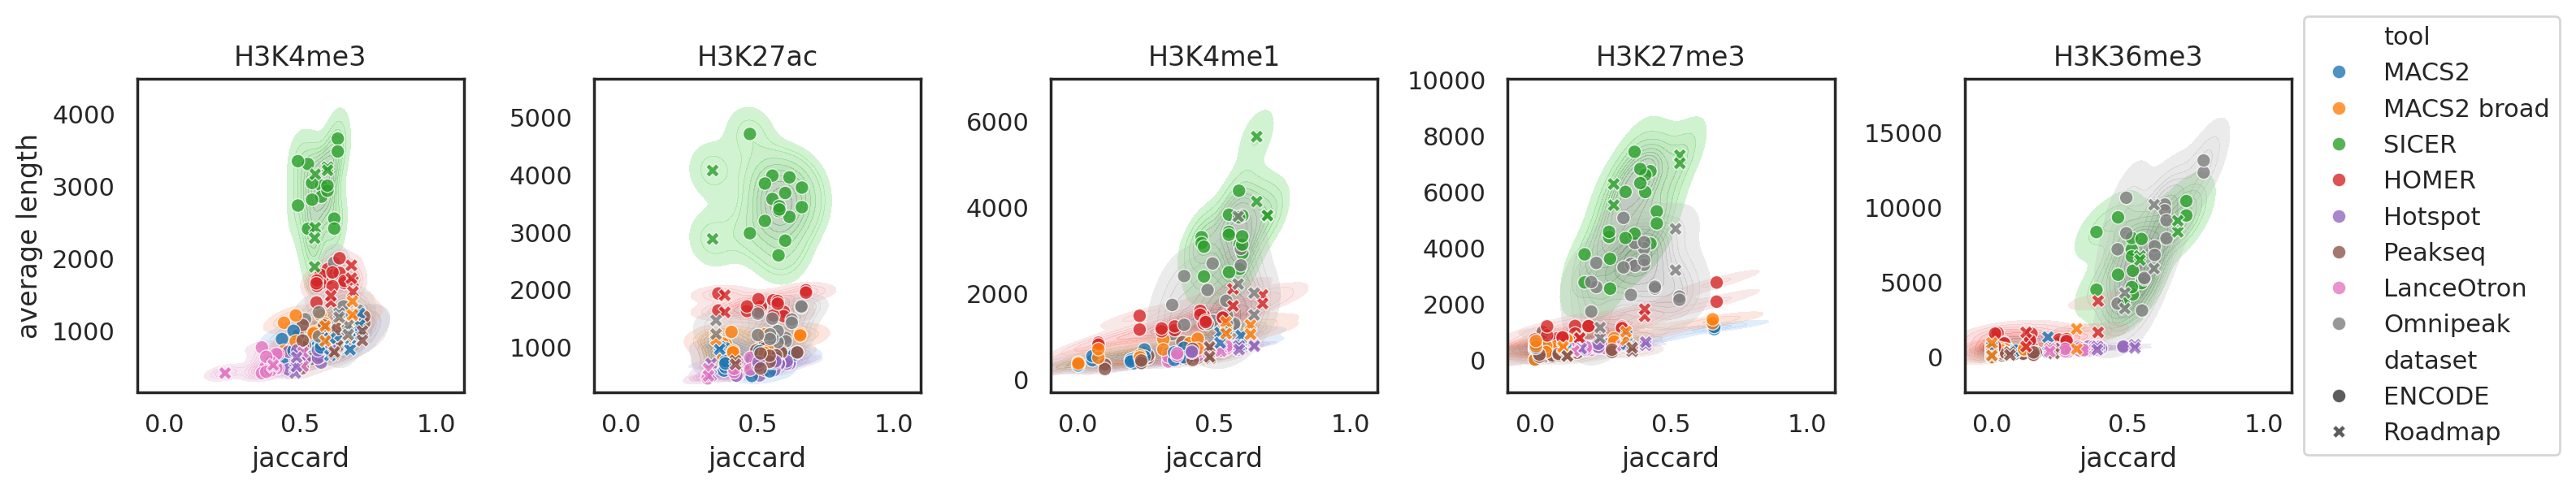

In [131]:
print('ENCODE + Roadmap')
sns.set_style("white")
# t = df_jaccard_avg_len_encode
df_jaccard_avg_len_encode['dataset'] = 'ENCODE'
df_jaccard_avg_len_immune['dataset'] = 'Roadmap'
t = pd.concat([df_jaccard_avg_len_encode, df_jaccard_avg_len_immune]).reset_index(drop=True)
plt.figure(figsize=(16, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.kdeplot(
        t[t['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.3,
        common_norm=False, common_grid=False,
        thresh=.05,
        fill=True,
        ax=ax,
    )
    sns.scatterplot(
        t[t['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        style='dataset',
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    # ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Jaccard ABF

In [132]:
df_abf_reps = compute_reps_overlap(df_abf_peaks)
df_abf_reps.sample(5)

  0%|          | 0/80 [00:00<?, ?it/s]

H3K27ac OD HOMER 20
H3K27ac OD Hotspot 20
H3K27ac OD LanceOtron 20
H3K27ac OD MACS2 20
H3K27ac OD MACS2 broad 20
H3K27ac OD Omnipeak 20
H3K27ac OD Peakseq 20
H3K27ac OD SICER 20
H3K27ac YD HOMER 18
H3K27ac YD Hotspot 18
H3K27ac YD LanceOtron 18
H3K27ac YD MACS2 18
H3K27ac YD MACS2 broad 18
H3K27ac YD Omnipeak 18
H3K27ac YD Peakseq 18
H3K27ac YD SICER 18
H3K27me3 OD HOMER 19
H3K27me3 OD Hotspot 19
H3K27me3 OD LanceOtron 19
H3K27me3 OD MACS2 19
H3K27me3 OD MACS2 broad 19
H3K27me3 OD Omnipeak 19
H3K27me3 OD Peakseq 19
H3K27me3 OD SICER 19
H3K27me3 YD HOMER 13
H3K27me3 YD Hotspot 13
H3K27me3 YD LanceOtron 13
H3K27me3 YD MACS2 13
H3K27me3 YD MACS2 broad 13
H3K27me3 YD Omnipeak 13
H3K27me3 YD Peakseq 13
H3K27me3 YD SICER 13
H3K36me3 OD HOMER 15
H3K36me3 OD Hotspot 15
H3K36me3 OD LanceOtron 15
H3K36me3 OD MACS2 15
H3K36me3 OD MACS2 broad 15
H3K36me3 OD Omnipeak 15
H3K36me3 OD Peakseq 15
H3K36me3 OD SICER 15
H3K36me3 YD HOMER 15
H3K36me3 YD Hotspot 15
H3K36me3 YD LanceOtron 15
H3K36me3 YD MACS

modification cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
4636     H3K27me3   YD      Peakseq  YD18   YD8   63748    19151866  297095   
5455     H3K36me3   OD      Peakseq  OD19   OD9  257639   120717242  228855   
947       H3K27ac   OD  MACS2 broad   OD7   OD8  144852    67457511   75515   
4302     H3K27me3   YD   LanceOtron  YD16  YD18  139522    57979949  206005   
6426      H3K4me1   OD        HOMER  OD10   OD4   95647   202706743   80197   

      peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
4636    78220056           34907           18901           15643726  0.191412  
5455    58636146          109555          152935           45876213  0.343701  
947     26494858           41799           70382           25234612  0.367221  
4302    71585667           55510           56812           27484986  0.269248  
6426   127604568           64292           74992          121708944  0.583449

ABF


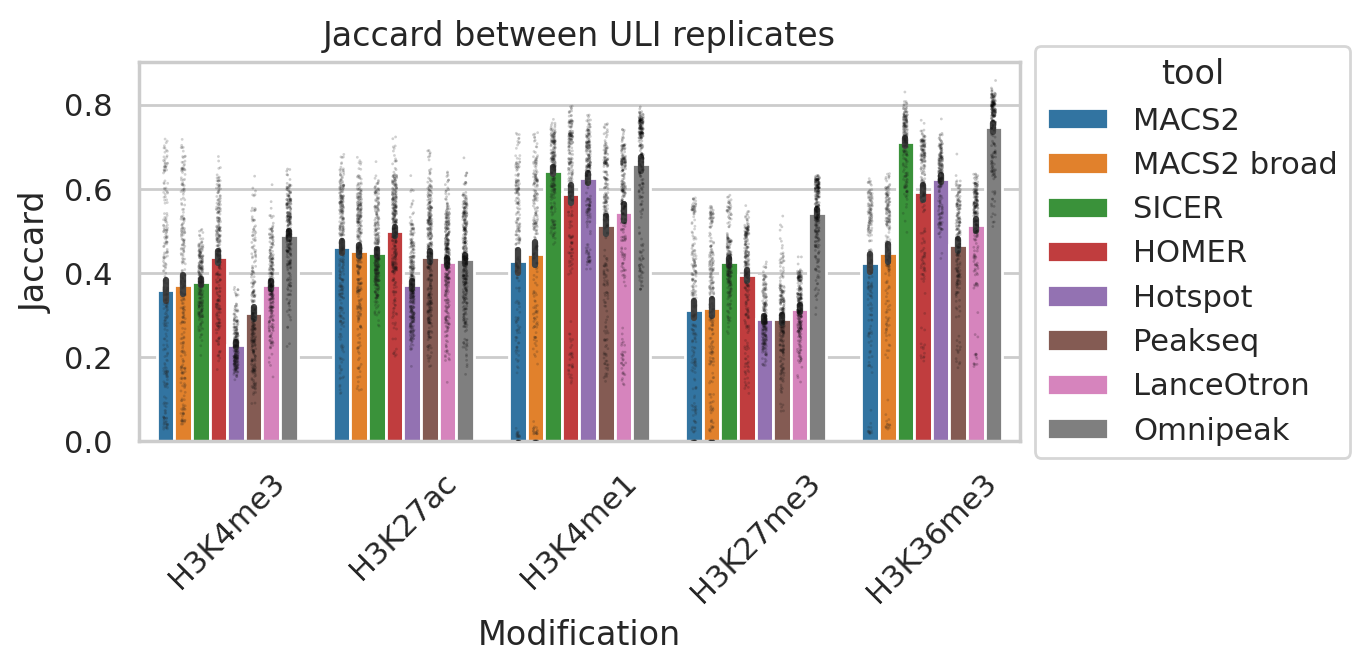

In [133]:
print('ABF')
sns.set_style("whitegrid")
plt.figure(figsize=(7, 3.5))
ax = plt.axes()
sns.barplot(data=df_abf_reps, x='modification', hue='tool', y='jaccard',
            order=MODIFICATIONS,
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            # capsize=.2, err_kws={'linewidth': 2},
            ax=ax)
sns.stripplot(data=df_abf_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=1, palette='dark:black', alpha=0.2,
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Jaccard between ULI replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# END